---
# Please don't change the text below, it's for formatting the documentation.
title: "Object Detection with Hugging Face Transformers Tutorial"
description: "Learn how to create a custom object detection model with Hugging Face Transformers."
image: "https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/00-what-were-going-to-build.png"
format: 
  html:
    code-fold: false
    page-layout: full
jupyter: python3
number-sections: true
toc: true
toc-depth: 3
toc-expand: 2 # expand toc to multiple levels
code-block-border-left: true
code-block-bg: true
---

<a target="_blank" href="https://colab.research.google.com/github/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_object_detection_tutorial.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**Note:** If you're running in Google Colab, make sure to enable GPU usage by going to Runtime -> Change runtime type -> select GPU.

[Source code on GitHub](https://github.com/mrdbourke/learn-huggingface/blob/main/notebooks/hugging_face_object_detection_tutorial.ipynb) | [Online book version](https://www.learnhuggingface.com/notebooks/hugging_face_object_detection_tutorial) | [Setup guide](https://www.learnhuggingface.com/extras/setup) | Video Course (coming soon)

## Overview

Welcome to the Learn Hugging Face Object Detection project!

Inside this project, we'll learn bits and pieces about the Hugging Face ecosystem as well as how to build our own custom object detection model.

We'll start with a collection of images with bounding box files as our dataset, fine-tune an existing computer vision model to detect items in an image and then share our model as a demo others can use.

<figure style="text-align: center;">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/00-what-were-going-to-build.png"
     alt="A presentation slide titled 'Project: Trashify' with a trash bin emoji illustrates a machine learning workflow. The first stage, 'Data,' shows an image of a hand holding trash near a bin, with bounding boxes identifying 'bin,' 'trash,' and 'hand,' and is labeled with '🤗 Hugging Face Datasets.' This feeds into the 'Model' stage, represented by a neural network diagram and labeled '🤗 Hugging Face Transformers.' Finally, the 'Demo' stage displays a screenshot of the 'Trashify Object Detection Demo V4' web application, where the model successfully identifies these elements in an input image, labeled '🤗 Hugging Face Hub/Spaces + Gradio.' Arrows indicate the flow from Data to Model to Demo." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>We're going to put on our startup hats and build a Trashify object detection model using tools from the Hugging Face ecosystem.</figcaption>
</figure>

::: {.callout-note}

Feel to keep reading through the notebook but if you'd like to run the code yourself, be sure to go through the [setup guide](https://www.learnhuggingface.com/extras/setup) first.

:::

### What we're going to build

We're going to be bulding Trashify 🚮, an **object detection model** which incentivises people to pick up trash in their local area by detecting `bin`, `trash`, `hand`.

If all three items are detected, a person gets +1 point!

For example, say you were going for a walk around your neighbourhood and took a photo of yourself picking up a piece (with your **hand** or **trash arm**) of **trash** and putting it in the **bin**, you would get a point.

With this object detection model, you could deploy it to an application which would automatically detect the target classes and then save the result to an online leaderboard. 

The incentive would be to score the most points, in turn, picking up the most piecces of trash, in a given area.

More specifically, we're going to follow the following steps:

1. **[Data](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images): Problem defintion and dataset preparation** - Getting a dataset/setting up the problem space.
2. **[Model](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2): Finding, training and evaluating a model** - Finding an object detection model suitable for our problem on Hugging Face and customizing it to our own dataset.
3. **[Demo](https://huggingface.co/spaces/mrdbourke/trashify_demo_v4): Creating a demo and put our model into the real world** - Sharing our trained model in a way others can access and use.

By the end of this project, you'll have a trained model and [demo on Hugging Face](https://huggingface.co/spaces/mrdbourke/trashify_demo_v4) you can share with others:

In [2]:
from IPython.display import HTML 

HTML("""
<iframe
	src="https://mrdbourke-trashify-demo-v4.hf.space"
	frameborder="0"
	width="850"
	height="1150"
></iframe>
""")

### What is object detection?

Object detection is the process of identifying and locating an item in an image.

Where *item* can mean almost anything.

For example: 

* Detecting car **licence plates** in a video feed (videos are a series of images) for a parking lot entrance.
* Detecting **delivery people** walking towards your front door on a security camera.
* Detecting **defects** on a manufacturing line.
* Detecting [**pot holes** in the road](https://ieeexplore.ieee.org/abstract/document/9968423) so repair works can automatically be scheduled.
* Detecting **small pests (Varroa Mite)** on the bodies of bees.
* Detecting [**weeds** in a field](https://ai.meta.com/blog/pytorch-drives-next-gen-intelligent-farming-machines/) so you know what to remove and what to keep. 

And for some trash identification examples:

* Google [open-sourcing CircularNet](https://blog.tensorflow.org/2022/10/circularnet-reducing-waste-with-machine.html) for helping to detect and identify different kinds of trash in waste management facilities.
* A [machine learning paper](https://www.sciencedirect.com/science/article/abs/pii/S0956053X23001915) for using a computer vision model on a Raspberry Pi (a small computer) for waste identification.
* [Ameru](https://www.ameru.ai) is a company building a trash-identifying bin to sort automatically sort trash as people put it in, see the [case study of hose they created their own custom dataset using Label Studio](https://labelstud.io/blog/ameru-labeling-for-a-greener-world/).

<figure style="text-align: center;">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/01-where-object-detection-is-used.png"
     alt="A collage of five images illustrating computer vision applications: the top left shows a car at a parking barrier with its license plate highlighted by a green bounding box; the top right displays various trash items on a conveyor belt, each identified and outlined by a colored bounding box and label; the bottom left is a close-up of a bee with a green bounding box highlighting a varroa mite on its back; the bottom middle features a damaged road with two potholes, each outlined by a green bounding box; and the image on the right shows a smart waste bin with an interactive screen and a green bounding box highlighting an item in its collection bag visible through a window." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Different problems where object detection can be used: license plate detection, trash type identification, pest detection on bees and pothole detection.</figcaption>
</figure>

::: {.callout-note}
**Note:** Object detection is also sometimes referred to as *image localization* or *object localization*. For consistency, I will use the term object detection, however, either of these terms could substitute.
:::

**Image classification** deals with classifying an image as a whole into a single `class`, object detection endeavours to find the specific target item and *where* it is in an image.

One of the most common ways of showing where an item is in an image is by displaying a **bounding box** (a rectangle-like box around the target item).

An object detection model will often take an input image tensor in the shape `[3, 640, 640]` (`[colour_channels, height, width]`) and output a tensor in the form `[class_name, x_min, y_min, x_max, y_max]` or `[class_name, x1, y1, x2, y2]` (this is two ways to write the same example format, there are more formats, we'll see these below in @tbl-bbox-formats).

Where:

* `class_name` = The classification of the target item (e.g. `"car"`, `"person"`, `"banana"`, `"piece_of_trash"`, this could be almost anything).
* `x_min` = The `x` value of the top left corner of the box.
* `y_min` = The `y` value of the top left corner of the box.
* `x_max` = The `x` value of the bottom right corner of the box.
* `y_max` = The `y` value of the bottom right corner of the box.

<figure style="text-align: center;">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/02-different-bounding-box-formats.png"
     alt="A side-by-side comparison of two diagrams illustrating bounding box coordinates for an image of a hand opening a metal trash bin, with the trash bin enclosed in a magenta bounding box; the left diagram, titled 'Normalized Bounding Box Coordinates in Various Formats,' displays coordinates as ratios relative to the image dimensions (960px width, 1280px height) for XYXY, XYWH, and CXCYWH formats, while the right diagram, titled 'Absolute Bounding Box Coordinates in Various Formats,' shows the same bounding box coordinates in absolute pixel values for the same formats." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Normalized bounding box coordinates in CXCYWH format as well as an absolute bounding in XYXY format.</figcaption>
</figure>

::: {.callout-tip}
## Object detection bounding box formats

When you get into the world of object detection, you will find that there are several different bounding box formats. 

There are three major formats you should be familiar with: `XYXY`, `XYWH`, `CXCYWH` (there are more but these are the most common).

Knowing which bounding box format you're working with can be the difference between a good model and a *very* poor model (wrong bounding boxes = wrong outcome).

We'll get hands-on with a couple of these in this project.

But for an in-depth example of all three, I created a [guide on different bounding box formats and how to draw them](https://www.learnml.io/posts/a-guide-to-bounding-box-formats/), reading this should give a good intuition behind each style of bounding box. 
:::


### Why train your own object detection models?

You can customize **pre-trained models** for object detection as well as API-powered models and LLMs such as [Gemini](https://ai.google.dev/gemini-api/docs/vision?lang=python#bbox), [LandingAI](https://landing.ai/agentic-object-detection) and [DINO-X](https://github.com/IDEA-Research/DINO-X-API).

Depending on your requirements, there are several pros and cons for using your own model versus using an API.

Training/fine-tuning your own model:

| Pros | Cons |
| :----- | :----- |
| **Control:** Full control over model lifecycle. | Can be complex to get setup. |
| No usage limits (aside from compute constraints). | Requires dedicated compute resources for training/inference. |
| Can train once and deploy everywhere/whenever you want (for example, Tesla deploying a model to all self-driving cars). | Requires maintenance over time to ensure performance remains up to par. |
| **Privacy:** Data can be kept in-house/app and doesn’t need to go to a third party. | Can require longer development cycles compared to using existing APIs. |
| **Speed:** Customizing a small model for a specific use case often means it runs much faster on local hardware, for example, modern object detection models can achieve 70-100+ FPS (frames per second) on modern GPU hardware. | |

Using a pre-built model API:

| Pros | Cons |
| :----- | :----- |
| **Ease of use:** often can be setup within a few lines of code. | If the model API goes down, your service goes down. |
| No maintenance of compute resources. | Data is required to be sent to a third-party for processing. |
| Access to the most advanced models. | The API may have usage limits per day/time period. |
| Can scale if usage increases. | Can be much slower than using dedicated models due to requiring an API call. |

For this project, we're going to focus on fine-tuning our own model.

### Workflow we're going to follow

The good news for us is that the Hugging Face ecosystem makes working on custom machine learning projects an absolute blast.

And workflow is reproducible across several kinds of projects.

Start with data (or skip this step and go straight to a model) -> get/customize a model -> build and share a demo.

With this in mind, our motto is *data, model, demo!*

More specifically, we're going to follow the rough workflow of:

1. Create, preprocess and load data using [Hugging Face Datasets](https://huggingface.co/docs/datasets/index).
2. Define the model we'd like use with [`transformers.AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection) (or another similar model class).
3. Define training arguments (these are hyperparameters for our model) with [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).
4. Pass `TrainingArguments` from 3 and target datasets to an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer).
5. Train the model by calling [`Trainer.train()`](https://huggingface.co/docs/transformers/v4.40.2/en/main_classes/trainer#transformers.Trainer.train).
6. Save the model (to our local machine or to the Hugging Face Hub).
7. Evaluate the trained model by making and inspecting predctions on the test data.
8. Turn the model into a shareable demo.

I say rough because machine learning projects are often non-linear in nature.

As in, because machine learning projects involve many experiments, they can kind of be all over the place.

But this worfklow will give us some good guidelines to follow.

<figure style="text-align: center; display: inline-block;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-text-classification/01-hugging-face-workflow.png"
     alt="The diagram shows the Hugging Face model development workflow, which includes the following steps: start with an idea or problem, get data ready (turn into tensors/create data splits), pick a pretrained model (to suit your problem), train/fine-tune the model on your custom data, evaluate the model, improve through experimentation, save and upload the fine-tuned model to the Hugging Face Hub, and turn your model into a shareable demo. Tools used in this workflow are Datasets/Tokenizers, Transformers/PEFT/Accelerate/timm, Hub/Spaces/Gradio, and Evaluate." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption style="width: 100%; box-sizing: border-box;">A general Hugging Face workflow from idea to shared model and demo using tools from the Hugging Face ecosystem. You'll notice some of the steps don't match with our workflow outline above. This is because the text-based workflow outline above breaks some of the steps down for educational purposes. These kind of workflows are not set in stone and are more of guide than specific directions. See information on each of the tools in the <a href="https://huggingface.co">Hugging Face documentation</a>.</figcaption>
</figure>

## Importing necessary libraries

Let's get started!

First, we'll import the required libraries.

If you're running on your local computer, be sure to check out the getting [setup guide](https://www.learnhuggingface.com/extras/setup) to make sure you have everything you need.

If you're using Google Colab, many of them the following libraries will be installed by default.

However, we'll have to install a few extras to get everything working.

::: {.callout-note}

If you're running on Google Colab, this notebook will work best with access to a GPU. To enable a GPU, go to `Runtime` ➡️ `Change runtime type` ➡️ `Hardware accelerator` ➡️ `GPU`.

::: 

We'll need to install the following libraries from the Hugging Face ecosystem:

* [`transformers`](https://huggingface.co/docs/transformers/en/installation) - comes pre-installed on Google Colab but if you're running on your local machine, you can install it via `pip install transformers`.
* [`datasets`](https://huggingface.co/docs/datasets/installation) - a library for accessing and manipulating datasets on and off the Hugging Face Hub, you can install it via `pip install datasets`.
* [`gradio`](https://www.gradio.app/guides/quickstart#installation) - a library for creating interactive demos of machine learning models, you can install it via `pip install gradio`.
* Optional: [`evaluate`](https://huggingface.co/docs/evaluate/installation) - a library for evaluating machine learning model performance with various metrics, you can install it via `pip install evaluate`.
* Optional: [`accelerate`](https://huggingface.co/docs/accelerate/basic_tutorials/install) - a library for training machine learning models faster, you can install it via `pip install accelerate`.


And the following library is not part of the Hugging Face ecosystem but it is helpful for evaluating our models: 

* [`torchmetrics`](https://lightning.ai/docs/torchmetrics/stable/) - a library containing many evaluation metrics compatible with PyTorch/Transformers, you can install it via `pip install torchmetrics`.

We can also check the versions of our software with `package_name.__version__`.

In [3]:
# Install/import dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets
  import gradio as gr
  import torchmetrics
  import pycocotools 
except ModuleNotFoundError:
  
  # If a module isn't found, install it 
  !pip install -U datasets gradio # -U stands for "upgrade" so we'll get the latest version by default
  !pip install -U torchmetrics[detection]

  import datasets
  import gradio as gr

  # Required for evalation
  import torchmetrics
  import pycocotools # make sure we have this for torchmetrics

import random

import numpy as np

import torch
import transformers

# Check versions (as long as you've got the following versions or higher, you should be good)
print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using torchmetrics version: {torchmetrics.__version__}")

Using transformers version: 4.53.0
Using datasets version: 3.6.0
Using torch version: 2.7.0+cu126
Using torchmetrics version: 1.7.1


Wonderful, as long as your versions are the same or higher to the versions above, you should be able to run the code below.

## Getting a dataset

Okay, now we're got the required libraries, let's get a dataset.

Getting a dataset is one of the most important things a machine learning project.

The dataset you often determines the type of model you use as well as the quality of the outputs of that model.

Meaning, if you have a high quality dataset, chances are, your future model could also have high quality outputs.

It also means if your dataset is of poor quality, your model will likely also have poor quality outputs.

For an object detection problem, your dataset will likely come in the form of a group of images as well as a file with annotations belonging to those images.

For example, you might have the following setup: 

```
folder_of_images/
    image_1.jpeg
    image_2.jpeg
    image_3.jpeg
annotations.json
```

Where the `annotations.json` contains details about the contains of each image: 

```{.json filename="annotations.json"}
[
    {
        'image_path': 'image_1.jpeg', 
        'image_id': 42,
        'annotations': 
            {
                'file_name': ['image_1.jpeg'],
                'image_id': [42],
                'category_id': [1],
                'bbox': [
                            [360.20001220703125, 528.5, 177.1999969482422, 261.79998779296875],
                        ],
                'area': [46390.9609375]
            },
        'label_source': 'manual_prodigy_label',
        'image_source': 'manual_taken_photo'
    },

    ...(more labels down here)
]
```

Don't worry too much about the exact meaning of everything in the above `annotations.json` file for now (this is only one example, there are many different ways object detection information could be displayed).

The main point is that each target image is paired with an assosciated label.

Now like all good machine learning cooking shows, I've prepared a dataset from earlier.

<figure style="text-align: center;">
    <a href="https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/03-trashify-dataset-on-huggingface.png"
     alt="A screenshot of a Hugging Face webpage displaying the 'mrdbourke/trashify_manual_labelled_images' dataset, showing the 'Dataset card' tab with the 'Dataset Viewer' section visible, which lists image thumbnails, 'image_id', 'annotations', 'label_source', and 'image_source' for each entry; on the right sidebar, dataset statistics like 'Downloads last month' (106), 'Size of downloaded dataset files' (1.03 GB), and 'Number of rows' (1,128) are displayed, along with a 'Use this dataset' button; below the viewer, a 'Load data' section shows Python code to import and load the dataset using the 'datasets' library." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     </a>
     <figcaption>Our Trashify dataset is available on Hugging Face. These images have been labelled manually with bounding boxes for different classes.</figcaption>
</figure>

It's stored on Hugging Face Datasets (also called the Hugging Face Hub) under the name [`mrdbourke/trashify_manual_labelled_images`](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

This is a dataset I've collected manually by hand (yes, by picking up 1000+ pieces of trash and photographing it) as well as labelled by hand (by drawing boxes on each image with a labelling tool called [Prodigy](https://prodi.gy/features/computer-vision)).


### Loading the dataset 

To load a dataset stored on the Hugging Face Hub we can use the [`datasets.load_dataset(path=NAME_OR_PATH_OF_DATASET)`](https://huggingface.co/docs/datasets/en/package_reference/loading_methods#datasets.load_dataset) function and pass it the name/path of the dataset we want to load.

In our case, our dataset name is `mrdbourke/trashify_manual_labelled_images` (you can also change this for your own dataset).

And since our dataset is hosted on Hugging Face, when we run the following code for the first time, it will download it.

If your target dataset is quite large, this download may take a while.

However, once the dataset is downloaded, subsequent reloads will be mush faster.

::: {.callout-tip title="Getting information about a function/method"}

One way to find out what a function or method does is to lookup the documentation.

Another way is to write the function/method name with a question mark afterwards.

For example:

```python
from datasets import load_dataset

load_dataset?
```

Give it a try.

You should see some helpful information about what inputs the method takes and how they are used.
:::

Let's load our dataset and check it out. 

In [4]:
from datasets import load_dataset

# Load our Trashify dataset
dataset = load_dataset(path="mrdbourke/trashify_manual_labelled_images")

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

Beautiful!

We can see that there is a `train` split of the dataset already which currently contains all of the samples (`1128` in total).

There are also some `features` that come with our dataset which are related to our object detection goal. 

In [5]:
print(f"[INFO] Length of original dataset: {len(dataset['train'])}")
print(f"[INFO] Dataset features:") 

from pprint import pprint

pprint(dataset['train'].features)

[INFO] Length of original dataset: 1128
[INFO] Dataset features:
{'annotations': Sequence(feature={'area': Value(dtype='float32', id=None),
                                  'bbox': Sequence(feature=Value(dtype='float32',
                                                                 id=None),
                                                   length=4,
                                                   id=None),
                                  'category_id': ClassLabel(names=['bin',
                                                                   'hand',
                                                                   'not_bin',
                                                                   'not_hand',
                                                                   'not_trash',
                                                                   'trash',
                                                                   'trash_arm'],
                                      

Nice!

We can see our dataset `features` contain the following fields: 

* `annotations` - A sequence of values including a `bbox` field (short for bounding box) as well as `category_id` field which contains the target objects we'd like to identify in our images (`['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']`).
* `image` - This contains the target image assosciated with a given set of `annotations` (in our case, images and annotations have been uploaded to the Hugging Face Hub together).
* `image_id` - A unique ID assigned to a given sample.
* `image_source` - Where the image came from (all of our images have been manually collected).
* `label_source` - Where the image label came from (all of our images have been manually labelled).



### Viewing a single sample from our data

Now we've seen the features, let's check out a single sample from our dataset.

We can index on a single sample of the `"train"` set just like indexing on a Python list.

In [7]:
# View a single sample of the dataset
dataset["train"][42]

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 745,
 'annotations': {'file_name': ['094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg'],
  'image_id': [745, 745, 745],
  'category_id': [5, 1, 0],
  'bbox': [[333.1000061035156,
    611.2000122070312,
    244.89999389648438,
    321.29998779296875],
   [504.0, 612.9000244140625, 451.29998779296875, 650.7999877929688],
   [202.8000030517578,
    366.20001220703125,
    532.9000244140625,
    555.4000244140625]],
  'iscrowd': [0, 0, 0],
  'area': [78686.3671875, 293706.03125, 295972.65625]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

We see a few more details here compared to just looking at the features.

We notice the `image` is a [`PIL.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html) with size `960x1280` (width x height).

And the `file_name` is a UUID (Universially Unique Identifier, made with [`uuid.uuid4()`](https://docs.python.org/3/library/uuid.html#uuid.uuid4)).

The `bbox` field in the `annotations` key contains a list of bounding boxes assosciated with the image.

In this case, there are 3 different bounding boxes.

With the `category_id` values of `5`, `1`, `0` (we'll map these to class names shortly). 

Let's inspect a single bounding box.

In [8]:
dataset["train"][42]["annotations"]["bbox"][0]

[333.1000061035156, 611.2000122070312, 244.89999389648438, 321.29998779296875]

This array gives us the coordinates of a single bounding box in the format `XYWH`.

Where:

* `X` is the x-coordinate of the top left corner of the box (`333.1`).
* `Y` is the y-coordinate of the top left corner of the box (`611.2`).
* `W` is the width of the box (`244.9`).
* `H` is the height of the box (`321.3`).

All of these values are in absolute pixel values (meaning an x-coordinate of `333.1` is `333.1` pixels across on the x-axis).

How do I know this? 

I know this because I created the box labels and this is the default value Prodigy (the labelling tool I used) outputs boxes.

However, if you were to come across another bouding box dataset, one of the first steps would be to **figure out what format your bounding boxes are in**.

We'll see more on bounding box formats shortly.

### Extracting the category names from our data

Before we start to visualize our sample image and bounding boxes, let's extract the category names from our dataset.

We can do so by accessing the `features` attribute our of `dataset` and then following it through to find the `category_id` feature, this contains a list of our text-based class names.

::: {.callout-note}
When working with different categories, it's good practice to get a list or mapping (e.g. a Python dictionary) from category name to ID and vice versa.

For example:

```python
# Category to ID
{"class_name": 0}

# ID to Category
{0: "class_name"}
```

Not all datasets will have this implemented in an easy to access way, so it might take a bit of research to get it created.
:::

Let's access the class names in our dataset and save them to a variable `categories`.


In [ ]:
# Get the categories from the dataset
# Note: This requires the dataset to have been uploaded with this information setup, not all datasets will have this available.
categories = dataset["train"].features["annotations"]["category_id"]

# Get the names attribute
categories.feature.names

['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']

Beautiful!

We get the following class names: 

* `bin` - A rubbish bin or trash can.
* `hand` - A person's hand.
* `not_bin` - Negative version of `bin` for items that look like a `bin` but shouldn't be identified as one.
* `not_hand` - Negative version of `hand` for items that look like a `hand` but shouldn't be identified as one.
* `not_trash` - Negative version of `trash` for items that look like `trash` but shouldn't be identified as it.
* `trash` - An item of trash you might find on a walk such as an old plastic bottle, food wrapper, cigarette butt or used coffee cup. 
* `trash_arm` - A mechanical arm used for picking up trash.

The goal of our computer vision model will be: given an image, detect items belonging to these target classes if they are present. 

### Creating a mapping from numbers to labels

Now we've got our text-based class names, let's create a mapping from label to ID and ID to label.

For each of these, Hugging Face use the terminology `label2id` and `id2label` respectively.

In [ ]:
# Map ID's to class names and vice versa
id2label = {i: class_name for i, class_name in enumerate(categories.feature.names)}
label2id = {value: key for key, value in id2label.items()}

print(f"Label to ID mapping:\n{label2id}\n")
print(f"ID to label mapping:\n{id2label}")
# id2label, label2id

Label to ID mapping:
{'bin': 0, 'hand': 1, 'not_bin': 2, 'not_hand': 3, 'not_trash': 4, 'trash': 5, 'trash_arm': 6}

ID to label mapping:
{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash', 6: 'trash_arm'}


### Creating a colour palette

Ok we know which class name matches to which ID, now let's create a dictionary of different colours we can use to display our bounding boxes.

It's one thing to plot bounding boxes, it's another thing to make them look nice.

And we always want our plots looking nice!

We'll colour the positive classes `bin`, `hand`, `trash`, `trash_arm` in nice bright colours.

And the negative classes `not_bin`, `not_hand`, `not_trash` in a light red colour to indicate they're the negative versions.

Our colour dictionary will map `class_name` -> `(red, green, blue)`  (or [RGB](https://en.wikipedia.org/wiki/RGB_color_model)) colour values.

In [8]:
# Make colour dictionary
colour_palette = {
    'bin': (0, 0, 224),         # Bright Blue (High contrast with greenery) in format (red, green, blue)
    'not_bin': (255, 80, 80),   # Light Red to indicate negative class

    'hand': (148, 0, 211),      # Dark Purple (Contrasts well with skin tones)
    'not_hand': (255, 80, 80),  # Light Red to indicate negative class

    'trash': (0, 255, 0),       # Bright Green (For trash-related items)
    'not_trash': (255, 80, 80), # Light Red to indicate negative class

    'trash_arm': (255, 140, 0), # Deep Orange (Highly visible)
}

Let's check out what these colours look like!

It's the ABV motto: *Always Be Visualizing!*

We can plot our colours with `matplotlib`. 

We'll just have to write a small function to normalize our colour values from `[0, 255]` to `[0, 1]` (`matplotlib` expects our colour values to be between 0 and 1).

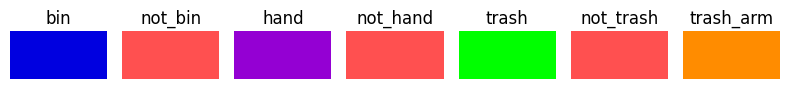

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize RGB values to 0-1 range
def normalize_rgb(rgb_tuple):
    return tuple(x/255 for x in rgb_tuple)

# Turn colors into normalized RGB values for matplotlib
colors_and_labels_rgb = [(key, normalize_rgb(value)) for key, value in colour_palette.items()]

# Create figure and axis
fig, ax = plt.subplots(1, 7, figsize=(8, 1))

# Flatten the axis array for easier iteration
ax = ax.flatten()

# Plot each color square
for idx, (label, color) in enumerate(colors_and_labels_rgb):
    ax[idx].add_patch(plt.Rectangle(xy=(0, 0), 
                                    width=1, 
                                    height=1, 
                                    facecolor=color))
    ax[idx].set_title(label)
    ax[idx].set_xlim(0, 1)
    ax[idx].set_ylim(0, 1)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

Sensational!

Now we know what colours to look out for when we visualize our bounding boxes.

## Plotting a single image and visualizing the boxes

Okay, okay, finally time to plot an image!

Let's take a random sample from our `dataset` and plot the image as well as the box on it.


### Creating helper functions to help with visualization

To save some space in our notebook (plotting many images can increase the size of our notebook dramatically), we'll create two small helper functions:

1. `half_image` - Halves the size of a given image.
2. `half_boxes` - Divides the input coordinates of a given input box by 2.

These functions aren't 100% necessary in our workflow.

They're just to make the images slightly smaller so they fit better in the notebook.

In [10]:
import PIL

def half_image(image: PIL.Image) -> PIL.Image:
    """
    Resizes a given input image by half and returns the smaller version.
    """
    return image.resize(size=(image.size[0] // 2, image.size[1] // 2))

def half_boxes(boxes):
    """
    Halves an array/tensor of input boxes and returns them. Necessary for plotting them on a half-sized image.

    For example:

    boxes = [100, 100, 100, 100]
    half_boxes = half_boxes(boxes)
    print(half_boxes)

    >>> [50, 50, 50, 50]
    """
    if isinstance(boxes, list):
        # If boxes are list of lists, then we have multiple boxes
        for box in boxes:
            if isinstance(box, list):
                return [[coordinate // 2 for coordinate in box] for box in boxes]
            else:
                return [coordinate // 2 for coordinate in boxes]         
    
    if isinstance(boxes, np.ndarray):
        return (boxes // 2)
    
    if isinstance(boxes, torch.Tensor):
        return (boxes // 2)

# Test the functions 
image_test = dataset["train"][42]["image"]
image_test_half = half_image(image_test)
print(f"[INFO] Original image size: {image_test.size} | Half image size: {image_test_half.size}")

boxes_test_list = [100, 100, 100, 100]
print(f"[INFO] Original boxes: {boxes_test_list} | Half boxes: {half_boxes(boxes_test_list)}")

boxes_test_torch = torch.tensor([100.0, 100.0, 100.0, 100.0])
print(f"[INFO] Original boxes: {boxes_test_torch} | Half boxes: {half_boxes(boxes_test_torch)}")

[INFO] Original image size: (960, 1280) | Half image size: (480, 640)
[INFO] Original boxes: [100, 100, 100, 100] | Half boxes: [50, 50, 50, 50]
[INFO] Original boxes: tensor([100., 100., 100., 100.]) | Half boxes: tensor([50., 50., 50., 50.])


### Plotting boxes on a single image step by step

To plot an image and its assosciated boxes, we'll do the following steps:

1. Select a random sample from the `dataset`.
2. Extract the `"image"` (our image is in `PIL` format) and `"bbox"` keys from the random sample.
    * We can also *optionally* halve the size of our image/boxes to save space. In our case, we will halve our image and boxes.
3. Turn the box coordinates into a `torch.tensor` (we'll be using `torchvision` utilities to plot the image and boxes).
4. Convert the box format from `XYXY` to `XYWH` using [`torchvision.ops.box_convert`](https://pytorch.org/vision/main/generated/torchvision.ops.box_convert.html) (we do this because `torchvision.utils.draw_bounding_boxes` requires `XYXY` format as input).
5. Get a list of label names (e.g. `"bin", "trash"`, etc) assosciated with each of the boxes as well as a list of colours to match (these will be from our `colour_palette`).
6. Draw the boxes on the target image by:
    * Turning the image into a tensor with [`torchvision.transforms.functional.pil_to_tensor`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.pil_to_tensor.html).
    * Draw the bounding boxes on our image tensor with [`torchvision.utils.draw_bounding_boxes`](https://pytorch.org/vision/main/generated/torchvision.utils.draw_bounding_boxes.html).
    * Turn the image and bounding box tensors back into a `PIL` image with [`torchvision.transforms.functional.to_pil_image`](https://docs.pytorch.org/vision/main/generated/torchvision.transforms.functional.to_pil_image.html).

Phew!

A fair few steps...

But we've got this!

::: {.callout-note}

If the terms `XYXY` or `XYWH` or all of the drawing methods sound a bit confusing or intimidating, don't worry, there's a fair bit going on here.

We'll cover bounding box formats, such as `XYXY` shortly.

In the meantime, if you want to learn more about different bounding box formats and how to draw them, I wrote [*A Guide to Bounding Box Formats and How to Draw Them*](https://www.learnml.io/posts/a-guide-to-bounding-box-formats/) which you might find helpful.

:::

[INFO] Showing training sample from index: 264
Boxes in XYWH format: tensor([[ 64., 256., 308., 304.],
        [267., 344.,  92., 121.],
        [149., 256., 175., 186.]])
Boxes XYXY: tensor([[ 64., 256., 372., 560.],
        [267., 344., 359., 465.],
        [149., 256., 324., 442.]])
Label names: ['bin', 'hand', 'trash']
Colour codes: [(0, 0, 224), (148, 0, 211), (0, 255, 0)]


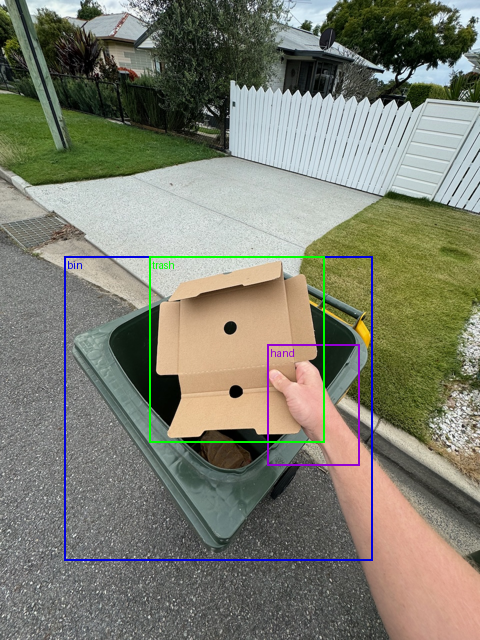

In [11]:
# Plotting a bounding box on a single image
import random

import torch

from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes

from torchvision.transforms.functional import pil_to_tensor, to_pil_image 

# 1. Select a random sample from our dataset
random_index = random.randint(0, len(dataset["train"]))
print(f"[INFO] Showing training sample from index: {random_index}")
random_sample = dataset["train"][random_index]

# 2. Get image and boxes from random sample
random_sample_image = random_sample["image"]
random_sample_boxes = random_sample["annotations"]["bbox"]

# Optional: Half the image and boxes for space saving (all of the following code will work with/without half size images)
half_random_sample_image = half_image(random_sample_image)
half_random_sample_boxes = half_boxes(random_sample_boxes)

# 3. Turn box coordinates in a tensor
boxes_xywh = torch.tensor(half_random_sample_boxes)
print(f"Boxes in XYWH format: {boxes_xywh}")

# 4. Convert boxes from XYWH -> XYXY 
# torchvision.utils.draw_bounding_boxes requires input boxes in XYXY format (X_min, y_min, X_max, y_max)
boxes_xyxy = box_convert(boxes=boxes_xywh,
                         in_fmt="xywh",
                         out_fmt="xyxy")
print(f"Boxes XYXY: {boxes_xyxy}")

# 5. Get label names of target boxes and colours to match
random_sample_label_names = [categories.int2str(x) for x in random_sample["annotations"]["category_id"]]
random_sample_colours = [colour_palette[label_name] for label_name in random_sample_label_names]
print(f"Label names: {random_sample_label_names}")
print(f"Colour codes: {random_sample_colours}")

# 6. Draw the boxes on the image as a tensor and then turn it into a PIL image
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=half_random_sample_image),
        boxes=boxes_xyxy,
        colors=random_sample_colours,
        labels=random_sample_label_names,
        width=2,
        label_colors=random_sample_colours
    )
)

Outstanding!

Our first official bounding boxes plotted on an image!

Now the idea of Trashify 🚮 is coming to life.

Depending on the random sample you're looking at, you should see some combination of `['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']`.

Our goal will be to build an object detection model to replicate these boxes on a given image.

::: {.callout-tip}

## Getting familiar with a dataset: viewing 100 random samples

Whenever working with a new dataset, I find it good practice to view 100+ random samples of the data.

In our case, this would mean viewing 100 random images with their bounding boxes drawn on them.

Doing so starts to build your own intuition of the data.

Using this intuition, along with evaluation metrics, you can start to get a better idea of how your model might be performing later on.

Keep this in mind for any new dataset or problem space you're working on.

Start by looking at 100+ random samples.

And yes, generally more is better.

So you can practice by running the code cell above a number of times to see the different kinds of images and boxes in the dataset.

Can you think of any scenarios which the dataset might be missing?

:::

## Different bounding box formats

When drawing our bounding box, we discussed the terms `XYXY` and `XYWH`.

Well, we didn't really discuss these at all...

But that's why we're here.

One of the most confusing things in the world of object detection is the different formats bounding boxes come in.

Are your boxes in `XYXY`, `XYWH` or `CXCYWH`? 

Are they in absolute format?

Or normalized format?

Perhaps a table will help us.

The following table contains a non-exhaustive list of some of the most common bounding box formats you'll come across in the wild.

| **Box format** | **Description** | **Absolute Example** | **Normalized Example** | **Source** |
| ----- | ----- | ----- | ----- | ----- |
| XYXY | Describes the top left corner coordinates `(x1, y1)` as well as the bottom right corner coordinates of a box. <br> Also referred to as: <br> `[x1, y1, x2, y2]`  <br> or <br> `[x_min, y_min, x_max, y_max]` | `[8.9, 275.3, 867.5, 964.0]` | `[0.009, 0.215, 0.904, 0.753]` | [PASCAL VOC Dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/htmldoc/devkit_doc.html#SECTION00053000000000000000) uses the absolute version of this format, [`torchvision.utils.draw_bounding_boxes`](https://pytorch.org/vision/main/generated/torchvision.utils.draw_bounding_boxes.html#draw-bounding-boxes) defaults to the absolute version of this format. |
| XYWH | Describes the top left corner coordinates `(x1, y1)` as well as the width (`box_width`) and height (`box_height`) of the target box. The bottom right corners `(x2, y2)` are found by adding the width and height to the top left corner coordinates `(x1 + box_width, y1 + box_height)`. <br> Also referred to as: <br> `[x1, y1, box_width, box_height]` <br> or <br> `[x_min, y_min, box_width, box_height]` | `[8.9, 275.3, 858.6, 688.7]` | `[0.009, 0.215, 0.894, 0.538]` | The [COCO (Common Objects in Context) dataset](https://cocodataset.org/#format-data) uses the absolute version of this format, see the section under "bbox". |
| CXCYWH | Describes the center coordinates of the bounding box `(center_x, center_y)` as well as the width (`box_width`) and height (`box_height`) of the target box. <br> Also referred to as: <br> `[center_x, center_y, box_width, box_height]` | `[438.2, 619.65, 858.6, 688.7]` | `[0.456, 0.484, 0.894, 0.538]` | Normalized version introduced in the [YOLOv3 (You Only Look Once) paper](https://arxiv.org/abs/1804.02767) and is used by many later forms of YOLO. |

: Different bounding box formats {#tbl-bbox-formats}

### Absolute or normalized format?

In **absolute** coordinate form, bounding box values are in the same format as the width and height dimensions (e.g. our image is `960x1280` pixels).

For example in `XYXY` format: `["bin", 8.9, 275.3, 867.5, 964.0]` 

An `(x1, y1)` (or `(x_min, y_min)`) coordinate of `(8.9, 275.3)` means the top left corner is `8.9` pixels in on the x-axis, and `275.3` pixels down on the y-axis.

In **normalized** coordinate form, values are between `[0, 1]` and are proportions of the image width and height. 

For example in `XYXY` format: `["bin", 0.009, 0.215, 0.904, 0.753]`

A normalized `(x1, y1)` (or `(x_min, y_min)`) coordinate of `(0.009, 0.215)` means the top left corner is `0.009 * image_width` pixels in on the x-axis and `0.215 * image_height` down on the y-axis. 

To convert absolute coordinates to normalized, you can divide x-axis values by the image width and y-axis values by the image height.

$$
x_{\text{normalized}} = \frac{x_{\text{absolute}}}{\text{image\_width}} \quad y_{\text{normalized}} = \frac{y_{\text{absolute}}}{\text{image\_height}}
$$

### Which bounding box format should you use?

The bounding box format you use will depend on the framework, model and existing data you're trying to use.

For example, the take the following frameworks:

* **PyTorch** - If you're using PyTorch pre-trained models, for example, [`torchvision.models.detection.fasterrcnn_resnet50_fpn`](https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html#torchvision.models.detection.fasterrcnn_resnet50_fpn), you'll want **absolute** `XYXY` (`[x1, y1, x2, y2]`) format.
* **Hugging Face Transformers** - If you're using a Hugging Face Transformers model such as [RT-DETRv2](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2Model), you'll want to take note that [outputs from the model can be of one type](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2ForObjectDetection.forward) (e.g. `CXCYWH`) but they can be [post-processed into another type](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.post_process_object_detection) (e.g. **absolute** `XYXY`).
* **Ultralytics YOLO** - If you're using a YOLO-like model such as [Ultralytics YOLO](https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format), you'll want **normalized** `CXCYWH` (`[center_x, center_y, width, height]`) format.
* **Google Gemini** - If you're using [Google Gemini to predict bounding boxes on your images](https://ai.google.dev/gemini-api/docs/vision?lang=python#bbox), then you'll want to pay attention to the special `[y_min, x_min, y_max, x_max]` (`YXYX`) normalized coordinates. 

Or if you note that someone has said their model is pre-trained on the COCO dataset, chances are the data has been formatted in `XYWH` format (see @tbl-bbox-formats).

::: {.callout-note}

For more on different bounding box formats and how to draw them, see [*A Guide to Bounding Box Formats and How to Draw Them*](https://www.learnml.io/posts/a-guide-to-bounding-box-formats/).

:::

## Getting an object detection model

There are two main ways of getting an object detection model:

1. **Building it yourself.** For example, constructing it layer by layer, testing it and training it on your target problem.
2. **Using an existing one.** For example, find an existing model on a problem space similar to your own and then adapt it via [**transfer learning**](https://en.wikipedia.org/wiki/Transfer_learning) to your own task.

In our case, we're going to focus on the latter.

We'll be taking a pre-trained object detection model and fine-tuning it on our Trashify 🚮 dataset so it outputs the boxes and labels we're after.

### Places to get object detection models

Instead of building your own machine learning model from scratch, it's common practice to take an existing model that works on similar problem space to yours and then **fine-tune** it to your own use case.

There are several places to get object detection models:

| **Location** | **Description** | 
| ----- | ----- | 
| [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=object-detection&sort=trending) | One the best places on the internet to find open-source machine learning models of nearly any kind. You can find pre-trained object detection models here such as [`facebook/detr-resnet-50`](https://huggingface.co/facebook/detr-resnet-50), a model from Facebook (Meta) and [`microsoft/conditional-detr-resnet-50`](https://huggingface.co/microsoft/conditional-detr-resnet-50), a model from Microsoft. And [RT-DETRv2](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2), the model we're going to use as our base model. Many of the models are permissively licensed, meaning you can use them for your own projects.  | 
| [Apache 2.0 Object Detection Models](https://www.learnml.io/posts/apache-object-detection-models/) | A list collected by myself of open-source, permissively licenced and high performing object detection models. |
| [`torchvision`](https://pytorch.org/vision/stable/models.html) | PyTorch's built-in domain library for computer vision has several [pre-trained object detection models](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) which you can use in your own workflows. | 
| [paperswithcode.com/task/object-detection](https://paperswithcode.com/task/object-detection) | Whilst not a direct place to download object detection models from, paperswithcode contains benchmarks for many machine learning tasks (including object detection) which shows the current state of the art (best performing) models and usually includes links to where to get the code. |
| [Detectron2](https://github.com/facebookresearch/detectron2) | Detectron2 is an open-source library to help with many of the tasks in detecting items in images. Inside you'll find several pre-trained and adaptable models as well as utilities such as data loaders for object detection and segmentation tasks. |
| YOLO Series | A running series of ["You Only Look Once" models](https://arxiv.org/abs/1506.02640). Usually, the higher the number, the better performing. For example, [`YOLOv11`](https://github.com/ultralytics/ultralytics) by Ultralytics should outperform [`YOLOv10`](https://github.com/THU-MIG/yolov10), however, this often requires testing on your own dataset. Beware of the license, it is under the [AGPL-3.0 license](https://en.wikipedia.org/wiki/GNU_Affero_General_Public_License) which may cause issues in some organizations. | 
| [`mmdetection` library](https://github.com/open-mmlab/mmdetection) | An open-source library from the OpenMMLab which contains many different open-source models as well as detection-specific utilties. | 

: Places to get pre-trained object detection models {#tbl-detection-models}

When you find a pre-trained object detection model, you'll often see statements such as:

> *Conditional DEtection TRansformer (DETR) model trained end-to-end on COCO 2017 object detection (118k annotated images).*
>
> Source: [https://huggingface.co/microsoft/conditional-detr-resnet-50](https://huggingface.co/microsoft/conditional-detr-resnet-50)

This means the model has already been trained on the [COCO object detection dataset](https://cocodataset.org/#home) which contains 118,000 images and [80 classes](https://cocodataset.org/#explore) such as `["cake", "person", "skateboard"...]`.

This is a good thing.

It means that the model should have a fairly good starting point when we try to adapt it to our own project.

### Downloading our model from Hugging Face

For our Trashify 🚮 project we're going to be using the pre-trained object detection model [`PekingU/rtdetr_v2_r50vd`](https://huggingface.co/PekingU/rtdetr_v2_r50vd) which was originally introduced in the paper [*RT-DETRv2: Improved Baseline with Bag-of-Freebies for Real-Time Detection Transformer*](https://arxiv.org/abs/2407.17140).

::: {.callout-note}
The term "DETR" stands for "DEtection TRansformer". 

Where "Transformer" refers to the [Transformer neural network architecture](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)), specifically the [Vision Transformer](https://en.wikipedia.org/wiki/Vision_transformer) (or ViT) rather than the Hugging Face `transformers` library (quite confusing, yes).

So DETR means "performing detection with the Transformer architecture".

And the "RT" part stands for "Real Time" as in, the model is capable at performing predictions at over 30 FPS (a standard rate for video feeds).
:::

To use this model, there are some helpful documentation resources we should be aware of:

| **Resource** | **Description** | 
|:----- |:----- | 
| [RT-DETRv2 documentation](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2) | Contains detailed information on each of the `transformers.RTDetrV2` classes. | 
| [`transformers.RTDetrV2Config`](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2Config) | Contains the configuration settings for our model such as number of layers and other hyperparameters. | 
| [`transformers.RTDetrImageProcessor`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor) | Contains several preprocessing on post processing functions and settings for data going into and out of our model. Here we can set values such as `size` in the [`preprocess`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.preprocess) method which will resize our images to a certain size. We can also use the [`post_process_object_detection`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.post_process_object_detection) method to process the raw outputs of our model into a more usable format. **Note:** Even though our model is RT-DETRv2, it uses the original RT-DETR processor.|
| [`transformers.RTDetrV2ForObjectDetection`](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2ForObjectDetection) | This will enable us to load the RT-DETRv2 model weights and enable to pass data through them via the [`forward`](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2ForObjectDetection.forward) method. |
| [`transformers.AutoImageProcessor`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoImageProcessor) | This will enable us to create an instance of `transformers.RTDetrImageProcessor` by passing the model name `PekingU/rtdetr_v2_r50vd` to the `from_pretrained` method. Hugging Face Transformers uses several [Auto Classes](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection) for various problem spaces and models. |
| [`transformers.AutoModelForObjectDetection`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection) | Enables us to load the model architecture and weights for the RT-DETRv2 architecture by passing the model name `PekingU/rtdetr_v2_r50vd` to the [`from_pretrained` method](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection.from_pretrained). |

: Model documentation resources {#tbl-model-docs}

We'll get hands-on which each of these throughout the project.

For now, if you'd like to read up more on each, I'd highly recommend it.

Knowing how to navigate and read through a framework's documentation is a very helpful skill to have.

::: {.callout-note}

There are other object detection models we could try on the Hugging Face Hub such as [`facebook/detr-resnet-50`](https://huggingface.co/facebook/detr-resnet-50) or [`IDEA-Research/dab-detr-resnet-50-dc5-pat3`](https://huggingface.co/IDEA-Research/dab-detr-resnet-50-dc5-pat3).

For now, we'll stick with `PekingU/rtdetr_v2_r50vd`.

It's easy to get stuck figuring out which model to use instead of just trying one and seeing how it goes.

Best to get something small working with one model and try another one later as part of a series of experiments to try and improve your results.

Spoiler: After trying several different object detection models on our problem, I found `PekingU/rtdetr_v2_r50vd` to be one of the best. Perhaps the newer [`D-FINE`](https://huggingface.co/docs/transformers/main/en/model_doc/d_fine) model might do better but I leave this for exploration. 

:::

We can load our model with [`transformers.AutoModelForObjectDetection.from_pretrained`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection.from_pretrained) and passing in the following parameters:

* `pretrained_model_name_or_path` - Our target model, which can be a local path or Hugging Face model name (e.g. `PekingU/rtdetr_v2_r50vd`).
* `label2id` - A dictionary mapping our class names/labels to their numerical ID, this is so our model will know how many classes to output.
* `id2label` - A dictionary mapping numerical IDs to our class names/labels, so our model will know how many classes we're working with and what their IDs are.
* `ignore_mismatched_sizes=True` (default) - We'll set this to `True` so that our model can be instatiated with a varying number of classes compared to what it may have been trained on (e.g. if our model was trained on the 91 classes from COCO, we only need 7).

See the [full documentation](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection.from_pretrained) for a full list of parameters we can use.

Let's create a model!

In [12]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.module") # turn off warnings for loading the model (feel free to comment this if you want to see the warnings)

from transformers import AutoModelForObjectDetection

MODEL_NAME = "PekingU/rtdetr_v2_r50vd"

model = AutoModelForObjectDetection.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    label2id=label2id,
    id2label=id2label,
    # Original model was trained with a different number of output classes to ours
    # So we'll ignore any mismatched sizes (e.g. 91 vs. 7)
    # Try turning this to False and see what happens
    ignore_mismatched_sizes=True, 
)

# Uncomment to see full model architecture
# model

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

Beautiful!

We've got a model ready.

You might've noticed a warning about the model needing to be trained on a down-stream task:

> Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
> ...
> - model.enc_score_head.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
> - model.enc_score_head.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
>
> You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

This is because our model has a different number of target classes (7 in total) comapred to the original model (91 in total, from the COCO dataset).

So in order to get this pretrained model to work on our dataset, we'll need to **fine-tune** it.

You might also notice that if you set `ignore_mismatched_sizes=False`, you'll get an error: 

> RuntimeError: Error(s) in loading state_dict for Linear:
	size mismatch for bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([7]).

This is a similar warning to the one above.

Keep this is mind for when you're working with pretrained models.

If you are using data slightly different to what the model was trained on, you may need to alter the setup hyperparameters as well as fine-tune it on your own data.

### Inspecting our model's layers

We can inspect the full model architecture by running `print(model)` (I've commented this out for brevity).

And if you do so, you'll see a large list of layers which combine to contribute to make the overall model.

The following subset of layers has been truncated for brevity.

```python
# Shortened version of the model architecture, print the full model to see all layers
RTDetrV2ForObjectDetection(
  (model): RTDetrV2Model(
    (backbone): RTDetrV2ConvEncoder(
      (model): RTDetrResNetBackbone(
        (embedder): RTDetrResNetEmbeddings(
          (embedder): Sequential(
            (0): RTDetrResNetConvLayer(
              (convolution): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (normalization): RTDetrV2FrozenBatchNorm2d()
              (activation): ReLU()
            )
            ... [Many layers here] ...
    )
  )
  (class_embed): ModuleList(
    (0-5): 6 x Linear(in_features=256, out_features=7, bias=True)
  )
  (bbox_embed): ModuleList(
    (0-5): 6 x RTDetrV2MLPPredictionHead(
      (layers): ModuleList(
        (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
        (2): Linear(in_features=256, out_features=4, bias=True)
      )
    )
  )
)
```

If we check out a few of our model's layers, we can see that it is a combination of [convolutional](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [attention](https://github.com/huggingface/transformers/blob/b311a3f50697c9602cc5d13a5faf7f6059c392ca/src/transformers/models/rt_detr_v2/modeling_rt_detr_v2.py#L225), [MLP (multi-layer perceptron)](https://en.wikipedia.org/wiki/Multilayer_perceptron) and [linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers.

I'll leave exploring each of these layer types for extra-curriculum, you can see the source code for the model in the [`modeling_rt_detr_v2.py`](https://github.com/huggingface/transformers/blob/main/src/transformers/models/rt_detr_v2/modeling_rt_detr_v2.py) file on the `transformers` GitHub.

For now, think of them as progressively pattern extractors.

We'll feed our input image into our model and layer by layer it will manipulate the pixel values to try and extract patterns in a way so that its internal parameters matches the image to its input annotations.

More specifically, if we dive into the final two layer sections:

1. `class_embed` = classification head with `out_features=7` (one for each of our labels, `'bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']`). 
2. `bbox_embed` = regression head with `out_features=4` (one for each of our bbox coordinates, e.g. `[center_x, center_y, width, height]`).

In [13]:
print(f"[INFO] Final classification layer: {model.class_embed}\n")
print(f"[INFO] Final box regression layer: {model.bbox_embed}")

[INFO] Final classification layer: ModuleList(
  (0-5): 6 x Linear(in_features=256, out_features=7, bias=True)
)

[INFO] Final box regression layer: ModuleList(
  (0-5): 6 x RTDetrV2MLPPredictionHead(
    (layers): ModuleList(
      (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)


These two layers are what are going to output the final predictions of our model in structure similar to our annotations.

The `class_embed` will output the predicted class label of a given bounding box output from `bbox_predictor`.

In essence, we are trying to get all of the pretrained patterns (also called **parameters**/**weights & biases**) of the previous layers to conform to the ideal outputs we'd like at the end.

### Counting the number of parameters in our model

**Parameters** are individual values which contribute to a model's final output.

Parameters are also referred to as weights and biases.

You can think of these individual weights as small pushes and pulls on the input data to get it to match the input annotations.

If our weights were perfect, we could input an image and always get back the correct bounding boxes and class labels.

It's very unlikely to ever have perfect weights (unless your dataset is very small) but we can make them quite good (and useful).

When you have a good set of weights, this is known as a good [**representation**](https://en.wikipedia.org/wiki/Feature_learning). 

Right now, our weights have been trained on COCO, a collection of 91 different common objects.

So they have a fairly good representation of detecting general common objects, however, we'd like to **fine-tune** these weights to detect our target objects.

Importantly, our model will not be starting from scratch when it begins to train.

It will instead take off from its existing knowledge of detecting common objects in images and try to adhere to our task. 

When it comes to parameters and weights, generally, more is better.

Meaning the more parameters your model has, the better representation it can learn.

For example, [ResNet50](https://huggingface.co/microsoft/resnet-50) (our computer vision backbone) has ~25 million parameters, about 100 MB in `float32` precision or 50MB in `float16` precision.

Whereas a model such as [Llama-3.1-405B](https://huggingface.co/meta-llama/Llama-3.1-405B) has ~405 billion parameters, about 1.45 TB in `float32` precision or 740 GB in `float16` precision, about 16,000x more than ResNet50.

However, as we can see having more parameters comes with the tradeoff of size and latency.

For each new parameter requires to be stored and it also adds an extra computation unit to your model.

In the case of Trashify, since we'd like our model to run on-device (e.g. make predictions live on an iPhone), we'd opt for the smallest number of parameters we could get acceptable results from.

If performance is your number 1 criteria and size and latency don't matter, then you'd likely opt for the model with the largest number of parameters (though always evaluate these models on your own data, larger models are *generally* better, not *always* better).

Since our model is built using PyTorch, let's write a small function to count the number of:  

* Trainable parameters (parameters which will be tweaked during training)
* Non-trainable parameters (parameters which will *not* be tweaked during training) 
* Total parameters (trainable parameters + non-trainable parameters)

In [14]:
# Count the number of parameters in the model
def count_parameters(model):
    """Takes in a PyTorch model and returns the number of parameters."""
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_parameters = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_parameters:,}")
    print(f"Trainable parameters (will be updated): {trainable_parameters:,}")
    print(f"Non-trainable parameters (will not be updated): {non_trainable_parameters:,}")

count_parameters(model)

Total parameters: 42,741,357
Trainable parameters (will be updated): 42,741,357
Non-trainable parameters (will not be updated): 0


Cool!

It looks like our model has a total of `42,741,357` parameters, of which, most of them are trainable.

This means that when we fine-tune our model later on, we'll be tweaking the majority of the parameters to try and represent our data.

In practice, this is known as **full fine-tuning**, trying to fine-tune a large portion of the model to our data.

There are other methods for fine-tuning, such as **feature extraction** (where you only fine-tune the final layers of the model) and **partial fine-tuning** (where you fine-tune a portion of the model).

And even methods such as [**LoRA** (Low-Rank Adaptation)](https://huggingface.co/papers/2106.09685) which fine-tunes an adaptor matrix as a compliment to the model's parameters.

### Creating a function to build our model

Since machine learning is very experimental, we may want to create multiple instances of our `model` to test various things.

So let's functionize the creation of a new model with parameters for our target model name, `id2label` and `label2id` dictionaries.

In [15]:
from transformers import AutoModelForObjectDetection

# Setup the model
def create_model(pretrained_model_name_or_path: str = MODEL_NAME, 
                 label2id: dict = label2id, 
                 id2label: dict = id2label):
    """Creates and returns an instance of AutoModelForObjectDetection.
    
    Args: 
        pretrained_model_name_or_path (str): The name or path of the pretrained model to load. 
            Defaults to MODEL_NAME.
        label2id (dict): A dictionary mapping class labels to IDs. Defaults to label2id.
        id2label (dict): A dictionary mapping class IDs to labels. Defaults to id2label.
    
    Returns:
        AutoModelForObjectDetection: A pretrained model for object detection with number of output
            classes equivalent to len(label2id).
    """
    model = AutoModelForObjectDetection.from_pretrained(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True, # default
    )
    return model

Perfect!

And to make sure our function works...

In [16]:
# Create a new model instance
model = create_model()
# model

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

### Trying to pass a single sample through our model (part 1)

Okay, now we've got a model, let's put some data through it!

When we call our `model`, because it's a PyTorch Module ([`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module)) it will by default run the `forward` method.

In PyTorch, `forward` overrides the special `__call__` method on functions.

So we can pass data into our model by running: 

```python
model(input_data)
```

Which is equivalent to running: 

```python
model.forward(input_data)
```

To see what happens when we call our model, let's inspect the `forward` method's docstring with [`model.forward?`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrModel.forward).


In [17]:
#| output: false
# What happens when we call our model?
# Note: for PyTorch modules, `forward` overrides the __call__ method, 
# so calling the model is equivalent to calling the forward method.
model.forward?

Signature:
model.forward(
    pixel_values: torch.FloatTensor,
    pixel_mask: Optional[torch.LongTensor] = None,
    encoder_outputs: Optional[torch.FloatTensor] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[list[dict]] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    **loss_kwargs,
) -> Union[tuple[torch.FloatTensor], transformers.models.rt_detr_v2.modeling_rt_detr_v2.RTDetrV2ObjectDetectionOutput]
Docstring:
The [`RTDetrV2ForObjectDetection`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care of running the pre and post processing steps while
the latter silently ignores them.

</Tip>

Args:
    pixel_va

<details>

<summary>Output of model.forward?</summary>

```
Signature:
model.forward(
    pixel_values: torch.FloatTensor,
    pixel_mask: Optional[torch.LongTensor] = None,
    encoder_outputs: Optional[torch.FloatTensor] = None,
    inputs_embeds: Optional[torch.FloatTensor] = None,
    decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
    labels: Optional[List[dict]] = None,
    output_attentions: Optional[bool] = None,
    output_hidden_states: Optional[bool] = None,
    return_dict: Optional[bool] = None,
    **loss_kwargs,
) -> Union[Tuple[torch.FloatTensor], transformers.models.rt_detr_v2.modeling_rt_detr_v2.RTDetrV2ObjectDetectionOutput]
Docstring:
The [`RTDetrV2ForObjectDetection`] forward method, overrides the `__call__` special method.

<Tip>

Although the recipe for forward pass needs to be defined within this function, one should call the [`Module`]
instance afterwards instead of this since the former takes care of running the pre and post processing steps while
the latter silently ignores them.

</Tip>

Args:
    pixel_values (`torch.FloatTensor` of shape `(batch_size, num_channels, image_size, image_size)`):
        The tensors corresponding to the input images. Pixel values can be obtained using
        [`{image_processor_class}`]. See [`{image_processor_class}.__call__`] for details ([`{processor_class}`] uses
        [`{image_processor_class}`] for processing images).
    pixel_mask (`torch.LongTensor` of shape `(batch_size, height, width)`, *optional*):
        Mask to avoid performing attention on padding pixel values. Mask values selected in `[0, 1]`:

        - 1 for pixels that are real (i.e. **not masked**),
        - 0 for pixels that are padding (i.e. **masked**).

        [What are attention masks?](../glossary#attention-mask)
    encoder_outputs (`torch.FloatTensor`, *optional*):
        Tuple consists of (`last_hidden_state`, *optional*: `hidden_states`, *optional*: `attentions`)
        `last_hidden_state` of shape `(batch_size, sequence_length, hidden_size)`, *optional*) is a sequence of
        hidden-states at the output of the last layer of the encoder. Used in the cross-attention of the decoder.
    inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
        Optionally, instead of passing the flattened feature map (output of the backbone + projection layer), you
        can choose to directly pass a flattened representation of an image.
    decoder_inputs_embeds (`torch.FloatTensor` of shape `(batch_size, num_queries, hidden_size)`, *optional*):
        Optionally, instead of initializing the queries with a tensor of zeros, you can choose to directly pass an
        embedded representation.
    labels (`List[dict]` of len `(batch_size,)`, *optional*):
        Labels for computing the bipartite matching loss. List of dicts, each dictionary containing at least the
        following 2 keys: 'class_labels' and 'boxes' (the class labels and bounding boxes of an image in the batch
        respectively). The class labels themselves should be a `torch.LongTensor` of len `(number of bounding boxes
        in the image,)` and the boxes a `torch.FloatTensor` of shape `(number of bounding boxes in the image, 4)`.
    output_attentions (`bool`, *optional*):
        Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
        tensors for more detail.
    output_hidden_states (`bool`, *optional*):
        Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
        more detail.
    return_dict (`bool`, *optional*):
        Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.

Returns:
    [`transformers.models.rt_detr_v2.modeling_rt_detr_v2.RTDetrV2ObjectDetectionOutput`] or `tuple(torch.FloatTensor)`: A [`transformers.models.rt_detr_v2.modeling_rt_detr_v2.RTDetrV2ObjectDetectionOutput`] or a tuple of
    `torch.FloatTensor` (if `return_dict=False` is passed or when `config.return_dict=False`) comprising various
    elements depending on the configuration ([`RTDetrV2Config`]) and inputs.

    - **loss** (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` are provided)) -- Total loss as a linear combination of a negative log-likehood (cross-entropy) for class prediction and a
      bounding box loss. The latter is defined as a linear combination of the L1 loss and the generalized
      scale-invariant IoU loss.
    - **loss_dict** (`Dict`, *optional*) -- A dictionary containing the individual losses. Useful for logging.
    - **logits** (`torch.FloatTensor` of shape `(batch_size, num_queries, num_classes + 1)`) -- Classification logits (including no-object) for all queries.
    - **pred_boxes** (`torch.FloatTensor` of shape `(batch_size, num_queries, 4)`) -- Normalized boxes coordinates for all queries, represented as (center_x, center_y, width, height). These
      values are normalized in [0, 1], relative to the size of each individual image in the batch (disregarding
      possible padding). You can use [`~RTDetrV2ImageProcessor.post_process_object_detection`] to retrieve the
      unnormalized (absolute) bounding boxes.
    - **auxiliary_outputs** (`list[Dict]`, *optional*) -- Optional, only returned when auxiliary losses are activated (i.e. `config.auxiliary_loss` is set to `True`)
      and labels are provided. It is a list of dictionaries containing the two above keys (`logits` and
      `pred_boxes`) for each decoder layer.
    - **last_hidden_state** (`torch.FloatTensor` of shape `(batch_size, num_queries, hidden_size)`) -- Sequence of hidden-states at the output of the last layer of the decoder of the model.
    - **intermediate_hidden_states** (`torch.FloatTensor` of shape `(batch_size, config.decoder_layers, num_queries, hidden_size)`) -- Stacked intermediate hidden states (output of each layer of the decoder).
    - **intermediate_logits** (`torch.FloatTensor` of shape `(batch_size, config.decoder_layers, num_queries, config.num_labels)`) -- Stacked intermediate logits (logits of each layer of the decoder).
    - **intermediate_reference_points** (`torch.FloatTensor` of shape `(batch_size, config.decoder_layers, num_queries, 4)`) -- Stacked intermediate reference points (reference points of each layer of the decoder).
    - **intermediate_predicted_corners** (`torch.FloatTensor` of shape `(batch_size, config.decoder_layers, num_queries, 4)`) -- Stacked intermediate predicted corners (predicted corners of each layer of the decoder).
    - **initial_reference_points** (`torch.FloatTensor` of shape `(batch_size, config.decoder_layers, num_queries, 4)`) -- Stacked initial reference points (initial reference points of each layer of the decoder).
    - **decoder_hidden_states** (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`) -- Tuple of `torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer) of
      shape `(batch_size, num_queries, hidden_size)`. Hidden-states of the decoder at the output of each layer
      plus the initial embedding outputs.
    - **decoder_attentions** (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`) -- Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, num_queries,
      num_queries)`. Attentions weights of the decoder, after the attention softmax, used to compute the weighted
      average in the self-attention heads.
    - **cross_attentions** (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`) -- Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_queries, num_heads, 4, 4)`.
      Attentions weights of the decoder's cross-attention layer, after the attention softmax, used to compute the
      weighted average in the cross-attention heads.
    - **encoder_last_hidden_state** (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*) -- Sequence of hidden-states at the output of the last layer of the encoder of the model.
    - **encoder_hidden_states** (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`) -- Tuple of `torch.FloatTensor` (one for the output of the embeddings + one for the output of each layer) of
      shape `(batch_size, sequence_length, hidden_size)`. Hidden-states of the encoder at the output of each
      layer plus the initial embedding outputs.
    - **encoder_attentions** (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`) -- Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_queries, num_heads, 4, 4)`.
      Attentions weights of the encoder, after the attention softmax, used to compute the weighted average in the
      self-attention heads.
    - **init_reference_points** (`torch.FloatTensor` of shape  `(batch_size, num_queries, 4)`) -- Initial reference points sent through the Transformer decoder.
    - **enc_topk_logits** (`torch.FloatTensor` of shape `(batch_size, sequence_length, config.num_labels)`, *optional*, returned when `config.with_box_refine=True` and `config.two_stage=True`) -- Logits of predicted bounding boxes coordinates in the encoder.
    - **enc_topk_bboxes** (`torch.FloatTensor` of shape `(batch_size, sequence_length, 4)`, *optional*, returned when `config.with_box_refine=True` and `config.two_stage=True`) -- Logits of predicted bounding boxes coordinates in the encoder.
    - **enc_outputs_class** (`torch.FloatTensor` of shape `(batch_size, sequence_length, config.num_labels)`, *optional*, returned when `config.with_box_refine=True` and `config.two_stage=True`) -- Predicted bounding boxes scores where the top `config.two_stage_num_proposals` scoring bounding boxes are
      picked as region proposals in the first stage. Output of bounding box binary classification (i.e.
      foreground and background).
    - **enc_outputs_coord_logits** (`torch.FloatTensor` of shape `(batch_size, sequence_length, 4)`, *optional*, returned when `config.with_box_refine=True` and `config.two_stage=True`) -- Logits of predicted bounding boxes coordinates in the first stage.
    - **denoising_meta_values** (`dict`) -- Extra dictionary for the denoising related values

Examples:

```python
>>> from transformers import RTDetrV2ImageProcessor, RTDetrV2ForObjectDetection
>>> from PIL import Image
>>> import requests
>>> import torch

>>> url = "http://images.cocodataset.org/val2017/000000039769.jpg"
>>> image = Image.open(requests.get(url, stream=True).raw)

>>> image_processor = RTDetrV2ImageProcessor.from_pretrained("PekingU/RTDetrV2_r50vd")
>>> model = RTDetrV2ForObjectDetection.from_pretrained("PekingU/RTDetrV2_r50vd")

>>> # prepare image for the model
>>> inputs = image_processor(images=image, return_tensors="pt")

>>> # forward pass
>>> outputs = model(**inputs)

>>> logits = outputs.logits
>>> list(logits.shape)
[1, 300, 80]

>>> boxes = outputs.pred_boxes
>>> list(boxes.shape)
[1, 300, 4]

>>> # convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
>>> target_sizes = torch.tensor([image.size[::-1]])
>>> results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[
...     0
... ]

>>> for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
...     box = [round(i, 2) for i in box.tolist()]
...     print(
...         f"Detected {model.config.id2label[label.item()]} with confidence "
...         f"{round(score.item(), 3)} at location {box}"
...     )
Detected sofa with confidence 0.97 at location [0.14, 0.38, 640.13, 476.21]
Detected cat with confidence 0.96 at location [343.38, 24.28, 640.14, 371.5]
Detected cat with confidence 0.958 at location [13.23, 54.18, 318.98, 472.22]
Detected remote with confidence 0.951 at location [40.11, 73.44, 175.96, 118.48]
Detected remote with confidence 0.924 at location [333.73, 76.58, 369.97, 186.99]
```
File:      ~/miniconda3/envs/ai/lib/python3.11/site-packages/transformers/models/rt_detr_v2/modeling_rt_detr_v2.py
Type:      method
```
```

</details>

Running `model.forward?` we can see that our model wants to take in `pixel_values` as well as a `pixel_mask` as arguments.

What happens if we try to pass in a single image from our `random_sample`?

Let's try!

::: {.callout-note }

It's good practice to try and pass a single sample through your model as soon as possible to see what happens.

If we're lucky, it'll work.

If we're *really* lucky, we'll get an error message saying why it *didn't* work (this is usually the case because rarely does raw data flow through a model without being preprocessed first).

:::

We'll do so by setting `pixel_values` to our `random_sample["image"]` and `pixel_mask=None`.

In [18]:
#| output: false
# Do a single forward pass with the model
random_sample_outputs = model(pixel_values=random_sample["image"],
                              pixel_mask=None)
random_sample_outputs

AttributeError: 'Image' object has no attribute 'shape'

<details>

<summary>Output of random_sample_outputs</summary>

```
---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[21], line 3
      1 #| output: false
      2 # Do a single forward pass with the model
----> 3 random_sample_outputs = model(pixel_values=random_sample["image"],
      4                               pixel_mask=None)
      5 random_sample_outputs

File ~/miniconda3/envs/ai/lib/python3.11/site-packages/torch/nn/modules/module.py:1751, in Module._wrapped_call_impl(self, *args, **kwargs)
   1749     return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]
   1750 else:
-> 1751     return self._call_impl(*args, **kwargs)

File ~/miniconda3/envs/ai/lib/python3.11/site-packages/torch/nn/modules/module.py:1762, in Module._call_impl(self, *args, **kwargs)
   1757 # If we don't have any hooks, we want to skip the rest of the logic in
   1758 # this function, and just call forward.
   1759 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
   1760         or _global_backward_pre_hooks or _global_backward_hooks
   1761         or _global_forward_hooks or _global_forward_pre_hooks):
-> 1762     return forward_call(*args, **kwargs)
   1764 result = None
   1765 called_always_called_hooks = set()

File ~/miniconda3/envs/ai/lib/python3.11/site-packages/transformers/models/rt_detr_v2/modeling_rt_detr_v2.py:1967, in RTDetrV2ForObjectDetection.forward(self, pixel_values, pixel_mask, encoder_outputs, inputs_embeds, decoder_inputs_embeds, labels, output_attentions, output_hidden_states, return_dict, **loss_kwargs)
   1962 output_hidden_states = (
   1963     output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
   1964 )
   1965 return_dict = return_dict if return_dict is not None else self.config.use_return_dict
-> 1967 outputs = self.model(
   1968     pixel_values,
   1969     pixel_mask=pixel_mask,
   1970     encoder_outputs=encoder_outputs,
   1971     inputs_embeds=inputs_embeds,
   1972     decoder_inputs_embeds=decoder_inputs_embeds,
   1973     labels=labels,
   1974     output_attentions=output_attentions,
   1975     output_hidden_states=output_hidden_states,
   1976     return_dict=return_dict,
   1977 )
   1979 denoising_meta_values = (
   1980     outputs.denoising_meta_values if return_dict else outputs[-1] if self.training else None
   1981 )
   1983 outputs_class = outputs.intermediate_logits if return_dict else outputs[2]

File ~/miniconda3/envs/ai/lib/python3.11/site-packages/torch/nn/modules/module.py:1751, in Module._wrapped_call_impl(self, *args, **kwargs)
   1749     return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]
   1750 else:
-> 1751     return self._call_impl(*args, **kwargs)

File ~/miniconda3/envs/ai/lib/python3.11/site-packages/torch/nn/modules/module.py:1762, in Module._call_impl(self, *args, **kwargs)
   1757 # If we don't have any hooks, we want to skip the rest of the logic in
   1758 # this function, and just call forward.
   1759 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
   1760         or _global_backward_pre_hooks or _global_backward_hooks
   1761         or _global_forward_hooks or _global_forward_pre_hooks):
-> 1762     return forward_call(*args, **kwargs)
   1764 result = None
   1765 called_always_called_hooks = set()

File ~/miniconda3/envs/ai/lib/python3.11/site-packages/transformers/models/rt_detr_v2/modeling_rt_detr_v2.py:1658, in RTDetrV2Model.forward(self, pixel_values, pixel_mask, encoder_outputs, inputs_embeds, decoder_inputs_embeds, labels, output_attentions, output_hidden_states, return_dict)
   1653 output_hidden_states = (
   1654     output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
   1655 )
   1656 return_dict = return_dict if return_dict is not None else self.config.use_return_dict
-> 1658 batch_size, num_channels, height, width = pixel_values.shape
   1659 device = pixel_values.device
   1661 if pixel_mask is None:

AttributeError: 'Image' object has no attribute 'shape'
```

</details>

Oh no!... I mean... Oh, yes!

We get an error: 

> AttributeError: 'Image' object has no attribute 'shape'

Hmmm... it seems we've tried to pass a `PIL.Image` to our model rather than a `torch.FloatTensor` of shape `(batch_size, num_channels, height, width)`. 

It looks like our input data might require some preprocessing before we can pass it to our model.

## Aside: Processor to Model Pattern

Many Hugging Face data loading and modelling workflows as well as machine learning workflows in general follow the pattern of:

* Data -> Preprocessor -> Model

<figure style="text-align: center;">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/04-data-preprocess-model.png"
     alt="A diagram illustrating a three-stage object detection pipeline: the 'Data' stage shows an image of a hand discarding trash into a red-lidded bin, with bounding boxes labeling 'bin' (green), 'trash' (blue), and 'hand' (purple), alongside its corresponding JSON-like annotation data; an arrow points to the 'Preprocess' stage, represented by a green rounded rectangle labeled 'RTDetrImageProcessor'; another arrow leads to the 'Model' stage, depicted by a stylized neural network icon and labeled 'RTDetrV2ForObjectDetection'" 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Workflow we'll follow to create our own custom object detection model. We'll start with images labelled with boxes of trash, bin and hand (and other classes), preprocess the process to be ready for use with a model and then we'll train the model on our preprocessed custom data.</figcaption>
</figure>

Meaning, the raw input data gets preprocessed or transformed in some way before being passed to a model.

Preprocessors and models are often loaded with an [Auto Class](https://huggingface.co/docs/transformers/en/model_doc/auto).

An Auto Class pairs a preprocessor and model based on their model name or key.

For example: 

```python
from transformers import AutoProcessor, AutoModel

# Load raw data
raw_data = load_data()

# Define target model name
MODEL_NAME = "..."

# Load preprocessor and model (these two are often paired)
preprocessor = AutoProcessor.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Preprocess data
preprocessed_data = preprocessor.preprocess(raw_data)

# Pass preprocessed data to model
output = model(preprocessed_data)
```

This is the same for our Trashify 🚮 project.

We've got our raw data (images and bounding boxes), however, they need to be preprocessed in order for our model to be able to handle them.

Previously we tried to pass a sample of raw data to our model and this errored.

We can fix this by first preprocessing our raw data with our model's pair preprocessor and *then* passing to our model again.

## Loading our model's processor

Time to get our raw data ready for our model!

To begin, let's load our model's processor.

We'll use this to prepare our input images for the model.

To do so, we'll use [`transformers.AutoImageProcessor`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoImageProcessor) and pass our target model name to the `from_pretrained` method.

We can set `use_fast=True` so the fast version of the processor is loaded (see more in the docs under [`transformers.RTDetrImageProcessorFast`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessorFast)).

In [19]:
from transformers import AutoImageProcessor

MODEL_NAME = "PekingU/rtdetr_v2_r50vd"
# MODEL_NAME = "facebook/detr-resnet-50" # Could also use this model as an another experiment

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                                     use_fast=True) # load the fast version of the processor

# Check out the image processor
image_processor

RTDetrImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_annotations": true,
  "do_convert_rgb": null,
  "do_normalize": false,
  "do_pad": false,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "RTDetrImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_segmentation_masks": null,
  "return_tensors": null,
  "size": {
    "height": 640,
    "width": 640
  }
}

Ok, a few things going on here.

These parameters will transform our input images before we pass them to our model.

One of the first things to see is the `image_processor` is expecting our bounding boxes to be in [COCO format](https://cocodataset.org/#format-data) (see the `"format": coco_detection` field, this is the default).

We'll see what this looks like later on but our processor wants this format because that's the format our model has been trained on (it's generally best practice to input data to a model in the same way its been trained on, otherwise you'll likely get poor results).

Another thing to notice is that our input images will be resized to the values of the `size` parameter.

In our case, it's currently:

```python
"size": {
    "height": 640,
    "width": 640
}
```

Which means that input image will get resized to be `640x640` pixels (height x width).

We'll keep these dimensions but we'll update it to use `"longest_edge": 640` and `"shortest_edge: 640"` (this will maintain aspect ratio).

You can read more about what each of these does in the [`transformers.RTDetrImageProcessor` documentation](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor).

Let's update our instance of `transformers.RTDetrImageProcessor` with a few custom parameters:

* `do_convert_annotations=True` - This is the default and it will convert our boxes to the format `CXCYWH` or `(center_x, center_y, width, height)` (see @tbl-bbox-formats) in the range `[0, 1]`. 
* `size` - We'll update the `size` dictionary so all of our images have `"longest_edge": 640` and `"shortest_edge: 640"`. We'll use a value of `640` which is a common size in world of object detection. But there are also other sizes such as `300x300`, `480x480`, `512x512`, `800x800` and more.
* `do_pad=True` - We'll make sure to pad our images with `0` pixels so that all images in the same batch have the same size. For example if an image has the dimensions `image_1 = (640, 480)` but the largest image in the batch is `(640, 640)`, `image_1` will be padded with `0` to have its dimensions equal `(640, 640)`. This will only happen during batch processing rather than individual image processing. See the [`do_pad` parameter documentation](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.preprocess.do_pad) for more.

::: {.callout-note}
Depending on what task you're working on, you might want to tweak the image resolution you're working with.

For example, I like this quote from [Lucas Beyer](https://lucasb.eyer.be/articles/vit_cnn_speed.html), a former research scientist at DeepMind and current researcher at Meta:

> My conservative claim is that you can always stretch to a square, and for:
>
> natural images, meaning most photos, 224px² is enough;
> text in photos, phone screens, diagrams and charts, 448px² is enough;
> desktop screens and single-page documents, 896px² is enough.

Typically, in the case of object detection, you'll want to use a higher value.

But this is another thing that is open to experimentation.
:::

In [20]:
# Set image size
IMAGE_SIZE = 640 # we could try other sizes here: 300x300, 480x480, 512x512, 640x640, 800x800 (best to experiment and see which works best)

# Create a new instance of the image processor with the desired image size
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    use_fast=True, # use the fast preprocessor
    format="coco_detection", # this is the default
    do_convert_annotations=True, # defaults to True, converts boxes to (center_x, center_y, width, height) in range [0, 1]
    size={"shortest_edge": IMAGE_SIZE, 
          "longest_edge": IMAGE_SIZE},
    return_segmentation_masks=True,
    do_pad=True # make sure all images have 640x640 size thanks to padding
)

# Optional: View the docstring of our image_processor.preprocess function
# image_processor.preprocess?

# Check out our new image processor size
image_processor.size

{'shortest_edge': 640, 'longest_edge': 640}

Beautiful!

Now our images will be resized to a square of size `640x640` when we pass them to our model.

How about we try to preprocess our `random_sample`?

To do so, we can pass its `"image"` key and `"annotations"` key to our `image_processor`'s [`preprocess`](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess) method (we can also just called `image_processor` directly as it will call `preprocess` via the `__call__` method).

Let's try!

In [21]:
image_processor

RTDetrImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_annotations": true,
  "do_convert_rgb": null,
  "do_normalize": false,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "RTDetrImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_segmentation_masks": true,
  "return_tensors": null,
  "size": {
    "longest_edge": 640,
    "shortest_edge": 640
  }
}

In [22]:
# Try to process a single image and annotation pair (spoiler: this will error)
random_sample_preprocessed = image_processor.preprocess(images=random_sample["image"],
                                                        annotations=random_sample["annotations"])

ValueError: Invalid COCO detection annotations. Annotations must a dict (single image) or list of dicts (batch of images) with the following keys: `image_id` and `annotations`, with the latter being a list of annotations in the COCO format.

Oh no!

We get an error:

> ValueError: Invalid COCO detection annotations. Annotations must a dict (single image) or list of dicts (batch of images) with the following keys: `image_id` and `annotations`, with the latter being a list of annotations in the COCO format.

### Preprocessing a single image

Okay so it turns out that our annotations aren't in the format that the `preprocess` method was expecting.

Since our pre-trained model was trained on the COCO dataset, the `preprocess` method expects input data to be in line with the COCO format.

We can fix this later on by adjusting our annotations.

How about we try to preprocess just a single image instead?

In [23]:
# Preprocess our target sample
random_sample_preprocessed_image_only = image_processor(images=random_sample["image"],
                                                        annotations=None, # no annotations this time 
                                                        masks_path=None, # no masks inputs
                                                        return_tensors="pt") # return as PyTorch tensors

# Uncomment to see the full output
# print(random_sample_preprocessed_image_only)

# Print out the keys of the preprocessed image
print(random_sample_preprocessed_image_only.keys())

KeysView({'pixel_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]), 'pixel_values': tensor([[[[0.9176, 0.9137, 0.9176,  ..., 0.7020, 0.7020, 0.7020],
          [0.9098, 0.8941, 0.8863,  ..., 0.7098, 0.7098, 0.7137],
          [0.8941, 0.8745, 0.8627,  ..., 0.6980, 0.6980, 0.6980],
          ...,
          [0.4039, 0.3608, 0.3882,  ..., 0.8235, 0.8392, 0.8549],
          [0.3725, 0.4000, 0.4902,  ..., 0.8275, 0.8392, 0.8510],
          [0.3686, 0.4667, 0.5176,  ..., 0.8275, 0.8314, 0.8353]],

         [[0.9647, 0.9608, 0.9608,  ..., 0.7882, 0.7882, 0.7882],
          [0.9569, 0.9412, 0.9294,  ..., 0.7961, 0.8000, 0.8000],
          [0.9451, 0.9294, 0.9176,  ..., 0.7961, 0.7961, 0.7922],
          ...,
          [0.4196, 0.3765, 0.4000,  ..., 0.6157, 0.6314, 0.6431],
          [0.3882, 0.4157, 0.4980,  ..., 

Nice! It looks like the `preprocess` method works on a single image.

And it seems like we get a dictionary output with the following keys: 

* `pixel_values` - the processed pixel values of the input image.
* (Optional) `pixel_mask` - a mask multiplier for the pixel values as to whether they should be paid attention to or not (a value of `0` means the pixel value should be ignored by the model and a value of `1` means the pixel value should be paid attention to by the model).

Beautiful!

Now how about we inspect our processed image's shape?

In [24]:
# Uncomment to inspect all preprocessed pixel values
# print(random_sample_preprocessed_image_only["pixel_values"][0])

print(f"[INFO] Original image shape: {random_sample['image'].size} -> [width, height]")
print(f"[INFO] Preprocessed image shape: {random_sample_preprocessed_image_only['pixel_values'].shape} -> [batch_size, colour_channles, height, width]")

[INFO] Original image shape: (960, 1280) -> [width, height]
[INFO] Preprocessed image shape: torch.Size([1, 3, 640, 480]) -> [batch_size, colour_channles, height, width]


Ok wonderful, it looks like our image has been downsized to `[3, 640, 480]` (1 item in the batch, 3 colour channels, 640 pixels high, 480 pixels wide).

This is down from its original size of `[960, 1280]` (1280 pixels high, 960 pixels wide).

::: {.callout-note}

The order of image dimensions can differ between libraries and frameworks.

For example, image tensors in PyTorch typically follow the format `[colour_channels, height, width]` whereas in TensorFlow they follow `[height, width, colour_channels]`.

And in PIL, the format is `[width, height]`.

As you can imagine, this can get confusing.

However, with some practice, you'll be able to decipher which is which.

And if your images and bounding boxes start looking strange, perhaps checking the image dimension and format can help.

::: 

### Trying to pass a single sample through our model (part 2)

This is exciting!

We've processed an image into the format our model is expecting.

How about we try another forward by calling `model.forward(pixel_values, pixel_mask)`?

Which is the same as calling `model(pixel_values, pixel_mask)`.

In [25]:
# Do a single forward pass with the model
random_sample_outputs = model(
    pixel_values=random_sample_preprocessed_image_only["pixel_values"], # model expects input [batch_size, color_channels, height, width]
    # pixel_mask=random_sample_preprocessed_image_only["pixel_mask"], # some object detection models expect masks
)

# Inspect the outputs
# random_sample_outputs # uncomment to see full outputs

<details>
<summary>Full output of `random_sample_outputs`:</summary>

```
RTDetrV2ObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-2.4103, -3.2165, -2.1090,  ..., -2.4911, -1.6609, -2.6324],
         [-2.5400, -3.6887, -1.6646,  ..., -2.1060, -2.1198, -2.6746],
         [-2.4400, -3.6842, -1.4782,  ..., -2.0494, -2.0977, -2.6446],
         ...,
         [-2.7582, -3.9171, -1.3343,  ..., -2.2933, -2.4012, -2.4486],
         [-2.5491, -3.2022, -1.5356,  ..., -2.5856, -2.1178, -2.7912],
         [-2.6526, -3.0643, -1.8657,  ..., -2.4201, -2.7698, -2.2681]]],
       grad_fn=<SelectBackward0>), pred_boxes=tensor([[[0.5707, 0.2961, 0.2293, 0.0371],
         [0.3631, 0.4809, 0.4610, 0.1908],
         [0.4239, 0.4808, 0.5838, 0.2076],
         ...,
         [0.3488, 0.4558, 0.3377, 0.1503],
         [0.3869, 0.5929, 0.3553, 0.3231],
         [0.6407, 0.7314, 0.1552, 0.1663]]], grad_fn=<SelectBackward0>), auxiliary_outputs=None, last_hidden_state=tensor([[[ 4.8664e-01,  8.1942e-01, -9.4307e-04,  ...,  2.0758e-01,
          -1.8689e-01, -5.1746e-01],
         [ 2.5495e-01,  9.9750e-01,  4.1035e-01,  ..., -2.5949e-02,
          -4.6852e-02, -7.8246e-01],
         [ 1.0380e-01,  8.7084e-01,  4.6921e-01,  ..., -1.8778e-01,
           8.0271e-02, -6.9041e-01],
         ...,
         [ 1.2882e-01,  9.6441e-01,  2.7554e-01,  ..., -4.3895e-01,
           1.3827e-01, -7.4690e-01],
         [ 2.7624e-01,  7.5101e-01,  2.8540e-01,  ...,  1.8248e-01,
           8.2285e-02, -5.2314e-01],
         [ 2.9966e-01,  8.5921e-01, -6.3817e-02,  ...,  2.6486e-01,
           8.5958e-02, -4.2009e-01]]], grad_fn=<NativeLayerNormBackward0>), intermediate_hidden_states=tensor([[[[-5.3139e-02,  5.8580e-01, -9.4774e-02,  ..., -1.0139e-01,
            5.4970e-01,  7.9870e-01],
          [-4.3604e-01,  4.7587e-01,  4.2217e-01,  ...,  2.4720e-01,
            4.7449e-01,  4.3058e-01],
          [-3.8533e-01,  3.1024e-01,  2.9360e-01,  ...,  3.8614e-01,
            2.5190e-01,  5.6520e-01],
          ...,
          [-2.1117e-01,  2.5501e-01,  5.4156e-01,  ...,  4.3788e-01,
            1.0951e-01,  3.3779e-01],
          [-8.4637e-03,  2.5538e-01, -5.3647e-01,  ...,  1.1439e-01,
           -1.5487e-01,  8.4961e-01],
          [-6.5541e-01,  6.7535e-01, -1.4167e-01,  ...,  3.8774e-01,
            1.6148e-01,  9.3250e-01]],

         [[ 1.2810e-01,  8.7219e-01,  3.6511e-01,  ...,  2.4804e-01,
           -5.8754e-01,  1.3489e-01],
          [ 2.8370e-01,  1.5663e+00,  3.4950e-03,  ..., -2.2311e-01,
            2.1730e-01, -3.5775e-01],
          [ 2.2267e-01,  1.1197e+00,  3.1473e-02,  ..., -2.2521e-01,
           -1.8248e-01, -2.1684e-01],
          ...,
          [ 2.1268e-01,  1.3836e+00,  3.6696e-01,  ..., -1.6308e-01,
           -1.3671e-01, -5.9738e-01],
          [ 8.2533e-01,  1.1259e+00, -9.0579e-02,  ..., -3.6533e-01,
           -1.3390e-02, -7.2271e-01],
          [ 5.1040e-01,  9.4933e-01, -1.5047e-01,  ..., -4.1083e-02,
            3.6723e-01,  5.1494e-02]],

         [[ 4.0047e-01,  5.0443e-01,  1.1916e-01,  ...,  2.1427e-01,
           -4.9870e-01, -5.9084e-02],
          [-5.3964e-01,  1.4135e+00,  3.8025e-01,  ..., -1.3144e-01,
           -7.2814e-01, -7.3661e-01],
          [-5.8102e-01,  1.2173e+00,  5.9914e-01,  ...,  1.2107e-01,
           -8.4583e-01, -4.5118e-02],
          ...,
          [-4.3799e-01,  1.8912e+00,  6.2712e-01,  ..., -4.0048e-01,
           -9.9042e-01, -6.5335e-01],
          [-2.6272e-02,  9.8732e-01,  2.4686e-01,  ...,  5.3733e-01,
           -6.8889e-01, -1.8957e-01],
          [ 7.4871e-01,  1.0935e+00,  2.5242e-02,  ...,  2.0705e-01,
           -4.3149e-01,  1.6533e-01]],

         [[-9.6548e-02,  6.1364e-02, -3.5741e-01,  ...,  5.7603e-01,
            1.6279e-01, -7.4688e-02],
          [-2.9921e-01,  5.0191e-01,  3.2028e-01,  ..., -8.5623e-02,
           -1.5414e-02, -8.6969e-01],
          [-4.2423e-01,  2.0131e-01,  3.0605e-01,  ..., -9.9301e-02,
           -9.4032e-03, -3.9313e-01],
          ...,
          [-3.3691e-01,  5.0171e-01,  8.0514e-02,  ..., -6.5877e-02,
           -1.8204e-03, -1.4205e-01],
          [ 3.2399e-01, -5.1599e-03, -1.0354e-01,  ...,  2.7421e-01,
            2.0394e-01, -5.6927e-01],
          [ 8.0265e-01,  1.9461e-01, -4.2067e-01,  ...,  2.3415e-02,
            6.6626e-01, -4.5957e-01]],

         [[ 1.4321e-01,  1.7849e-01, -6.8985e-01,  ...,  6.2630e-01,
            1.2153e-01, -5.3756e-01],
          [-3.5460e-01,  6.1744e-01,  7.0757e-02,  ...,  3.0924e-02,
            7.0767e-02, -1.1299e+00],
          [-3.5211e-01,  5.7647e-01,  5.0576e-01,  ..., -1.6950e-01,
            1.4924e-01, -6.5683e-01],
          ...,
          [ 4.7732e-03,  4.8165e-01, -2.9804e-01,  ...,  1.2332e-01,
            5.9123e-01, -6.4708e-01],
          [ 1.1597e-01,  4.8908e-01, -2.6656e-01,  ...,  1.7284e-01,
            5.8165e-01, -7.6454e-01],
          [ 5.7671e-01,  3.1484e-01, -6.6855e-01,  ...,  3.9596e-01,
            9.3491e-01, -3.5171e-01]],

         [[ 4.8664e-01,  8.1942e-01, -9.4307e-04,  ...,  2.0758e-01,
           -1.8689e-01, -5.1746e-01],
          [ 2.5495e-01,  9.9750e-01,  4.1035e-01,  ..., -2.5949e-02,
           -4.6852e-02, -7.8246e-01],
          [ 1.0380e-01,  8.7084e-01,  4.6921e-01,  ..., -1.8778e-01,
            8.0271e-02, -6.9041e-01],
          ...,
          [ 1.2882e-01,  9.6441e-01,  2.7554e-01,  ..., -4.3895e-01,
            1.3827e-01, -7.4690e-01],
          [ 2.7624e-01,  7.5101e-01,  2.8540e-01,  ...,  1.8248e-01,
            8.2285e-02, -5.2314e-01],
          [ 2.9966e-01,  8.5921e-01, -6.3817e-02,  ...,  2.6486e-01,
            8.5958e-02, -4.2009e-01]]]], grad_fn=<StackBackward0>), intermediate_logits=tensor([[[[-2.7654, -1.9506, -3.2306,  ..., -1.7228, -5.0831, -3.3259],
          [-1.6720, -2.0784, -3.3905,  ..., -1.8552, -4.7686, -2.3647],
          [-1.6152, -1.7790, -3.3754,  ..., -1.7405, -4.9992, -2.6163],
          ...,
          [-1.7987, -1.3256, -3.1915,  ..., -1.8915, -4.8887, -2.5755],
          [-1.8172, -1.1075, -3.1850,  ..., -1.5766, -4.7429, -2.9463],
          [-2.3645, -1.5377, -3.2648,  ..., -0.9642, -3.8302, -2.9143]],

         [[-2.2888, -0.3772, -3.3768,  ..., -2.0233, -1.4014, -2.1638],
          [-2.3195,  0.1030, -2.7420,  ..., -1.5070, -1.5560, -1.8782],
          [-2.1245, -0.0459, -2.9056,  ..., -1.8131, -2.3000, -1.5002],
          ...,
          [-1.6669, -0.5204, -2.4404,  ..., -1.5310, -2.6033, -1.8718],
          [-2.1209, -0.0206, -2.9078,  ..., -2.4905, -1.4664, -1.9780],
          [-2.8389, -0.9289, -1.7524,  ..., -1.9419, -2.0081, -2.5840]],

         [[-1.4762, -1.8236, -2.0330,  ..., -1.9085, -3.0767, -1.0480],
          [-1.3000, -1.9365, -1.8160,  ..., -3.6340, -2.9030,  0.1608],
          [-1.8684, -1.3785, -2.5306,  ..., -3.2591, -3.6757,  0.0854],
          ...,
          [-2.1450, -2.0016, -1.9492,  ..., -3.1256, -2.6620,  0.3906],
          [-1.2368, -1.5141, -2.7120,  ..., -3.1521, -3.3444,  0.1144],
          [-1.2681, -1.5955, -1.4615,  ..., -2.9850, -2.3149,  0.0573]],

         [[ 0.2567, -3.0313, -1.2494,  ..., -0.4495, -1.7004, -2.2419],
          [-0.9745, -1.9402, -1.3785,  ..., -0.7464, -0.7797, -2.6964],
          [-0.8782, -2.3249, -1.3109,  ..., -0.4191, -0.9425, -2.6211],
          ...,
          [-0.0977, -2.1923, -1.3370,  ..., -1.5180, -1.6462, -2.4973],
          [-1.4765, -2.7589, -1.4049,  ..., -0.8494, -0.8584, -2.7061],
          [-1.5082, -2.3043, -1.5386,  ..., -1.7372, -1.5837, -3.2329]],

         [[-2.0384, -2.6995, -1.7593,  ..., -2.6025, -2.1955, -1.0745],
          [-1.6715, -3.3748, -1.4403,  ..., -2.0172, -2.1580, -1.1449],
          [-1.3890, -2.7188, -1.4331,  ..., -2.0791, -2.3328, -1.2735],
          ...,
          [-1.1386, -2.7756, -1.2096,  ..., -1.8302, -3.0670, -1.4466],
          [-1.5671, -2.8469, -1.7781,  ..., -1.9640, -2.5537, -0.8333],
          [-1.6719, -4.0084, -1.9040,  ..., -2.5117, -3.6465, -0.9080]],

         [[-2.4103, -3.2165, -2.1090,  ..., -2.4911, -1.6609, -2.6324],
          [-2.5400, -3.6887, -1.6646,  ..., -2.1060, -2.1198, -2.6746],
          [-2.4400, -3.6842, -1.4782,  ..., -2.0494, -2.0977, -2.6446],
          ...,
          [-2.7582, -3.9171, -1.3343,  ..., -2.2933, -2.4012, -2.4486],
          [-2.5491, -3.2022, -1.5356,  ..., -2.5856, -2.1178, -2.7912],
          [-2.6526, -3.0643, -1.8657,  ..., -2.4201, -2.7698, -2.2681]]]],
       grad_fn=<StackBackward0>), intermediate_reference_points=tensor([[[[0.4246, 0.3450, 0.6868, 0.0952],
          [0.3522, 0.5075, 0.4007, 0.2292],
          [0.4169, 0.5195, 0.5569, 0.2495],
          ...,
          [0.3323, 0.4641, 0.4027, 0.1624],
          [0.3743, 0.5587, 0.4831, 0.2996],
          [0.6440, 0.7286, 0.1657, 0.1577]],

         [[0.4947, 0.3540, 0.8195, 0.0886],
          [0.3510, 0.4977, 0.4081, 0.2191],
          [0.4038, 0.5018, 0.5501, 0.2451],
          ...,
          [0.3365, 0.4615, 0.3876, 0.1573],
          [0.3595, 0.5509, 0.4855, 0.3372],
          [0.6372, 0.7305, 0.1418, 0.1217]],

         [[0.5216, 0.3579, 0.8873, 0.0982],
          [0.3686, 0.4920, 0.4201, 0.2134],
          [0.4142, 0.4943, 0.5637, 0.2140],
          ...,
          [0.3453, 0.4565, 0.3535, 0.1386],
          [0.3782, 0.5932, 0.4974, 0.4147],
          [0.6417, 0.7370, 0.1343, 0.1304]],

         [[0.5531, 0.3710, 0.7984, 0.0757],
          [0.3646, 0.4909, 0.4443, 0.2195],
          [0.4210, 0.4847, 0.5764, 0.2169],
          ...,
          [0.3475, 0.4538, 0.3316, 0.1413],
          [0.3795, 0.6289, 0.3801, 0.4177],
          [0.6398, 0.7362, 0.1482, 0.1549]],

         [[0.5707, 0.2961, 0.2293, 0.0371],
          [0.3631, 0.4809, 0.4610, 0.1908],
          [0.4239, 0.4808, 0.5838, 0.2075],
          ...,
          [0.3488, 0.4558, 0.3377, 0.1503],
          [0.3869, 0.5929, 0.3553, 0.3231],
          [0.6407, 0.7314, 0.1552, 0.1663]],

         [[0.5707, 0.2961, 0.2293, 0.0371],
          [0.3631, 0.4809, 0.4610, 0.1908],
          [0.4239, 0.4808, 0.5838, 0.2076],
          ...,
          [0.3488, 0.4558, 0.3377, 0.1503],
          [0.3869, 0.5929, 0.3553, 0.3231],
          [0.6407, 0.7314, 0.1552, 0.1663]]]], grad_fn=<StackBackward0>), intermediate_predicted_corners=None, initial_reference_points=None, decoder_hidden_states=None, decoder_attentions=None, cross_attentions=None, encoder_last_hidden_state=[tensor([[[[ 1.3938e+00,  3.6899e+00,  3.9381e+00,  ...,  2.0755e+00,
            1.8361e+00,  1.3195e+00],
          [ 1.3440e+00,  3.2245e+00,  1.4568e+00,  ...,  1.9746e-01,
            2.1494e-01,  2.6737e-01],
          [ 2.7528e-01,  2.2857e-01,  1.9231e-02,  ...,  1.8635e-01,
           -1.4560e-01, -2.7372e-02],
          ...,
          [-4.3640e-01,  4.9777e-01,  3.4311e-01,  ...,  7.7798e-02,
           -2.6776e-02,  5.2855e-02],
          [-4.1876e-01,  1.3459e+00, -2.7879e-01,  ..., -5.2242e-01,
           -2.5501e-01,  1.2173e-01],
          [-5.0070e-01, -4.2214e-01, -5.4279e-01,  ..., -4.6641e-01,
           -5.0324e-01, -3.3993e-01]],

         [[ 2.4725e+00,  2.0903e-01,  2.6478e+00,  ...,  3.4342e+00,
            9.2424e-01,  5.1411e+00],
          [-2.3204e-01, -5.1897e-02,  1.2316e+00,  ...,  1.6147e+00,
            1.1504e-01,  2.9225e+00],
          [ 1.6521e+00,  1.0391e+00,  7.7571e-01,  ...,  2.1104e+00,
            2.7364e-01,  3.4205e+00],
          ...,
          [ 1.5187e+00,  1.9785e-02,  3.1015e-01,  ...,  1.4698e-02,
           -2.7163e-01,  2.8728e+00],
          [-3.2695e-01, -4.2197e-01, -3.7899e-01,  ..., -4.1741e-01,
           -3.8424e-01,  9.2021e-02],
          [ 1.9287e+00, -3.8777e-02,  9.3081e-01,  ...,  2.9011e-01,
           -4.3217e-01,  1.4951e+00]],

         [[ 1.2350e+00,  4.6030e-01,  2.8556e-01,  ...,  1.9445e-01,
            1.6401e-01,  8.9029e-01],
          [ 3.6415e-01, -2.8295e-01, -2.6529e-01,  ..., -1.7090e-01,
            1.7011e-03, -4.6186e-01],
          [ 7.8289e-01,  1.4218e-01,  7.1477e-01,  ...,  1.3742e-01,
            7.8084e-01,  7.7748e-01],
          ...,
          [ 8.6720e-01,  1.5243e+00, -4.3439e-01,  ...,  5.5073e-01,
            5.3333e-01, -1.0822e-01],
          [-3.4549e-01, -4.2964e-01, -5.3637e-01,  ...,  6.4962e-01,
            5.0146e-01, -2.1609e-01],
          [ 8.9138e-01,  9.1170e-02, -4.0709e-01,  ...,  5.9540e-01,
            3.3999e-01,  1.8298e-01]],

         ...,

         [[ 2.1335e+00,  1.8645e+00,  6.3417e-01,  ...,  3.1492e-01,
            8.0026e-01,  1.7273e+00],
          [ 1.4950e+00,  3.3948e+00,  1.5539e+00,  ...,  2.7506e+00,
            1.6872e+00,  1.6127e+00],
          [ 1.6123e+00,  2.7481e+00,  1.6800e+00,  ...,  1.5145e+00,
            4.7902e-01,  1.3030e+00],
          ...,
          [ 6.9388e-01,  7.5684e-02,  4.9832e-01,  ...,  5.0049e-01,
            3.6597e-01,  6.8521e-01],
          [ 1.3686e+00,  6.8740e-01,  2.7520e-01,  ...,  1.1264e-01,
            9.8072e-01,  1.2247e+00],
          [ 2.0563e+00,  7.3219e-01,  7.6325e-01,  ...,  1.0054e-01,
            1.2625e+00,  1.5637e+00]],

         [[-5.0865e-01, -2.1889e-01, -5.0291e-01,  ..., -4.8922e-01,
            1.0710e-01, -1.3777e-01],
          [-2.1542e-01,  3.0400e-02, -4.8931e-01,  ..., -4.8805e-01,
            6.0389e-01, -2.9731e-01],
          [-4.8478e-01, -5.2478e-01, -5.2429e-01,  ..., -3.8690e-01,
           -3.9214e-01, -5.1093e-01],
          ...,
          [-3.3657e-01, -3.8390e-01, -2.0802e-01,  ...,  6.8628e-02,
           -1.4215e-01, -4.1823e-01],
          [ 6.0165e-01,  4.8848e-01, -2.1377e-01,  ..., -4.1432e-01,
           -4.2646e-02, -4.9816e-01],
          [-2.2064e-01,  1.3190e-01, -3.2296e-01,  ..., -5.4226e-01,
           -4.9149e-01, -5.2242e-01]],

         [[ 6.8631e+00,  2.0115e+00,  1.0507e+00,  ...,  7.6572e-01,
            2.8275e+00,  4.7968e+00],
          [ 6.0376e+00,  2.6104e+00,  1.0852e+00,  ...,  8.7101e-01,
            3.6189e+00,  5.2539e+00],
          [ 4.4559e+00,  1.1176e+00,  6.1536e-01,  ...,  5.0730e-01,
            1.7848e+00,  3.4097e+00],
          ...,
          [ 2.7294e+00,  2.6141e+00,  2.0362e-01,  ..., -4.6068e-02,
            7.6516e-01,  7.5494e-01],
          [ 3.6208e+00,  2.3895e+00,  1.2078e+00,  ..., -1.6173e-01,
            1.1155e+00,  1.2592e+00],
          [ 4.0734e+00,  2.5129e+00,  1.4954e+00,  ..., -1.4671e-01,
            7.0241e-01,  1.2234e+00]]]], grad_fn=<AddBackward0>), tensor([[[[ 0.5185,  0.3819, -0.1690,  ...,  0.1612,  0.3752,  0.8158],
          [-0.3562, -0.1270, -0.2667,  ...,  0.0401,  0.4915, -0.2151],
          [-0.4916, -0.5365, -0.5014,  ..., -0.3831, -0.1949, -0.1640],
          ...,
          [-0.1386,  0.0442, -0.1045,  ..., -0.2343, -0.3740, -0.4187],
          [ 0.3513, -0.0980,  0.0411,  ..., -0.3251, -0.0708,  0.0967],
          [ 0.3068,  0.0513, -0.2880,  ..., -0.5223, -0.3471,  0.1323]],

         [[ 5.2011,  2.3660,  1.2325,  ...,  0.8635,  1.1357,  2.8331],
          [ 0.2637,  0.3067,  0.3858,  ...,  1.0561,  1.7242,  0.2823],
          [ 0.9179,  0.4715,  0.1141,  ...,  1.1161,  1.5353,  0.0766],
          ...,
          [-0.0186, -0.2360, -0.1069,  ...,  0.6026,  1.6307,  0.4062],
          [ 0.2480,  0.2849,  0.9233,  ...,  1.4712,  2.0401,  0.4068],
          [ 0.9946,  0.0223,  0.7812,  ...,  1.2851,  1.5783,  1.0995]],

         [[-0.1503, -0.3740,  0.1545,  ..., -0.1221, -0.3535,  0.2091],
          [ 0.1572, -0.3622, -0.0614,  ..., -0.3433, -0.2081, -0.3249],
          [ 0.3192, -0.1503,  0.6414,  ..., -0.3637, -0.1499, -0.2254],
          ...,
          [ 0.0378,  0.5036,  0.1861,  ..., -0.5171, -0.5046, -0.5475],
          [-0.3393, -0.4130, -0.1570,  ..., -0.3578, -0.3516, -0.4207],
          [-0.4436, -0.1539, -0.3768,  ..., -0.5277, -0.4855, -0.4495]],

         ...,

         [[-0.4967, -0.3191, -0.5172,  ..., -0.3178, -0.0690, -0.5089],
          [-0.2761,  0.0149, -0.4904,  ..., -0.2543,  0.0177, -0.2294],
          [-0.4058, -0.4162, -0.2881,  ...,  0.0443,  0.4478, -0.4462],
          ...,
          [-0.4004, -0.1296,  0.1152,  ...,  0.4313,  0.6645,  0.2798],
          [-0.4441,  0.1218, -0.4305,  ...,  0.4615,  0.6798, -0.1293],
          [-0.5465, -0.3989, -0.5344,  ..., -0.0198,  0.0151, -0.4183]],

         [[-0.3388, -0.5053, -0.5295,  ..., -0.4755, -0.4938, -0.5397],
          [-0.4959, -0.5068, -0.5260,  ..., -0.4077, -0.4669,  0.1614],
          [ 0.7145, -0.1875, -0.1235,  ...,  0.2665,  0.0499,  1.1588],
          ...,
          [-0.4128, -0.3582, -0.5506,  ...,  0.2992, -0.2863,  0.2803],
          [ 1.0126, -0.5243,  0.2794,  ...,  1.5115,  1.1862,  1.6769],
          [-0.5020, -0.5326, -0.5383,  ..., -0.0564,  0.1121,  0.0871]],

         [[-0.5202, -0.1108, -0.1819,  ..., -0.4941, -0.4913, -0.5165],
          [-0.2305,  0.1010, -0.2430,  ...,  0.5093,  0.1895,  0.1037],
          [-0.4895, -0.3958, -0.3056,  ..., -0.2141, -0.0102,  0.5653],
          ...,
          [ 1.0310, -0.5228, -0.1168,  ..., -0.5437, -0.4989,  0.2949],
          [-0.0247, -0.3842, -0.1510,  ..., -0.5504, -0.5146, -0.0977],
          [-0.5410, -0.5339, -0.4973,  ..., -0.5472, -0.4962, -0.3349]]]],
       grad_fn=<AddBackward0>), tensor([[[[ 1.7336e-01, -2.6222e-01, -4.2793e-01,  ..., -1.1853e-01,
           -2.9695e-01, -2.0832e-01],
          [-3.4296e-03, -5.1239e-01, -5.2320e-01,  ..., -4.6905e-01,
           -5.4388e-01, -1.7963e-01],
          [ 6.9119e-02, -4.7162e-01, -4.7037e-01,  ..., -2.3459e-01,
           -3.6831e-01, -2.2590e-02],
          ...,
          [ 8.7253e-01,  7.6361e-01,  5.9890e-01,  ...,  8.0291e-01,
            1.0609e+00,  1.1305e+00],
          [ 6.8713e-01,  6.3124e-01,  6.0094e-01,  ...,  8.2307e-01,
            1.2763e+00,  4.9848e-01],
          [ 3.0797e-01,  1.7016e-01,  8.4849e-01,  ...,  3.9683e-02,
            1.4594e-01, -7.6637e-02]],

         [[-4.7298e-01, -4.7068e-01, -4.7336e-01,  ..., -4.0120e-01,
           -3.2050e-01, -2.8249e-01],
          [-4.7759e-01, -5.4533e-01, -4.9800e-01,  ..., -5.0616e-01,
           -4.6732e-01, -3.0524e-01],
          [-4.9285e-01, -5.3249e-01, -5.3137e-01,  ..., -5.2591e-01,
           -5.4686e-01, -4.9311e-01],
          ...,
          [-2.4863e-02,  5.6615e-01,  1.3635e+00,  ...,  1.5708e+00,
            9.7564e-01,  8.4283e-01],
          [-3.4610e-02,  9.4266e-01,  9.5997e-01,  ...,  1.2739e+00,
            7.4010e-01,  7.9288e-01],
          [-6.2025e-02, -2.2215e-01,  4.5640e-02,  ...,  1.0250e+00,
            1.0097e+00,  3.7875e-01]],

         [[ 8.6356e-01,  9.1551e-01,  8.9298e-01,  ...,  7.6591e-01,
            7.6748e-01,  1.3054e+00],
          [ 5.0886e-01,  4.1404e-01,  2.8045e-01,  ...,  7.0586e-01,
            4.6785e-01,  1.3641e+00],
          [ 2.3436e-01,  1.8401e-01,  6.3883e-01,  ...,  6.3147e-01,
            3.4000e-01,  3.0140e-01],
          ...,
          [-3.2019e-01, -2.9413e-01, -1.6662e-01,  ...,  1.5093e-02,
            2.1418e-01,  3.8254e-01],
          [-2.4847e-01, -2.5539e-01, -3.1744e-01,  ..., -2.7485e-01,
           -3.5164e-01, -3.4260e-02],
          [-2.0574e-01, -1.8172e-01, -1.6656e-01,  ..., -1.1945e-01,
           -3.5600e-02,  1.7422e-02]],

         ...,

         [[ 1.0281e-01, -1.7983e-01, -2.6104e-01,  ...,  2.9685e-01,
            2.9522e-02, -1.5922e-01],
          [ 6.4848e-01,  2.1403e-02, -2.9381e-02,  ...,  3.1224e-01,
            4.1161e-01,  7.7101e-01],
          [ 1.5228e-01,  8.2648e-02, -2.4173e-02,  ...,  8.9092e-01,
            6.4181e-01,  4.0476e-01],
          ...,
          [ 4.2079e-01, -3.6907e-02, -1.4251e-01,  ..., -2.9826e-01,
           -6.7151e-02, -3.6289e-02],
          [ 1.2386e-01, -4.1844e-01, -3.9618e-01,  ..., -5.0743e-01,
           -3.4355e-01, -1.8816e-01],
          [-4.4068e-01, -5.4903e-01, -4.7067e-01,  ..., -6.2028e-02,
           -5.0896e-01, -2.2307e-01]],

         [[ 9.8333e-01, -2.7065e-01, -3.3590e-01,  ..., -3.3124e-01,
           -1.4504e-01,  7.5079e-01],
          [ 4.1522e-01, -3.4168e-01, -3.9592e-01,  ..., -4.3886e-01,
           -3.1252e-01,  2.9204e-01],
          [ 5.3854e-01, -9.4371e-02, -2.8638e-01,  ..., -3.7553e-01,
           -2.0117e-01,  5.2053e-01],
          ...,
          [ 7.5336e-01,  4.2127e-02, -4.7527e-01,  ..., -2.3514e-01,
            3.8577e-01,  1.0483e+00],
          [ 7.9049e-01,  2.1774e-02, -3.5424e-01,  ..., -2.3879e-01,
            1.9274e-01,  7.7723e-01],
          [ 8.9491e-01,  3.2616e-01, -1.3408e-01,  ...,  1.5268e-01,
            5.6745e-01,  1.0702e+00]],

         [[ 1.7084e-01, -3.4757e-02, -1.7290e-01,  ..., -8.5381e-02,
            1.6041e-01,  4.4312e-01],
          [ 3.7726e-01, -2.6368e-02, -3.0844e-01,  ...,  5.2936e-02,
            6.6930e-03,  3.1330e-01],
          [ 5.3114e-01, -2.7307e-02, -4.2941e-01,  ...,  3.0857e-01,
            6.0580e-01,  1.5468e-01],
          ...,
          [ 4.8378e-01, -1.1162e-03, -1.8971e-01,  ..., -3.5753e-01,
           -2.4050e-01, -2.1233e-01],
          [ 6.9566e-01,  6.6009e-01,  7.9304e-02,  ..., -3.6931e-01,
           -1.2620e-01, -4.8648e-02],
          [ 4.7603e-01,  3.2894e-01, -2.1638e-01,  ..., -4.6596e-01,
           -2.9300e-01, -7.0762e-02]]]], grad_fn=<AddBackward0>)], encoder_hidden_states=None, encoder_attentions=None, init_reference_points=tensor([[[-0.4862, -0.7119, -0.1336, -2.2152],
         [-0.6809,  0.0766, -0.6053, -1.3876],
         [-0.6570,  0.1424, -0.2582, -1.2478],
         ...,
         [-0.7187, -0.1965, -0.4079, -1.5115],
         [-0.7981,  0.2656,  0.4589, -1.1378],
         [ 0.6217,  1.1485, -1.5680, -1.7015]]]), enc_topk_logits=tensor([[[-2.3160, -1.3959, -2.2753,  ..., -1.0056, -2.1959, -2.4759],
         [-1.8523, -2.0708, -2.8310,  ..., -0.8968, -2.3933, -2.8444],
         [-1.8766, -1.7784, -2.8721,  ..., -0.8604, -2.3539, -3.0173],
         ...,
         [-2.7151, -2.0619, -2.1254,  ..., -1.1068, -2.5075, -3.0717],
         [-2.3066, -0.9151, -1.8485,  ..., -0.6808, -2.1900, -2.4505],
         [-0.6756, -1.9183, -0.7957,  ..., -0.7819, -1.3664, -1.9971]]],
       grad_fn=<GatherBackward0>), enc_topk_bboxes=tensor([[[0.3808, 0.3292, 0.4666, 0.0984],
         [0.3361, 0.5191, 0.3531, 0.1998],
         [0.3414, 0.5355, 0.4358, 0.2231],
         ...,
         [0.3277, 0.4510, 0.3994, 0.1807],
         [0.3104, 0.5660, 0.6128, 0.2427],
         [0.6506, 0.7592, 0.1725, 0.1543]]], grad_fn=<SigmoidBackward0>), enc_outputs_class=tensor([[[-1.8213, -0.6814, -1.5843,  ..., -1.2911, -1.7899, -3.3334],
         [-1.8213, -0.6814, -1.5843,  ..., -1.2911, -1.7899, -3.3334],
         [-1.8213, -0.6814, -1.5843,  ..., -1.2911, -1.7899, -3.3334],
         ...,
         [-1.4263, -0.7852, -3.2138,  ..., -1.3979, -2.2594, -0.6975],
         [-1.8004, -0.7145, -2.7931,  ..., -1.6721, -2.0172, -0.9661],
         [-1.8367, -0.4701, -3.1283,  ..., -1.8585, -1.4448, -1.6497]]],
       grad_fn=<ViewBackward0>), enc_outputs_coord_logits=tensor([[[ 3.4028e+38,  3.4028e+38,  3.4028e+38,  3.4028e+38],
         [ 3.4028e+38,  3.4028e+38,  3.4028e+38,  3.4028e+38],
         [ 3.4028e+38,  3.4028e+38,  3.4028e+38,  3.4028e+38],
         ...,
         [ 1.3017e+00,  1.7718e+00, -5.1475e-01, -6.0635e-01],
         [ 1.8548e+00,  2.4244e+00, -1.1509e+00, -1.5645e+00],
         [ 2.9150e+00,  2.5202e+00, -2.4418e+00, -1.7639e+00]]],
       grad_fn=<AddBackward0>), denoising_meta_values=None)
```
</details>


Nice!

It looks like it worked!

Our model processed our `random_sample_preprocessed_image_only["pixel_values"]` and returned a [`RTDetrV2ObjectDetectionOutput`](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2ForObjectDetection.forward) object as output.

Let's inspect the `keys()` method of this output and see what they are.

In [26]:
# Check the keys of the output
random_sample_outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'intermediate_hidden_states', 'intermediate_logits', 'intermediate_reference_points', 'encoder_last_hidden_state', 'init_reference_points', 'enc_topk_logits', 'enc_topk_bboxes', 'enc_outputs_class', 'enc_outputs_coord_logits'])

Breaking these down:

* `logits` - The raw outputs from the model, these are the classification [logits](https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean) we can later apply a [**softmax function**](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)/[**sigmoid function**](https://en.wikipedia.org/wiki/Sigmoid_function) to to get **prediction probabilties**.
* `pred_boxes` - Normalized box coordinates in `CXCYWH` (`(center_x, center_y, width, height)`) format.
* `last_hidden_state` - Last hidden state of the last decoder layer of the model.
* `encoder_last_hidden_state` - Last hidden state of the last encoder layer of the model.

How about we inspect the `shape` attribute of the `logits`?

In [27]:
# Inspect logits output shape
output_logits = random_sample_outputs.logits
print(f"[INFO] Output logits shape: {output_logits.shape} -> [1 image, 300 boxes, 7 classes]")

[INFO] Output logits shape: torch.Size([1, 300, 7]) -> [1 image, 300 boxes, 7 classes]


Nice!

We get an output from our model that coincides with the shape of our data.

The final value of `7` in the `output_logits` tensor is equivalent to the number of classes we have.

And the `300` is the number of boxes our model predicts for each image (this is defined by the `num_queries` parameter of the [`transformers.RTDetrV2Config`](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2Config), where `num_queries=300` is the default).

In [28]:
# Inspect predicted boxes output shape
output_pred_boxes = random_sample_outputs.pred_boxes
print(f"[INFO] Output predicted boxes shape: {output_pred_boxes.shape} -> [1 image, 300 boxes, 4 coordinates (center_x, center_y, width, height)]")

[INFO] Output predicted boxes shape: torch.Size([1, 300, 4]) -> [1 image, 300 boxes, 4 coordinates (center_x, center_y, width, height)]


Reading the [documentation for the `forward` method](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrForObjectDetection.forward), we can determine the output format of our models predicted boxes:

> Returns:
>
> pred_boxes (torch.FloatTensor of shape (batch_size, num_queries, 4)) — Normalized boxes coordinates for all queries, represented as (center_x, center_y, width, height). These values are normalized in [0, 1], relative to the size of each individual image in the batch (disregarding possible padding). You can use [`post_process_object_detection()`](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.post_process_object_detection) to retrieve the unnormalized bounding boxes.

This is good to know!

It means that the raw output boxes from our model come in normalized `CXCYWH` format (see @tbl-bbox-formats for more).

How about we inspect a single box?

In [29]:
# Single example predicted bounding box coordinates
print(f"[INFO] Example output box: {output_pred_boxes[:, 0, :][0].detach()} -> (center_x, center_y, width, height)")

[INFO] Example output box: tensor([0.3726, 0.2132, 0.1820, 0.0800]) -> (center_x, center_y, width, height)


Excellent!

We can process these boxes and logits later on into different formats using the [`transformers.RTDetrImageProcessor.post_process_object_detection`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.post_process_object_detection) method.

For now, let's figure out how to preprocess our annotations.

## Preprocessing our annotations

One of the most tricky parts of any machine learning problem is getting your data in the right format.

We've done it for our images.

Now let's do it for our annotations.

### Trying to preprocess a single annotation

Recall in a previous section we tried to preprocess a single image and its annotation.

And we got an error.

Let's make sure we're not crazy and this is still the case.

In [30]:
# Preprocess a single image and annotation pair
image_processor.preprocess(
    images=random_sample["image"], 
    annotations=random_sample["annotations"]
)

ValueError: Invalid COCO detection annotations. Annotations must a dict (single image) or list of dicts (batch of images) with the following keys: `image_id` and `annotations`, with the latter being a list of annotations in the COCO format.

Wonderful!

We're not crazy...

But we still get an error:

> ValueError: Invalid COCO detection annotations. Annotations must a dict (single image) or list of dicts (batch of images) with the following keys: `image_id` and `annotations`, with the latter being a list of annotations in the COCO format.

In this section, we're going to fix it.

### Discussing the format our annotations need to be in

According the error we got in the previous segment, the [`transformers.RTDetrImageProcessor.preprocess`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.preprocess) method expects input annotations in COCO format.

In the documentation we can read that the `annotations` parameter taks in a list of dictionaries with the following keys:

* `"image_id"` (`int`): The image id.
* `"annotations"` (`List[Dict]`): List of annotations for an image. Each annotation should be a dictionary. An image can have no annotations, in which case the list should be empty. 

As for the `"annotations"` field, this should be a list of dictionaries containing individual annotations in [COCO format](https://cocodataset.org/#format-data):

```python
# COCO format, see: https://cocodataset.org/#format-data  
[{
    "image_id": 42,
    "annotations": [{
        "id": 123456,
        "category_id": 1,
        "iscrowd": 0,
        "segmentation": [
            [42.0, 55.6, ... 99.3, 102.3]
        ],
        "image_id": 42, # this matches the 'image_id' field above
        "area": 135381.07,
        "bbox": [523.70,
                 545.09,
                 402.79,
                 336.11]
    },
    # Next annotation in the same format as the previous one (one annotation per dict).
    # For example, if an image had 4 bounding boxes, there would be a list of 4 dictionaries
    # each containing a single annotation.
    ...]
}]
```

Let's breakdown each of the fields in the COCO annotation:

| Field | Requirement | Data Type | Description |
|-----|-----|-----|-----|
| `image_id` (top-level) | Required | Integer | ID of the target image. |
| `annotations`| Required | List[Dict] | List of dictionaries with one box annotation per dict. Can be empty if there are no boxes. |
| `id` | Not required | Integer | ID of the particular annotation. |
| `category_id` | Required | Integer | ID of the class the box relates to (e.g. `{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash'}`). |
| `segmentation` | Not required | List or None | Segmentation mask related to an annotation instance. Focus is on boxes, not segmentation. |
| `image_id` (inside `annotations` field) | Required | Integer | ID of the target image the particular box relates to, should match `image_id` on the top-level field.   |
| `area`  | Not required    | Float | Area of the target bounding box (e.g. box height * width). |
| `bbox`  | Required  | List[Float] | Coordinates of the target bounding box in `XYWH` (`[x, y, width, height]`) format. `(x, y)` are the top left corner coordinates, `width` and `height` are dimensions. |
| `is_crowd` | Not required | Int | Boolean flag (0 or 1) to indicate whether or not an object is multiple (a crowd) of the same thing. For example, a crowd of "people" or a group of "apples" rather than a single apple. |

: COCO data format keys breakdown {#tbl-coco-format}

And now our annotation data comes in the format:

```python
{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 292,
 'annotations': {'file_name': ['00347467-13f1-4cb9-94aa-4e4369457e0c.jpeg',
   '00347467-13f1-4cb9-94aa-4e4369457e0c.jpeg'],
  'image_id': [292, 292],
  'category_id': [1, 0],
  'bbox': [[523.7000122070312,
    545.0999755859375,
    402.79998779296875,
    336.1000061035156],
   [10.399999618530273,
    163.6999969482422,
    943.4000244140625,
    1101.9000244140625]],
  'iscrowd': [0, 0],
  'area': [135381.078125, 1039532.4375]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}
```

How about we write some code to convert our current annotation format to COCO format?

::: {.callout-note}
It's common practice to get a dataset in a certain format and then have to preprocess it into another format before you can use it with a model.

We're getting hands-on and practicing here so when it comes to working on converting another dataset, you've already had some practice.
:::

### Creating dataclasses to represent the COCO bounding box format

Let's write some code to transform our existing annotation data into the format required by `transformers.RTDetrImageProcessor.preprocess`.

We'll start by creating two [Python dataclasses](https://docs.python.org/3/library/dataclasses.html#module-dataclasses) to house our desired COCO annotation format. 

To do this we'll:

1. Create `SingleCOCOAnnotation` which contains the format structure of a single COCO annotation.
2. Create `ImageCOCOAnnotations` which contains all of the annotations for a given image in COCO format. This may be a single instance of `SingleCOCOAnnotation` or multiple.

We'll decorate both of these with the [`@dataclass`](https://docs.python.org/3/library/dataclasses.html#dataclasses.dataclass) decorator. 

Using a `@dataclass` gives several benefits: 

* Type hints - we can define the types of objects we want in the class definition, for example, we want `image_id` to be an `int`.
* Helpful built-in methods - we can use methods such as [`asdict`](https://docs.python.org/3/library/dataclasses.html#dataclasses.asdict) to convert our `@dataclass` into a dictionary (COCO wants lists of dictionaries).
* Data validation - we can use methods such as [`__post_init__`](https://docs.python.org/3/library/dataclasses.html#dataclasses.__post_init__) to run checks on our `@dataclass` as it's initialized, for example, we always want the length of `bbox` to be 4 (bounding box coordinates in `XYWH` format).

In [31]:
from dataclasses import dataclass, asdict
from typing import List, Tuple

# 1. Create a dataclass for a single COCO annotation
@dataclass
class SingleCOCOAnnotation:
    """An instance of a single COCO annotation. 
    
    Represent a COCO-formatted (see: https://cocodataset.org/#format-data) single instance of an object 
    in an image. 

    Attributes:
        image_id: Unique integer identifier for the image which the annotation belongs to.
        category_id: Integer identifier for the target object label/category (e.g. "0" for "bin").
        bbox: List of floats containing target bounding box coordinates in absolute XYWH format ([x_top_left, y_top_left, width, height]).
        area: Area of the target bounding box. Defaults to 0.0.
        iscrowd: Boolean flag (0 or 1) indicating whether the target is a crowd of objects, for example, a group of 
            apples rather than a single apple. Defaults to 0.
    """
    image_id: int
    category_id: int
    bbox: List[float] # bboxes in XYWH format ([x_top_left, y_top_left, width, height])
    area: float = 0.0
    iscrowd: int = 0

    # Make sure the bbox is always a list of 4 values (XYWH format)
    def __post_init__(self):
        if len(self.bbox) != 4:
            raise ValueError(f"bbox must contain exactly 4 values, current length: {len(self.bbox)}")


# 2. Create a dataclass for a collection of COCO annotations for a single image
@dataclass
class ImageCOCOAnnotations:
    """A collection of COCO annotations for a single image_id.

    Attributes:
        image_id: Unique integer identifier for the image which the annotations belong to.
        annotations: List of SingleCOCOAnnotation instances.
    """
    image_id: int
    annotations: List[SingleCOCOAnnotation]

Beautiful!

Let's now inspect our `SingleCOCOAnnotation` dataclass.

We can use the `SingleCOCOAnnotation?` syntax to view the docstring of the class.

In [32]:
# One of the benefits of using a dataclass is that we can inspect the attributes with the `?` syntax
SingleCOCOAnnotation?

Init signature:
SingleCOCOAnnotation(
    image_id: int,
    category_id: int,
    bbox: List[float],
    area: float = 0.0,
    iscrowd: int = 0,
) -> None
Docstring:     
An instance of a single COCO annotation. 

Represent a COCO-formatted (see: https://cocodataset.org/#format-data) single instance of an object 
in an image. 

Attributes:
    image_id: Unique integer identifier for the image which the annotation belongs to.
    category_id: Integer identifier for the target object label/category (e.g. "0" for "bin").
    bbox: List of floats containing target bounding box coordinates in absolute XYWH format ([x_top_left, y_top_left, width, height]).
    area: Area of the target bounding box. Defaults to 0.0.
    iscrowd: Boolean flag (0 or 1) indicating whether the target is a crowd of objects, for example, a group of 
        apples rather than a single apple. Defaults to 0.
Type:           type
Subclasses:     

We can also see the error handling of our `__post_init__` method in action by trying to create an instance of `SingleCOCOAnnotation` with an incorrect number of bbox values.

In [33]:
# Let's try our SingleCOCOAnnotation dataclass (this will error since the bbox doesn't have 4 values)
SingleCOCOAnnotation(image_id=42, 
                     category_id=0, 
                     bbox=[100, 100, 100]) # missing a 4th value

ValueError: bbox must contain exactly 4 values, current length: 3

And now if we pass the correct number of values to our `SingleCOCOAnnotation`, it should work.

In [34]:
SingleCOCOAnnotation(image_id=42, 
                     category_id=0, 
                     bbox=[100, 100, 100, 100]) # correct number of values

SingleCOCOAnnotation(image_id=42, category_id=0, bbox=[100, 100, 100, 100], area=0.0, iscrowd=0)

### Creating a function to format our annotations as COCO format 

Now we've got the COCO data format in our `SingleCOCOAnnotation` and `ImageCOCOAnnotation` dataclasses, let's write a function to take our existing image annotations and format them in COCO style. 

Our `format_image_annotations_as_coco` function will:

1. Take in an `image_id` to represent a unique identifier for the image as well as lists of category integers, area values and bounding box coordinates.
2. Perform a list comprehension on a zipped version of each category, area and bounding box coordinate value in the input lists creating an instance of `SingleCOCOAnnotation` as a dictionary (using the `asdict` method) each time, this will give us a list of `SingleCOCOAnnotation` formatted dictionaries.
3. Return a dictionary version of `ImageCOCOAnnotations` using `asdict` passing it the `image_id` as well as list of `SingleCOCOAnnotation` dictionaries from 2.

Why does our function take in lists of categories, areas and bounding boxes? 

Because that's the current format our existing annotations are in (how we downloaded them from Hugging Face in the beginning). 

Let's do it!

In [35]:
# 1. Take in a unique image_id as well as lists of categories, areas, and bounding boxes
def format_image_annotations_as_coco(
        image_id: int,
        categories: List[int],
        areas: List[float],
        bboxes: List[Tuple[float, float, float, float]] # bboxes in XYWH format ([x_top_left, y_top_left, width, height])
) -> dict:
    """Formats lists of image annotations into COCO format.
    
    Takes in parallel lists of categories, areas, and bounding boxes and
    then formats them into a COCO-style dictionary of annotations.

    Args:
        image_id: Unique integer identifier for an image.
        categories: List of integer category IDs for each annotation.
        areas: List of float areas for each annotation.
        bboxes: List of tuples containing bounding box coordinates in XYWH format 
            ([x_top_left, y_top_left, width, height]).
    
    Returns:
        A dictionary of image annotations in COCO format with the following structure:
        {
            "image_id": int,
            "annotations": [
                {
                    "image_id": int,
                    "category_id": int,
                    "bbox": List[float],
                    "area": float
                },
                ...more annotations here
            ]
        }
    
    Note:
        All input lists much be the same length and in the same order.
        Otherwise, there will be mismatched annotations.
    """
    
    # 2. Turn input lists into a list of dicts in SingleCOCOAnnotation format
    coco_format_annotations = [
        asdict(SingleCOCOAnnotation(
            image_id=image_id,
            category_id=category,
            bbox=list(bbox),
            area=area,
        ))
        for category, area, bbox in zip(categories, areas, bboxes)
    ]

    # 3. Return a of annotations with format {"image_id": ..., "annotations": [...]} (required COCO format)
    return asdict(ImageCOCOAnnotations(image_id=image_id,
                                       annotations=coco_format_annotations))

Nice! 

Having those pre-built dataclasses makes everything else fall into place.

Now let's try our `format_image_annotations_as_coco` function on a new *not so* `random_sample` (we'll make a `random_sample` with a known index for reproducibility).

First, we'll remind ourselves what our `random_sample` looks like.

In [36]:
# Create a not so random sample and inspect it 
random_sample = dataset["train"][77]
random_sample

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 558,
 'annotations': {'file_name': ['13df7e4a-1a5c-4da9-a5d3-204b6119670c.jpeg',
   '13df7e4a-1a5c-4da9-a5d3-204b6119670c.jpeg',
   '13df7e4a-1a5c-4da9-a5d3-204b6119670c.jpeg'],
  'image_id': [558, 558, 558],
  'category_id': [5, 0, 1],
  'bbox': [[261.8999938964844, 734.5, 181.8000030517578, 216.3000030517578],
   [99.80000305175781, 215.1999969482422, 730.0, 685.7999877929688],
   [0.0, 769.2999877929688, 367.8999938964844, 508.70001220703125]],
  'iscrowd': [0, 0, 0],
  'area': [39323.33984375, 500634.0, 187150.734375]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

Ok wonderful, looks like we can extract the `image_id`, `category_id` `bbox` and `area` fields from our `random_sample` to get the required inputs to our `format_image_annotations_as_coco` function.

Let's try it out.

In [37]:
# Extract image_id, categories, areas, and bboxes from the random sample
random_sample_image_id = random_sample["image_id"]
random_sample_categories = random_sample["annotations"]["category_id"]
random_sample_areas = random_sample["annotations"]["area"]
random_sample_bboxes = random_sample["annotations"]["bbox"]

# Format the random sample annotations as COCO format
random_sample_coco_annotations = format_image_annotations_as_coco(image_id=random_sample_image_id,
                                                                  categories=random_sample_categories,
                                                                  areas=random_sample_areas,
                                                                  bboxes=random_sample_bboxes)
random_sample_coco_annotations

{'image_id': 558,
 'annotations': [{'image_id': 558,
   'category_id': 5,
   'bbox': [261.8999938964844, 734.5, 181.8000030517578, 216.3000030517578],
   'area': 39323.33984375,
   'iscrowd': 0},
  {'image_id': 558,
   'category_id': 0,
   'bbox': [99.80000305175781, 215.1999969482422, 730.0, 685.7999877929688],
   'area': 500634.0,
   'iscrowd': 0},
  {'image_id': 558,
   'category_id': 1,
   'bbox': [0.0, 769.2999877929688, 367.8999938964844, 508.70001220703125],
   'area': 187150.734375,
   'iscrowd': 0}]}

Woohoo!

Looks like we may have just fixed our `ValueError` from before: 

> ValueError: Invalid COCO detection annotations. Annotations must a dict (single image) or list of dicts (batch of images) with the following keys: `image_id` and `annotations`, with the latter being a list of annotations in the COCO format. 

Our COCO formatted annotations have the `image_id` and `annotations` keys and our `annotations` are a list of annotations in COCO format. 

Perfect!

### Preprocess a single image and set of COCO format annotations

Now we've preprocessed our annotations to be in COCO format, we can use them with [`transformers.RTDetrImageProcessor.preprocess`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.preprocess).

Let's pass our `random_sample` image and COCO formatted annotations to the `preprocess` method.

::: {.callout-note}
The default value for the [parameter `do_convert_annotations`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessorFast.preprocess.do_convert_annotations) of the `preprocess` method is `True`.

This means our boxes will go into the `preprocess` method in absolute `XYWH` format (the format we downloaded them in) and will be returned in normalized `CXCYWH` (or `(center_x, center_y, width, height)`) format.

Whenever you perform adjustments or preprocessing steps on your annotations, it's always good to keep track of the format that they are in, otherwise it can lead to unexpected bugs later on.
:::

In [38]:
# Preprocess random sample image and assosciated annotations
random_sample_preprocessed = image_processor.preprocess(images=random_sample["image"],
                                                        annotations=random_sample_coco_annotations,
                                                        do_convert_annotations=True, # defaults to True, this will convert our annotations to normalized CXCYWH format
                                                        return_tensors="pt" # can return as tensors or not, "pt" returns as PyTorch tensors
                                                        ) 

::: {.callout-note} 

When processing our single image and annotation, you may see a warning similar to the following:

> The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`. 

If you are not using the `max_size` parameter and are using a version of `transformers` > 4.26, you can ignore this or disable it (as shown below).

:::

In [39]:
# Optional: Disable warnings about `max_size` parameter being deprecated
import warnings

warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated*")

Excellent!

It looks like the `preprocess` method worked on our single sample.

Let's inspect the `keys()` method of our `random_sample_preprocessed`.

In [40]:
# Check the keys of our preprocessed example
random_sample_preprocessed.keys()

KeysView({'pixel_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]), 'pixel_values': tensor([[[[0.4980, 0.4314, 0.5333,  ..., 0.3020, 0.2902, 0.2941],
          [0.5843, 0.4510, 0.4392,  ..., 0.2863, 0.2745, 0.2784],
          [0.7020, 0.5686, 0.4471,  ..., 0.2588, 0.2588, 0.2627],
          ...,
          [0.2588, 0.2627, 0.2588,  ..., 0.5412, 0.6510, 0.6275],
          [0.2706, 0.2706, 0.2667,  ..., 0.6235, 0.6235, 0.5882],
          [0.2784, 0.2784, 0.2745,  ..., 0.7020, 0.6745, 0.5804]],

         [[0.4510, 0.3843, 0.4941,  ..., 0.2863, 0.2745, 0.2784],
          [0.5451, 0.4118, 0.4000,  ..., 0.2706, 0.2588, 0.2627],
          [0.6706, 0.5373, 0.4157,  ..., 0.2431, 0.2431, 0.2471],
          ...,
          [0.2431, 0.2471, 0.2431,  ..., 0.5098, 0.6196, 0.5961],
          [0.2549, 0.2549, 0.2510,  ..., 

Wonderful, we get a preprocessed image and labels:

* `pixel_values` = preprocessed pixels (the preprocessed image).
* (Optional) `pixel_mask` = whether or not to mask the pixels (e.g. 0 = mask, 1 = no mask, in our case, all values will be `1` since we want the model to see all pixels).
* `labels` = preprocessed labels (the preprocessed annotations).

In [41]:
# Inspect preprocessed image shape
print(f"[INFO] Preprocessed image shape: {random_sample_preprocessed['pixel_values'].shape} -> [batch_size, colour_channels, height, width]")

[INFO] Preprocessed image shape: torch.Size([1, 3, 640, 480]) -> [batch_size, colour_channels, height, width]


Since we only passed a single sample to `preprocess`, we get back a batch size of 1.

Now how do our labels look?

In [42]:
# Inspect the preprocessed labels (our boxes and other metadata)
pprint(random_sample_preprocessed["labels"])

[{'area': tensor([  9830.8350, 125158.5000,  46787.6836]),
  'boxes': tensor([[0.3675, 0.6583, 0.1894, 0.1690],
        [0.4842, 0.4360, 0.7604, 0.5358],
        [0.1916, 0.7997, 0.3832, 0.3974]]),
  'class_labels': tensor([5, 0, 1]),
  'image_id': tensor([558]),
  'iscrowd': tensor([0, 0, 0]),
  'orig_size': tensor([1280,  960]),
  'size': tensor([640, 480])}]


Let's break this down:

* `area` - An array/tensor of floats containing the area (`box_width * box_height`) of our boxes.
* `boxes` - An array/tensor containing all of the bounding boxes for our image in normalized `CXCYWH` (`(center_x, center_y, width, height)`) format.
* `class_labels` - An array/tensor of integer labels assosciated with each box (e.g. `tensor([5, 1, 0, 0, 4])` -> `['trash', 'hand', 'bin', 'bin', 'not_trash']`).
* `image_id` - A unique integer identifier for our target image.
* `is_crowd` - An array/tensor of a boolean value (0 or 1) for whether an annotation is a group or not.
* `orig_size` - An array/tensor containing the original size in `(height, width)` format (this is important for drawing conversion factors when using originally sized images).
* `size` - An array/tensor with the current size in `(height, width)` format of the processed image tensor contained within `random_sample_preprocessed["pixel_values"]`.

Woohoo!

We've done it!

We've officially preprocessed a single sample of our own data, both the image and its annotation pair.

We'll write some code later on to scale this up to our whole dataset.

For now, let's see what it looks like postprocessing a single output.

## Postprocessing a single output

We've got our inputs processed and successfully passed them through our model.

How about we postprocess the outputs of our model?

Doing so will make our model's outputs far more usable.

::: {.callout-tip}
## Going end-to-end on a single sample

When working on a new problem or with a custom dataset and an existing model, it's good practice to go end-to-end on a single sample.

For example, preprocess one of your samples, pass it through the model and then postprocess it (just like we're in the middle of doing here). 

Being able to go end-to-end on a single sample will help you see the overall process and discover any bugs that may hinder you later on.
:::

To postprocess the outputs of our model we can use the [`transformers.RTDetrImageProcessor.post_process_object_detection()`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.post_process_object_detection) method (see the [source code on GitHub](https://github.com/huggingface/transformers/blob/237c7c356cce5f8a6befc0a5f71bc952bb5adc9a/src/transformers/models/rt_detr/image_processing_rt_detr.py#L1029), this is what we'll reproduce by hand). 

Let's frist recompute the model's outputs for our preprocessed single sample. 

In [43]:
# Recompute the random sample outputs with our preprocessed sample
random_sample_outputs = model(
    pixel_values=random_sample_preprocessed["pixel_values"], # model expects input [batch_size, color_channels, height, width]
    # pixel_mask=random_sample_preprocessed["pixel_mask"], # optional: some models expect pixel_mask inputs
)

# Inspect the output type
type(random_sample_outputs)

transformers.models.rt_detr_v2.modeling_rt_detr_v2.RTDetrV2ObjectDetectionOutput

Wonderful!

We get the exact output our `post_process_object_detection()` method is looking for.

Now we can fill in the following parameters:

* `outputs` - Raw outputs of the model (for us, this is `random_sample_outputs`).
* `threshold` - A float score value to keep or discard boxes (e.g. `threshold=0.3` means all boxes under `0.3` will be discarded). This value can be adjusted as needed. A higher value means only the boxes the model is most confident on will be kept. A lower value means more boxes will be kept, however, these may be over lower quality. Best to be experimented with.
* `target_sizes` - Size of target image in `(height, width)` format for bounding boxes. For example, if our image is 960 pixels wide by 1280 high, we could pass in `[1280, 960]`. Number of `target_sizes` must match number of `outputs`. For example, if pass in 1 set of outputs, only 1 `target_sizes` is needed. If we pass in a batch of 32 `outputs`, 32 `target_sizes` are required, else it will error. If `None`, postprocessed outputs won't be resized (this can be lead to poor looking boxes as the coordinates don't match your image).
* `top_k` - Integer defining the number of boxes you'd like to prepare for postprocessing before thresholding. Defaults to `100`. For example, `top_k=100` and `threshold=0.3` means sample 100 boxes and then of those 100 boxes, only keep those with a score over 0.3. 

You can see what happens behind the scenes of `post_process_object_detection` in the [source code](https://github.com/huggingface/transformers/blob/5f4ecf2d9f867a1255131d2461d75793c0cf1db2/src/transformers/models/rt_detr/image_processing_rt_detr_fast.py#L533).

::: {.callout-note}
Don't worry too much if your boxes output different values to the below.

They likely will.

This is due to the inherit randomness in machine learning.

Since we initialized our model with a random output head, it is currently outputting random predictions.

This means every time we run the following cell with a different image, we'll likely get different predictions.

We can make the random predictions "less random" or "consistently random" using a [random seed](https://en.wikipedia.org/wiki/Random_seed) via [`transformers.set_seed`](https://huggingface.co/docs/transformers/en/internal/trainer_utils#transformers.set_seed).
:::

In [44]:
# Set the score threshold for postprocessing
THRESHOLD = 0.4 # adjust this where necessary to get a handful of outputs below (note: if it's too high, e.g. 0.5+, you might not see any outputs, try lowering to 0.3

# Post process a single output from our model
random_sample_outputs_post_processed = image_processor.post_process_object_detection(
    outputs=random_sample_outputs,
    threshold=THRESHOLD, # all boxes with scores under this value will be discarded (best to experiment with it)
    target_sizes=random_sample_preprocessed["labels"][0]["orig_size"].unsqueeze(0) # original input image size (or whichever target size you'd like), required to be same number of input items in a list
)

random_sample_outputs_post_processed

[{'scores': tensor([0.5886, 0.5872, 0.5826, 0.5804, 0.5747, 0.5669, 0.5660, 0.5616, 0.5595,
          0.5533, 0.5532, 0.5462, 0.5462, 0.5448, 0.5447, 0.5435, 0.5435, 0.5433,
          0.5432, 0.5405, 0.5405, 0.5383, 0.5380, 0.5379, 0.5377, 0.5376, 0.5374,
          0.5368, 0.5367, 0.5359, 0.5358, 0.5337, 0.5336, 0.5322, 0.5312, 0.5311,
          0.5308, 0.5289, 0.5286, 0.5284, 0.5282, 0.5271, 0.5247, 0.5245, 0.5241,
          0.5236, 0.5225, 0.5222, 0.5222, 0.5184, 0.5179, 0.5168, 0.5161, 0.5157,
          0.5153, 0.5152, 0.5136, 0.5132, 0.5130, 0.5124, 0.5124, 0.5120, 0.5116,
          0.5113, 0.5113, 0.5106, 0.5093, 0.5073, 0.5071, 0.5069, 0.5069, 0.5068,
          0.5059, 0.5056, 0.5048, 0.5046, 0.5044, 0.5038, 0.5037, 0.5035, 0.5035,
          0.5030, 0.5028, 0.5018, 0.5018, 0.5016, 0.5016, 0.5006, 0.5002, 0.5000,
          0.4995, 0.4991, 0.4984, 0.4983, 0.4973, 0.4966, 0.4964, 0.4960, 0.4956,
          0.4953, 0.4950, 0.4941, 0.4934, 0.4933, 0.4931, 0.4917, 0.4917, 0.4915,
      

Perfect!

This looks like something we can use.

Let's break down each of the keys in `random_sample_outputs_post_processed`.

We get three equal length tensors:

* `scores` - The prediction probabilities for each box, higher means the model is more confident in this prediction (though it doesn't mean the prediction is correct). Notice how all the values in this tensor are over our `threshold` value. This value is acquired by applying [`torch.sigmoid()`](https://pytorch.org/docs/main/generated/torch.sigmoid.html) to the models raw output logits.
* `labels` - The predicted classification label values for each box. These will be random as our model hasn't been trained for our dataset. We can turn these into class names by mapping them to the `id2label` dictionary.
* `boxes` - The predicted bounding boxes whose scores are above the `threshold` parameter. These are normalized and in the format `XYXY` or `(x_top_left, y_top_left, x_bottom_right, y_bottom_right)`.

Let's see what these predictions look like when plotted.

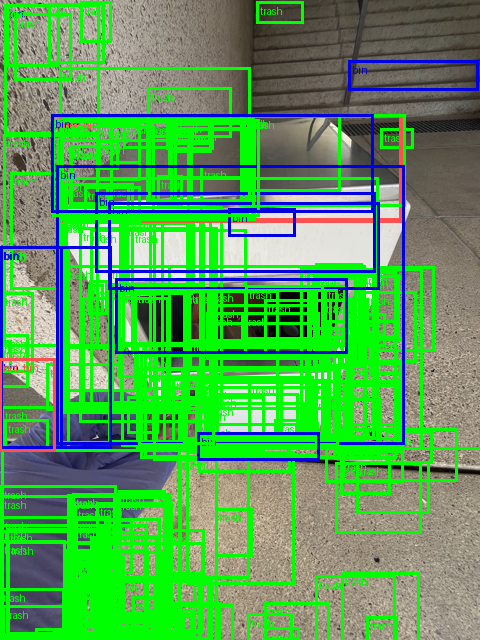

In [56]:
# Get target image and boxes (half them for display purposes in the notebook)
image_to_plot = half_image(random_sample["image"])
boxes_to_plot = half_boxes(random_sample_outputs_post_processed[0]["boxes"])

# Collect the boxes, scores and labels
random_sample_label_names = []
for result in random_sample_outputs_post_processed:
     for score, label_id, box in zip(result["scores"], 
                                     result["labels"], 
                                     result["boxes"]):
         score, label = score.item(), label_id.item()
         box = [round(i, 2) for i in box.tolist()]
         # Optionally print out each prediction 
         # print(f"[INFO] {model.config.id2label[label]}: {score:.2f} {box}")

         random_sample_label_names.append(model.config.id2label[label])

# Get the list of colours to plot
random_sample_colours = [colour_palette[label_name] for label_name in random_sample_label_names]
# print(f"Label names: {random_sample_label_names}")
# print(f"Colour codes: {random_sample_colours}")

# Create the output image with plotted boxes
output_image_with_boxes = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=image_to_plot),
        boxes=boxes_to_plot,
        labels=random_sample_label_names,
        colors=random_sample_colours,
        width=3,
        label_colors=random_sample_colours
    )
)
output_image_with_boxes

Nice! We get some plotted boxes. But they look pretty poor.

This is because our model is currently predicting random outputs based on the new output layers we instantiated.

We'll be working towards making these boxes better later on.

### Reproducing our postprocessed box scores by hand

When a raw prediction output from our model goes through the `post_process_object_detection` method, a few steps happen.

One of them is that the raw logits from our model get converted into prediction probabilities.

This happens by:

1. Applying the [`torch.sigmoid()`](https://pytorch.org/docs/main/generated/torch.sigmoid.html) function to the logits to turn them into prediction probabilities. We'll also flatten them with [`torch.flatten(start_dim=1)`](https://docs.pytorch.org/docs/stable/generated/torch.flatten.html) to turn them into a single dimension tensor (e.g. `torch.Size([1, 300, 7])` -> `torch.Size([1, 2100])`).
2. Getting the top 100 (`post_process_object_detection` returns the top 100 values by default) prediction scores using [`torch.topk()`](https://pytorch.org/docs/main/generated/torch.topk.html).
3. Find the values above the target threshold by creating a mask.
4. Filter the top 100 scores which are above the threshold (using our mask) and sort them in descending order and get the indices with [`torch.sort()`](https://pytorch.org/docs/stable/generated/torch.sort.html) (so the predictions with the highest prediction probability come first).

`torch.topk()` and `torch.sort()` will return both raw tensor values and the indices of where they occur in a tuple `(values, indices)`.

These index values are the predicted label ID.

::: {.callout-note}

When a prediction probability is assigned to a prediction, it usually falls between 0 and 1.

With 1 being the highest possible score.

The value with the highest prediction probability is the value the model is predicting to the be the *most likely* value.

However, just because a prediction has being assigned a high prediction probability does not mean it is correct.

A high prediction probability is essentially the model saying, "based on the training data I have and the patterns I've learned, this is the *most likely* outcome".

A workflow using prediction probabilities could be to automatically send samples with low prediction probabilities for manual review.

For now, our model will likely assign close to random prediction probabilities as it has not been trained on our data.
:::

To see this happen, let's reproduce the `"scores"` key in `random_sample_outputs_post_processed` by hand.

In [ ]:
# Get the output scores from our post processed single output
output_scores = random_sample_outputs_post_processed[0]["scores"]
len(output_scores), output_scores

(96,
 tensor([0.6736, 0.5951, 0.5918, 0.5854, 0.5757, 0.5403, 0.5364, 0.5363, 0.5268,
         0.5200, 0.5069, 0.5045, 0.5005, 0.4951, 0.4890, 0.4884, 0.4857, 0.4854,
         0.4828, 0.4814, 0.4808, 0.4788, 0.4780, 0.4746, 0.4729, 0.4649, 0.4629,
         0.4608, 0.4608, 0.4606, 0.4598, 0.4580, 0.4577, 0.4506, 0.4504, 0.4500,
         0.4498, 0.4478, 0.4476, 0.4469, 0.4465, 0.4448, 0.4432, 0.4431, 0.4418,
         0.4417, 0.4393, 0.4378, 0.4377, 0.4374, 0.4372, 0.4365, 0.4348, 0.4332,
         0.4316, 0.4316, 0.4290, 0.4287, 0.4270, 0.4257, 0.4256, 0.4249, 0.4239,
         0.4238, 0.4232, 0.4229, 0.4227, 0.4226, 0.4224, 0.4202, 0.4192, 0.4178,
         0.4178, 0.4160, 0.4154, 0.4151, 0.4147, 0.4145, 0.4122, 0.4107, 0.4101,
         0.4099, 0.4098, 0.4088, 0.4087, 0.4087, 0.4081, 0.4066, 0.4056, 0.4045,
         0.4041, 0.4037, 0.4016, 0.4015, 0.4013, 0.4003],
        grad_fn=<IndexBackward0>))

And we can reproduce these scores by following the steps outlined above.

In [ ]:
print(f"[INFO] Original input logits shape: {random_sample_outputs.logits.shape}\n") 

# 1. Perform sigmoid on the logits to get prediction probabilities 
output_scores_manual = random_sample_outputs.logits.sigmoid().flatten(start_dim=1)
print(f"[INFO] Manual output scores shape: {output_scores_manual.shape}")
print(f"[INFO] First 10 scores (these will be in random order):\n{output_scores_manual[0][:10].detach().cpu()}\n")

# 2. Get the top 100 scores (we can get any top amount but 100 will do for now) 
output_scores_manual_top_100, output_scores_manual_top_100_indices = torch.topk(input=output_scores_manual,
                                                                                k=100,
                                                                                dim=-1)
print(f"[INFO] Top 100 scores shape: {output_scores_manual_top_100.shape}")
print(f"[INFO] First top 100 score:\n{output_scores_manual_top_100[0][0].item():.4f}\n")

# 3. Find the values above the threshold and create a mask
output_scores_manual_mask = output_scores_manual_top_100 > THRESHOLD

# 4. Sort the top 100 scores which are above the threshold and sort them in descending order and get the indices
output_scores_manual_filtered, output_scores_manual_filtered_indices = torch.sort(input=output_scores_manual_top_100[output_scores_manual_mask], 
                                                                                  descending=True)

print(f"[INFO] Filtered scores shape: {output_scores_manual_filtered.shape}")
print(f"[INFO] First filtered scores:\n{output_scores_manual_filtered[0].detach().cpu():.4f}")

[INFO] Original input logits shape: torch.Size([1, 300, 7])

[INFO] Manual output scores shape: torch.Size([1, 2100])
[INFO] First 10 scores (these will be in random order):
tensor([0.0792, 0.2543, 0.1580, 0.5757, 0.2654, 0.1171, 0.0330, 0.0410, 0.1540,
        0.0951])

[INFO] Top 100 scores shape: torch.Size([1, 100])
[INFO] First top 100 score:
0.6736

[INFO] Filtered scores shape: torch.Size([96])
[INFO] First filtered scores:
0.6736


Now we've got our own `output_scores_manual_filtered`, how about we compare it to `output_scores`? 

We can see if they're close to each other with [`torch.isclose()`](https://pytorch.org/docs/stable/generated/torch.isclose.html).

In [ ]:
# Compare the original output scores to our own manual version
torch.isclose(input=output_scores[:len(output_scores_manual_filtered)], 
              other=output_scores_manual_filtered, 
              atol=1e-2)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True])

Nice!

We managed to reproduce our postprocessed output scores values by hand.

How about the labels?

### Reproducing our postprocessed box labels by hand

We've reproduce our postprocessed model prediction scores by hand.

Now let's do the same with the labels.

First, we'll get the output labels from our postprocessed object.

In [ ]:
# Get the model's predicted labels 
output_labels = random_sample_outputs_post_processed[0]["labels"]
print(f"[INFO] Output labels shape: {len(output_labels)}")
print(f"[INFO] Output labels:\n{output_labels}")

[INFO] Output labels shape: 96
[INFO] Output labels:
tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


Wonderful!

Now to reproduce these values, we can: 

1. Get the number of classes we have using `random_sample_outputs.logits.shape[2]`, this way we can normalize the flattened indices we created in the previous section.
2. Modulo the `output_scores_manual_top_100_indices` by the number of classes to get the predicted labels (e.g. index % num_classes = predicted label -> 747 % 7 =  5).
3. Filter the remaining labels for predictions which pass the threshold using `output_scores_manual_filtered_indices`.

In [ ]:
# 1. Get the number of classes
num_classes = random_sample_outputs.logits.shape[2]
print(f"[INFO] Found total number of classes: {num_classes}")

# 2. Modulo the output_scores_manual_top_100_indices by the number of classes to get the predicted class (this is because we flattened our outputs above with .flatten(1))
output_labels_manual = output_scores_manual_top_100_indices % num_classes

# 3. Find the top labels which pass our score threshold
output_labels_manual_filtered = output_labels_manual[0][output_scores_manual_filtered_indices]

output_labels.shape, output_labels_manual_filtered.shape

[INFO] Found total number of classes: 7


(torch.Size([96]), torch.Size([96]))

Excellent, now let's make sure these labels are equivalent to the postprocessed labels.

In [ ]:
output_labels[:len(output_labels_manual_filtered)] == output_labels_manual_filtered

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True])

Perfect!

How about we repeat the same for our model's postprocessed predicted boxes?

### Reproducing our postprocessed box coordinates by hand

Our postprocessed boxes are in absolute `XYXY` format.

And the raw boxes out of the model are in normalized `CXCYWH` format.

First, let's get the postprocessed predicted boxes we're trying to reproduce.

In [ ]:
# These are in absolute XYXY (x_top_left, y_top_left, x_bottom_right, y_bottom_right) format
output_boxes = random_sample_outputs_post_processed[0]["boxes"]
print(f"[INFO] Output boxes shape: {output_boxes.shape}")
print(f"[INFO] Output boxes (absolute XYXY format), first 10:\n{output_boxes[:10]}")

[INFO] Output boxes shape: torch.Size([96, 4])
[INFO] Output boxes (absolute XYXY format), first 10:
tensor([[ 5.0105e+02,  4.5203e-01,  7.3708e+02,  2.4250e+02],
        [ 5.0412e+02,  2.0059e+00,  7.3278e+02,  1.8306e+02],
        [ 6.1310e+02,  2.3096e+02,  6.6116e+02,  3.0177e+02],
        [ 5.0306e+02,  1.2722e+00,  9.5733e+02,  2.2517e+02],
        [ 2.4945e+01,  3.0436e+02,  5.1925e+01,  3.4591e+02],
        [ 5.1260e+02,  6.8830e-01,  9.4725e+02,  6.6806e+01],
        [ 6.1350e+02,  2.2984e+02,  7.0224e+02,  3.0797e+02],
        [ 2.1152e+01, -3.2943e-01,  9.5351e+02,  1.4764e+02],
        [ 1.2980e+01, -3.1096e+00,  9.5033e+02,  3.1315e+02],
        [ 4.9968e+02,  2.2245e+02,  6.2810e+02,  2.4664e+02]],
       grad_fn=<SliceBackward0>)


Beautiful!

These are the boxes we'd like to reproduce.

Let's now get the raw predicted box coordinates from our model.

In [ ]:
# Get model output raw boxes
# These are in format: normalized CXCYWH (center_x, center_y, width, height) format
output_boxes_manual_cxcywh = random_sample_outputs.pred_boxes[0]
print(f"[INFO] Output boxes manual shape: {output_boxes_manual_cxcywh.shape}")
print(f"[INFO] Output boxes manual (normalized CXCYWH format), first 10:\n{output_boxes_manual_cxcywh[:10]}")

[INFO] Output boxes manual shape: torch.Size([300, 4])
[INFO] Output boxes manual (normalized CXCYWH format), first 10:
tensor([[0.0400, 0.2540, 0.0281, 0.0325],
        [0.9611, 0.0529, 0.0756, 0.0779],
        [0.4853, 0.4791, 0.1735, 0.0516],
        [0.3670, 0.6512, 0.1584, 0.1370],
        [0.4984, 0.6331, 0.4169, 0.1247],
        [0.3549, 0.5278, 0.0505, 0.0488],
        [0.7606, 0.0885, 0.4732, 0.1749],
        [0.3979, 0.6548, 0.0929, 0.0897],
        [0.9758, 0.7925, 0.0431, 0.0480],
        [0.5076, 0.0575, 0.9712, 0.1156]], grad_fn=<SliceBackward0>)


Ok, so we've got 300 boxes here, let's filter these down to only the boxes which have a score above the target `threshold` using our `output_scores_manual_mask` tensor.

If we want to go from raw boxes out of the model to the same format as our postprocessed boxes or from normalized `CXCYWH` to absolute `XYXY`, we'll have to: 

1. Normalize the `output_scores_manual_top_100_indices` by dividing them by the number of classes, for example, `top_100_index // num_classes = top_box_index` -> `763 // 7 = 109`.
2. Filter for the top 100 scoring boxes coordinates which make it over the `threshold` using the `output_scores_manual_mask`.
3. Convert the filtered box coordinates from normalized `CXCYWH` to normalized `XYXY` using [`torchvision.ops.box_convert`](https://pytorch.org/vision/main/generated/torchvision.ops.box_convert.html).
4. Get the original input image size (required for box conversion).
5. Convert the normalized `XYXY` coordinates to absolute `XYXY` coordinates by multiplying the `x` coordinates by the desired width and the `y` coordinates by the desired height. For example, if we want to plot our boxes on the original image, we'd use the original image dimensions of `(1280, 960)` (height, width). 
6. Sort the bounding box coordinates in the same order as the scores (descending).
8. Check for equivalence between original postprocessed boxes and our manually processed boxes

In [ ]:
# 1. Normalize the indices by dividing by the number of classes (this is because we flattened our logits tensor in a previous step) 
output_scores_manual_top_100_indicies_normalized = output_scores_manual_top_100_indices[0] // num_classes
output_scores_manual_top_100_indicies_normalized

tensor([292,  56, 118,   6,   0,  50, 167,   9,  46, 111, 270,  63, 122, 182,
         87, 243,  82, 103, 229, 208, 161, 170,  91, 179, 198, 149, 130, 160,
        197, 259, 260, 254, 183, 195,  52, 136, 172,  69,  25, 285, 216, 156,
        296, 215, 146,  30, 101, 154, 203, 181, 209,  14,  88, 107,  74,  83,
        213, 106,  68,  18, 294, 237, 178, 248, 224, 109,  92,  23, 115, 284,
        258, 175, 277,  62,  65, 212,  24, 247, 235, 249, 124, 255, 272, 273,
        231, 276, 256,  95,  51,  38,  70, 286, 133, 265, 142, 287, 244, 217,
         89, 139])

In [ ]:
# 2. Filter boxes for top 100 above the target threshold
output_boxes_manual_above_threshold_cxcywh = output_boxes_manual_cxcywh[output_scores_manual_top_100_indicies_normalized]

print(f"[INFO] Output boxes manual above threshold shape: {output_boxes_manual_above_threshold_cxcywh.shape}")
print(f"[INFO] Output boxes manual above threshold (normalized CXCYWH format), \
showing first 10:\n{output_boxes_manual_above_threshold_cxcywh[:10, :]}")

[INFO] Output boxes manual above threshold shape: torch.Size([100, 4])
[INFO] Output boxes manual above threshold (normalized CXCYWH format), showing first 10:
tensor([[0.6449, 0.0949, 0.2459, 0.1891],
        [0.6442, 0.0723, 0.2382, 0.1414],
        [0.6637, 0.2081, 0.0501, 0.0553],
        [0.7606, 0.0885, 0.4732, 0.1749],
        [0.0400, 0.2540, 0.0281, 0.0325],
        [0.7603, 0.0264, 0.4528, 0.0517],
        [0.6853, 0.2101, 0.0924, 0.0610],
        [0.5076, 0.0575, 0.9712, 0.1156],
        [0.5017, 0.1211, 0.9764, 0.2471],
        [0.5874, 0.1832, 0.1338, 0.0189]], grad_fn=<SliceBackward0>)


Nice! 

Okay, now let's convert the boxes from normalized `CXCYWH` to normalized `XYXY` format using `torchvision.ops.box_convert`.

In [ ]:
from torchvision.ops import box_convert

# 3. Convert the model's predicted boxes from CXCYWH to XYXY format
output_boxes_manual_above_threshold_xyxy = box_convert(boxes=output_boxes_manual_above_threshold_cxcywh,
                                                       in_fmt="cxcywh",
                                                       out_fmt="xyxy")
print(f"[INFO] Output boxes manual above threshold (absolute XYXY format):\n{output_boxes_manual_above_threshold_xyxy[:10]}")

[INFO] Output boxes manual above threshold (absolute XYXY format):
tensor([[ 5.2193e-01,  3.5315e-04,  7.6779e-01,  1.8945e-01],
        [ 5.2513e-01,  1.5671e-03,  7.6331e-01,  1.4302e-01],
        [ 6.3864e-01,  1.8044e-01,  6.8871e-01,  2.3576e-01],
        [ 5.2402e-01,  9.9394e-04,  9.9722e-01,  1.7591e-01],
        [ 2.5984e-02,  2.3778e-01,  5.4088e-02,  2.7024e-01],
        [ 5.3396e-01,  5.3773e-04,  9.8672e-01,  5.2192e-02],
        [ 6.3906e-01,  1.7956e-01,  7.3150e-01,  2.4060e-01],
        [ 2.2033e-02, -2.5737e-04,  9.9324e-01,  1.1535e-01],
        [ 1.3521e-02, -2.4294e-03,  9.8993e-01,  2.4465e-01],
        [ 5.2050e-01,  1.7379e-01,  6.5427e-01,  1.9268e-01]],
       grad_fn=<SliceBackward0>)


Excellent, we've got our box coordinates in normalized `XYXY` format.

We could keep them here.

But to fully replicate the outputs of our postprocessed boxes, we'll convert them to absolute format.

Absolute format conversion will depend on the target size of image we'd like to use.

For example, if we'd like to convert our boxes to the original dimensions of our input image so we can plot them on that image, we can use the image's original dimensions.

To get the original dimensions of our image we can access the `orig_size` attribute of our preprocessed sample.

In [ ]:
# 4. Get the original input image size (required for box conversion)
random_sample_image_original_size= random_sample_preprocessed["labels"][0]["orig_size"]
print(f"[INFO] Image original size: {random_sample_image_original_size} (height, width)")

[INFO] Image original size: tensor([1280,  960]) (height, width)


Now to convert our normalized coordinates to absolute coordinates we can multiply `x` coordinates by the target width and `y` coordinates by the target height.

In [ ]:
# 5. Convert normalized box coordinates to absolute pixel values

# Get image original height and width
original_height, original_width = random_sample_image_original_size

# Create an XYXY tensor to multiply by
original_dimensions = torch.tensor([original_width,   # x1
                                    original_height,  # y1 
                                    original_width,   # x2
                                    original_height]) # y2

# Convert the boxes to absolute pixel values
output_boxes_manual_above_threshold_xyxy_absolute = output_boxes_manual_above_threshold_xyxy * original_dimensions
output_boxes_manual_above_threshold_xyxy_absolute[:10]

tensor([[ 5.0105e+02,  4.5203e-01,  7.3708e+02,  2.4250e+02],
        [ 5.0412e+02,  2.0059e+00,  7.3278e+02,  1.8306e+02],
        [ 6.1310e+02,  2.3096e+02,  6.6116e+02,  3.0177e+02],
        [ 5.0306e+02,  1.2722e+00,  9.5733e+02,  2.2517e+02],
        [ 2.4945e+01,  3.0436e+02,  5.1925e+01,  3.4591e+02],
        [ 5.1260e+02,  6.8830e-01,  9.4725e+02,  6.6806e+01],
        [ 6.1350e+02,  2.2984e+02,  7.0224e+02,  3.0797e+02],
        [ 2.1152e+01, -3.2943e-01,  9.5351e+02,  1.4764e+02],
        [ 1.2980e+01, -3.1096e+00,  9.5033e+02,  3.1315e+02],
        [ 4.9968e+02,  2.2245e+02,  6.2810e+02,  2.4664e+02]],
       grad_fn=<SliceBackward0>)

Absolute `XYXY` coordinates acquired!

Time to order them in the same order as our descending scores.

In [ ]:
# 6. Order boxes in same order as labels and scores (descending based on score)
output_boxes_manual_sorted = output_boxes_manual_above_threshold_xyxy_absolute[output_scores_manual_filtered_indices]
output_boxes_manual_sorted[:10]

tensor([[ 5.0105e+02,  4.5203e-01,  7.3708e+02,  2.4250e+02],
        [ 5.0412e+02,  2.0059e+00,  7.3278e+02,  1.8306e+02],
        [ 6.1310e+02,  2.3096e+02,  6.6116e+02,  3.0177e+02],
        [ 5.0306e+02,  1.2722e+00,  9.5733e+02,  2.2517e+02],
        [ 2.4945e+01,  3.0436e+02,  5.1925e+01,  3.4591e+02],
        [ 5.1260e+02,  6.8830e-01,  9.4725e+02,  6.6806e+01],
        [ 6.1350e+02,  2.2984e+02,  7.0224e+02,  3.0797e+02],
        [ 2.1152e+01, -3.2943e-01,  9.5351e+02,  1.4764e+02],
        [ 1.2980e+01, -3.1096e+00,  9.5033e+02,  3.1315e+02],
        [ 4.9968e+02,  2.2245e+02,  6.2810e+02,  2.4664e+02]],
       grad_fn=<SliceBackward0>)

Finally, we can check to see if our manually postprocessed boxes are equivalent to original post processed boxes.

Because we have 100 boxes, we'll use [`torch.all()`](https://docs.pytorch.org/docs/stable/generated/torch.all.html) which checks if all elements in an `input` evaluate to `True` to make sure they're all the same.

In [ ]:
# 7. Check for equivalence between original postprocessed boxes and our manually processed boxes
torch.all(input=output_boxes[:100] == output_boxes_manual_sorted)

tensor(True)

Excellent!

We've now successfully converted our model's raw outputs to postprocessed usable outputs.

Taking the time to do steps like this helps us understand the steps taken behind the scenes for in-built postprocessing methods.

Knowing how to do these conversion steps can also help use troubleshoot errors we may come across in the future.

### Plotting our model's first box predictions on an image

We've got some predictions, time to follow the data explorer's motto and *visualize, visualize, visualize!*

To do so we'll:

1. Extract the scores, labels and boxes from our `random_sample_outputs_post_processed`.
2. Create a list of label names to plot by mapping label IDs to class names as well as a list of colours to colour our boxes with in accordance to our `colour_palette`. 
3. Draw boxes on the image with a combination of `torchvision`'s [`pil_to_tensor`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.pil_to_tensor.html), [`draw_bounding_boxes`](https://pytorch.org/vision/main/generated/torchvision.utils.draw_bounding_boxes.html) and [`to_pil_image`](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.to_pil_image.html).

We'll halve the image as well as the box coordinates using `half_image` and `half_boxes` to save space in our notebook (this is not 100% necessary, just for convenience).

[INFO] Labels with scores: ['Pred: not_hand (0.6736)', 'Pred: not_hand (0.5951)', 'Pred: not_hand (0.5918)']...


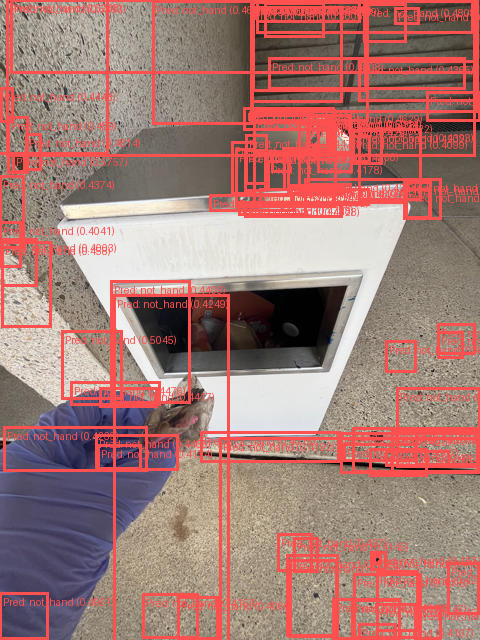

In [ ]:
# 1. Extract scores, labels and boxes
random_sample_pred_scores = random_sample_outputs_post_processed[0]["scores"]
random_sample_pred_labels = random_sample_outputs_post_processed[0]["labels"]
random_sample_pred_boxes = half_boxes(random_sample_outputs_post_processed[0]["boxes"])

# 2. Create a list of labels and colours to plot on the image/boxes
random_sample_pred_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})" 
                  for label_pred, score_pred in zip(random_sample_pred_labels, random_sample_pred_scores)]
random_sample_pred_colours = [colour_palette[id2label[label_pred.item()]] for label_pred in random_sample_pred_labels]

print(f"[INFO] Labels with scores: {random_sample_pred_labels_to_plot[:3]}...")

# 3. Plot the random sample image with randomly predicted boxes 
# (these will be very poor since the model is not trained on our data yet)
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=half_image(random_sample["image"])),
        boxes=random_sample_pred_boxes, # boxes are in XYXY format, which is required for draw_bounding_boxes
        labels=random_sample_pred_labels_to_plot,
        colors=random_sample_pred_colours,
        width=3
    )
)

Woah! Those boxes don't look good at all both the label and the coordinates look off.

This should be expected though... 

While our model has been pretrained on the COCO dataset, it hasn't been trained on our specific data.

The good news is we can hopefully (there are no guarantees in machine learning) improve our model's box predictions by fine-tuning it on our dataset.

## Aside: Bounding box formats in and out of our model

We've done a fair bit of data transformation to get our data ready to go into our model and we've also taken a fair few steps to postprocess it into a usable format.

This is often a standard practice in many machine learning workflows.

Much of the work before ever training a model is preparing the data for the model.

And much of the work after training a model is preparing the data for your use case.

The following table highlights the different states our bounding boxes go in and out of.

| **Step** | **Box format** | **Scale** | **Goes into** |
| ----- | ----- | ----- | ----- |
| Starting data (default downloaded from our Hugging Face dataset, note: not all boxes start in this format) | `XYWH` or `[x1, y1, width, height]` | Absolute | `preprocess()` method |
| Out of [`preprocess()`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.preprocess) | `CXCYWH` or `[center_x, center_y, width, height]` | Normalized | `model.forward()` |
| Out of [`model.forward()`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrForObjectDetection.forward) | `CXCYWH` or `[center_x, center_y, width, height]` | Normalized | `post_process_object_detection()`|
| Out of [`post_process_object_detection()`](https://huggingface.co/docs/transformers/main/en/model_doc/conditional_detr#transformers.ConditionalDetrImageProcessor.post_process_object_detection) | `XYXY` or `[x_top_left, y_top_left, x_bottom_right, y_bottom_right]` | Absolute (in relation to the `target_sizes` parameter). | Plotting or display function. |

<figure style="text-align: center;">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/08-bounding-box-formats.png"
     alt="A diagram illustrating a four-stage object detection pipeline: 'Original Data' shows an image of a hand, trash, and bin with bounding boxes, having 'Format: XYWH' and 'Scale: Absolute'; an arrow points to the '.preprocess()' stage, represented by a green 'RTDetrImageProcessor' block, with 'Format: CXCYWH' and 'Scale: Normalized'; another arrow leads to the '.forward()' stage, depicted by a neural network icon labeled 'RTDetrV2ForObjectDetection', with 'Format: CXCYWH' and 'Scale: Normalized'; a final arrow points to the '.post_process_object_detection()' stage, another green 'RTDetrImageProcessor' block, with 'Format: XYXY' and 'Scale: Absolute'." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Our bounding boxes go through a series of format changes from input to final output. Keeping track of what format our boduning boxes are in is important for both training models and visualizing boxes on images. If we use the wrong format for plotting boxes on images, we may falsely assume our model is performing better or worse than it actually is.</figcaption>
</figure>

Keeping track of these input and output formats is helpful for knowing the state of your data.

But remember, just because our current workflow is like this, doesn't mean all future workflows you work on will have the same transformation steps.

For more on different bounding box formats, see the [bounding box formats guide](https://www.learnml.io/posts/a-guide-to-bounding-box-formats/).

## Preparing data at scale

We've performed preprocessing and postprocessing steps on a single data sample.

However, in practice, we'll likely want to work with many more samples.

Our model is hungry for more data.

So let's step it up a notch and write some code that's capable of preprocessing *many* samples to pass to our model.

We'll break it down into three subsections:

1. **Splitting the data** into training, validation and test sets. We'll train our model on the training set and check its performance on the validation and test sets (our model won't see any of these samples during training). We perform these splits before preprocessing the samples in them in case we'd like to perform different preprocessing steps depending on the split. For example, we may want to use [**data augmentation**](https://pytorch.org/vision/main/transforms.html) on the training set and not use it on the testing set. 
2. **Preprocessing multiple samples at a time** by iterating over groups of samples. Rather than preprocess a single sample at a time, we'll write code capable of processing lists of examples simultaneously.
3. **Collate samples into batches** so our model can view multiple samples simultaneously. Rather than performing a forward pass on a single sample at a time, we'll pass **batches** of data to the model. For example, we may pass 32 samples (image and label pairs) at a time to our model for it to try and learn the patterns between them. We use batches of data rather than the whole dataset as it's often much more memory efficient. If you have a *really* large dataset, all of your samples may not fit into memory at once, so in practice, you break it up into smaller batches of samples.

Let's start by splitting the data into different sets.

### Splitting the data into training and test sets

Right now our data is all in one big group.

However, it's best practice to split our data into two (or three) different sets:

1. **Training set (~70-80% of data)** - This is the data the model will learn from, all samples in this set are seen by the model during training.
2. **Validation set (~5-20% of data)** - This is the data we can fine-tune our model's hyperparameters on, all samples in this set are *not* seen by the model during training.
3. **Test set (~5-20% of data)** - This is the data we will evaluate what our model has learned after going through the training set, all samples in this set are *not* seen by the model during training.

Using the analogy of a student at univeristy, the **training set** would be the course materials throughout the semester, the **validation set** would be the practice exam and the **test set** would be the final exam.

If a student doesn't perform well on the final exam, then we would usually say perhaps the course materials weren't of the highest quality.

This is similar to our machine learning workflow.

In an ideal world, the samples in the training set are sufficiently representative of those in the test set and in turn, sufficiently representative of samples in the wild.

Before we split our dataset into different sets, let's remind ourselves of what it looks like.

In [ ]:
# Original dataset (only a "train" split)
dataset = load_dataset(path="mrdbourke/trashify_manual_labelled_images")
original_dataset_length = len(dataset["train"])
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

Wonderful! Right now, we've only got one split, `"train"`.

To make our required splits, we can call the [`train_test_split()`](https://huggingface.co/docs/datasets/en/package_reference/main_classes#datasets.Dataset.train_test_split) method on our dataset and pass in the size of the split we'd like via the `test_size` parameter.

For example, `test_size=0.3` means 30% of the data will go to the test set and 70% will go to the training set.

We'll make the following splits:

* 70% of data to training set.
* ~10% of data to validation set.
* ~20% of data to testing set.

To do so, we'll call `train_test_split()` twice with different amounts:

1. First on `dataset["train"]` with `test_size=0.3` to make the 70/30 training/test split, we'll save this split to the variable `dataset_split`.
2. Next on `dataset_split["test"]` with `test_size=0.66` to make the 66/33 test/validation split, we'll set this variable to `dataset_test_val_split`.

<figure style="text-align: center;">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/05-dataset-splits.png"
     alt="A diagram illustrating two methods of splitting a dataset, shown as three vertical bars: the leftmost pink bar represents the 'Whole Dataset'; an arrow points to the middle bar, which is split into a blue 'Testing Split (30%)' on top and a pink 'Training Split (70%)' on the bottom; a second arrow points to the rightmost bar, which is divided into a blue 'Testing Split (20%)' at the top, a yellow 'Validation Split (10%)' in the middle, and a pink 'Training Split (70%)' at the bottom." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>An approximate breakdown of the different dataset splits we're going to create. We'll start with the whole dataset and then break it into training and test splits before breaking the subsequent test split into test and validation splits. Our model will train on the training data and be evaluated on the validation and testing data.</figcaption>
</figure>

Once we've done this, we'll reassign all of the splits back to our original `dataset`.

We'll also set `seed=42` for reproducibility.

Let's do it!

In [ ]:
# Note: Be careful of running this cell multiple times, if you do, the dataset size will get smaller. 
# If this happens, just reload the whole `dataset` as above.

# 1. Split the data into "train" and "test" splits
dataset_split = dataset["train"].train_test_split(test_size=0.3, seed=42) # split the dataset into 70/30 train/test

# 2. Split the test split into "test" and "validation" splits
dataset_test_val_split = dataset_split["test"].train_test_split(test_size=0.66, seed=42) # split the test set into 40/60 validation/test

# Create "train" split from 1.
dataset["train"] = dataset_split["train"]

# Create a "validation" and "test" split from 2.
dataset["validation"] = dataset_test_val_split["train"]
dataset["test"] = dataset_test_val_split["test"]

# Ensure splits lengths add to equal original dataset length (otherwise there's a mistmatch somewhere)
assert original_dataset_length == len(dataset["train"]) + len(dataset["validation"]) + len(dataset["test"]), "Total dataset split lengths don't equal original dataset length, is there a mismatch? Perhaps try reloading the original dataset and re-running this cell."

# View the dataset (now with splits)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 115
    })
    test: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 224
    })
})

Perfect!

Now we've got three splits of our dataset to work with.

We'll make sure our model never sees the `validation` and `test` splits during training, so when evaluate it we know that it's only seeing new samples.

### Writing a function for preprocessing multiple samples at a time

We've preprocessed and passed one sample through our model, new let's do the same for multiple samples.

We're going to work towards having a function that can go from a group or batch of samples (images and their annotations) and return them in preprocessed form (via [`transformers.RTDetrImageProcessor.preprocess`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.preprocess)) ready to be used with our model.

Let's first remind ourselves of what a single unprocessed sample looks like.

In [ ]:
# Get one sample from the training dataset 
one_sample = dataset["train"][42]
one_sample

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 663,
 'annotations': {'file_name': ['1d2ea64a-0296-403d-93cd-31e3f116c995.jpeg',
   '1d2ea64a-0296-403d-93cd-31e3f116c995.jpeg'],
  'image_id': [663, 663],
  'category_id': [1, 5],
  'bbox': [[413.29998779296875,
    529.7000122070312,
    343.6000061035156,
    687.0999755859375],
   [435.8999938964844, 463.0, 77.19999694824219, 99.9000015258789]],
  'iscrowd': [0, 0],
  'area': [236087.5625, 7712.27978515625]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

Awesome, we get an `image` in `PIL.Image.Image` form as well as a single dictionary of `annotations`.

How about if we were to inspect a group of three samples?

In [ ]:
# Get three samples from the training set
group_of_samples = dataset["train"][0:3]

# Uncomment for full output (commented for brevity)
# group_of_samples 

<details>

<summary>Output of random_samples</summary>

```
Signature:
{'image': [<PIL.Image.Image image mode=RGB size=960x1280>,
  <PIL.Image.Image image mode=RGB size=960x1280>,
  <PIL.Image.Image image mode=RGB size=960x1280>],
 'image_id': [69, 1027, 1092],
 'annotations': [{'file_name': ['c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg',
    'c56fee61-959c-44b8-ada2-807d2ff45f90.jpeg'],
   'image_id': [69, 69, 69, 69, 69, 69, 69, 69],
   'category_id': [5, 0, 1, 4, 4, 4, 4, 4],
   'bbox': [[360.20001220703125, 528.5, 177.1999969482422, 261.79998779296875],
    [298.29998779296875,
     495.1000061035156,
     381.1000061035156,
     505.70001220703125],
    [81.5999984741211,
     592.0999755859375,
     358.79998779296875,
     316.29998779296875],
    [1.2999999523162842,
     776.7000122070312,
     193.8000030517578,
     211.89999389648438],
    [301.1000061035156, 60.79999923706055, 146.89999389648438, 115.0],
    [501.0, 75.9000015258789, 24.200000762939453, 71.19999694824219],
    [546.4000244140625,
     54.70000076293945,
     130.3000030517578,
     115.0999984741211],
    [862.9000244140625,
     41.099998474121094,
     75.69999694824219,
     80.19999694824219]],
   'iscrowd': [0, 0, 0, 0, 0, 0, 0, 0],
   'area': [46390.9609375,
    192722.265625,
    113488.4375,
    41066.21875,
    16893.5,
    1723.0400390625,
    14997.5302734375,
    6071.14013671875]},
  {'file_name': ['b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg',
    'b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg',
    'b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg',
    'b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg',
    'b664785b-f8b6-4dd2-9ede-d89c07564812.jpeg'],
   'image_id': [1027, 1027, 1027, 1027, 1027],
   'category_id': [5, 4, 1, 0, 0],
   'bbox': [[378.29998779296875, 657.5, 139.8000030517578, 165.10000610351562],
    [463.29998779296875, 754.5, 39.400001525878906, 30.299999237060547],
    [451.20001220703125,
     734.7999877929688,
     109.19999694824219,
     163.8000030517578],
    [140.39999389648438, 400.29998779296875, 460.8999938964844, 491.5],
    [2.299999952316284,
     322.29998779296875,
     201.6999969482422,
     429.20001220703125]],
   'iscrowd': [0, 0, 0, 0, 0],
   'area': [23080.98046875,
    1193.8199462890625,
    17886.9609375,
    226532.34375,
    86569.640625]},
  {'file_name': ['d822c383-f53a-4a2e-b2f2-3eac55c0e515.jpeg',
    'd822c383-f53a-4a2e-b2f2-3eac55c0e515.jpeg',
    'd822c383-f53a-4a2e-b2f2-3eac55c0e515.jpeg',
    'd822c383-f53a-4a2e-b2f2-3eac55c0e515.jpeg'],
   'image_id': [1092, 1092, 1092, 1092],
   'category_id': [2, 5, 1, 0],
   'bbox': [[97.80000305175781, 93.30000305175781, 177.5, 101.5999984741211],
    [342.20001220703125, 572.5999755859375, 350.0, 344.20001220703125],
    [185.1999969482422, 803.0, 304.3999938964844, 371.6000061035156],
    [219.39999389648438, 259.1000061035156, 598.7000122070312, 584.5]],
   'iscrowd': [0, 0, 0, 0],
   'area': [18034.0, 120470.0, 113115.0390625, 349940.15625]}],
 'label_source': ['manual_prodigy_label',
  'manual_prodigy_label',
  'manual_prodigy_label'],
 'image_source': ['manual_taken_photo',
  'manual_taken_photo',
  'manual_taken_photo']}
```

</details>

Okay, now we get a list of `image` objects as well as a list of `annotation` dictionaries and more in the format:

```json
{
    "image": [<PIL.Image.Image>, <PIL.Image.Image>, ...],
    "image_id": [int, int, ...],
    "annotations": [
        {
            "file_name": [str, str, ...],
            "image_id": [int, int, ...],
            "category_id": [int, int, ...],
            "bbox": [[float, float, float, float], ...],
            "iscrowd": [int, int, ...],
            "area": [float, float, ...]
        },
        {...},
        {...}
    ],
    "label_source": [str, str, ...],
    "image_source": [str, str, ...]
}
```

Knowing this structure, we'll want to write a function capable of taking it as input and then preparing it for the `preprocess` method.

::: {.callout-note}

Our data is in this structure (a dictionary of lists, rather than a list of dictionaries) because it is built on Hugging Face Datasets and [Hugging Face Datasets is built on Apache Arrow](https://huggingface.co/docs/datasets/en/about_arrow).

And [Apache Arrow](https://arrow.apache.org/) is column-orientated in nature.

So instead of our dataset being represented as many rows (list of dictionaries), it is represented as many columns (dictionary of lists).

:::

The [`transformers.RTDetrImageProcessor.preprocess`](https://huggingface.co/docs/transformers/en/model_doc/rt_detr#transformers.RTDetrImageProcessorFast.preprocess) method expects a list of images as well as COCO formatted annotations as input. 

So we'll create a function called `preprocess_batch` which will take a list of our raw examples and format them into a list of images and COCO formatted annotations.

To do so we'll: 

1. Take in a list of examples (these will be in the format above), an `image_processor` and optional `transforms` for data augmentation  (we don't need to pass these in for now but it's good to have the option).
2. Create empty lists of `images` and `coco_annotations` we'll fill throughout the rest of the function.
3. Extract the `image`, `image_id` and `annotations_dict` from our list of input examples.
4. Create lists of annotations attributes such as `bbox`, `category_id` and `area` (these are required for our `format_image_annotations_as_coco` function).
5. Optionally perform transforms/augmentations on the image and related boxes (because in object detection if you transform an image, should transform the related boxes as well).
6. Convert the annotations into COCO format using the `format_image_annotations_as_coco` helper function we created earlier.
7. Append the images and COCO formatted annotations to the empty lists created in 2.
8. Pass the list of images and COCO formatted annotations to the `image_processor.preprocess` method to get the preprocessed batch.
9. Return the preprocessed batch.

Let's do it!



In [ ]:
# 1. Take in a list of examples, image processor and optional transforms
def preprocess_batch(examples, 
                     image_processor,
                     transforms=None, # Note: Could optionally add transforms (e.g. data augmentation) here 
                     ):
    """
    Preprocesses a batch of image data with annotations for object detection models.

    This function takes a batch of examples in a custom dataset format, extracts images and
    their corresponding annotations, and converts them into a format suitable for model training
    or inference using the provided image processor.

    Args:
        examples (dict): A dictionary containing the batch data with the following structure:
            - "image" (List[PIL.Image.Image]): List of PIL Image objects
            - "image_id" (List[int]): List of unique image identifiers
            - "annotations" (List[dict]): List of annotation dictionaries, where each contains:
                - "file_name" (List[str]): List of image filenames
                - "image_id" (List[int]): List of image identifiers
                - "category_id" (List[int]): List of object category IDs
                - "bbox" (List[List[float]]): List of bounding boxes as [x, y, width, height]
                - "iscrowd" (List[int]): List of crowd indicators (0 or 1)
                - "area" (List[float]): List of object areas
            - "label_source" (List[str]): List of label sources
            - "image_source" (List[str]): List of image sources

        image_processor: An image processor object to preprocess images for model input.
            For example, can be `transformers.RTDetrDetrImageProcessor`.

        transforms (optional): Image and annotations transforms for data augmentation.
            Defaults to None.

    Returns:
        dict: Preprocessed batch with images and annotations converted to tensors
            in the format required for a `transformers.RTDetrV2ForObjectDetection` model.

    Note:
        The `format_image_annotations_as_coco` function converts the input annotation format to COCO
        format before applying the image_processor. This is required as the image_processor is designed
        to handle COCO format annotations. 
    """
    # 2. Create empty lists to store images and annotations
    images = []
    coco_annotations = [] 

    # 3. Extract the image, image_id and annotations from the examples
    for image, image_id, annotations_dict in zip(examples["image"], 
                                                 examples["image_id"], 
                                                 examples["annotations"]):

        # 4. Create lists of annotation attributes
        bbox_list = annotations_dict["bbox"]
        category_list = annotations_dict["category_id"]
        area_list = annotations_dict["area"]

        ###
        # 5. Note: Could optionally apply a transform/augmentation here.
        # See PyTorch docs for more: https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html
        if transforms:
            # Perform transform on image/boxes
            pass
        ###

        # 6. Format the annotations into COCO format
        coco_format_annotations = format_image_annotations_as_coco(image_id=image_id,
                                                                   categories=category_list,
                                                                   areas=area_list,
                                                                   bboxes=bbox_list)
        
        # 7. Add images/annotations to their respective lists
        images.append(image) # Note: may need to open image if it is an image path rather than PIL.Image
        coco_annotations.append(coco_format_annotations)

    
    # 8. Apply the image processor to lists of images and annotations
    preprocessed_batch = image_processor.preprocess(images=images,
                                                    annotations=coco_annotations,
                                                    return_tensors="pt")

    # 9. Return the preprocessed batch
    return preprocessed_batch

Nice!

Now how about we test it out on our `group_of_samples`?

In [ ]:
preprocessed_samples = preprocess_batch(examples=group_of_samples,
                                        image_processor=image_processor)

preprocessed_samples.keys()

dict_keys(['pixel_mask', 'pixel_values', 'labels'])

Perfect, we get the same `keys()` as with our single sample.

Except this time, we've got multiple samples, let's check the shape. 

In [ ]:
# Check the shape of our preprocessed samples
print(f"[INFO] Shape of preprocessed samples: {preprocessed_samples['pixel_values'].shape} -> [batch_size, colour_channels, height, width]")

[INFO] Shape of preprocessed samples: torch.Size([3, 3, 640, 480]) -> [batch_size, colour_channels, height, width]


Wonderful, our batch of three samples have been preprocessed and are ready for input to our model.

### Applying our preprocessing function to each data split 

We've seen our `preprocess_batch` function in action on a small group of samples.

Now let's apply it to our different data splits.

To do so, we can call the [`datasets.Dataset.with_transform()`](https://huggingface.co/docs/datasets/en/package_reference/main_classes#datasets.Dataset.with_transform) method on our target dataset split and pass it our desired `transform`.

Using `with_transform()` means our transformations will be applied on-the-fly when we call on our split datasets.

Because the `with_transform()` method expects a callable with a single argument (the input examples), we'll turn our `preprocess_batch` into a [Python partial function](https://docs.python.org/3/library/functools.html#functools.partial). 

Doing this will mean we can prefill the `image_processor` and optionally the `transforms` parameter of our `preprocess_batch` function meaning it will only take `examples` as input, this is inline with the `with_transform()` method.

In [ ]:
# Create a partial function for preprocessing
from functools import partial

# Note: Could create separate preprocess functions with different inputs depending on the split 
# (e.g. use data augmentation on training but not on validation/test)
preprocess_batch_partial = partial(preprocess_batch,
                                   image_processor=image_processor,
                                   transforms=None) # could use transforms here if wanted

# Inspect the preprocess_batch_partial function
preprocess_batch_partial

Beautiful, now let's pass the `preprocess_batch_partial` function to the `with_transform()` method on each of our data splits.

In [ ]:
# Create a copy of the original dataset 
# (we don't need to do this, this is just so we can inspect the original dataset later on)
processed_dataset = dataset.copy()

# Apply the preprocessing function to the datasets (the preprocessing will happen on the fly, e.g. when the dataset is called rather than in-place)
processed_dataset["train"] = dataset["train"].with_transform(transform=preprocess_batch_partial)
processed_dataset["validation"] = dataset["validation"].with_transform(transform=preprocess_batch_partial)
processed_dataset["test"] = dataset["test"].with_transform(transform=preprocess_batch_partial)

Now when we get (via `__getitem__`) one of our samples from a `processed_dataset` split, it will be preprocessed on the fly.

In [ ]:
# Get an item from the dataset (in will be preprocessed as we get it)
processed_dataset["train"][42]

{'pixel_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'pixel_values': tensor([[[0.0824, 0.2275, 0.2471,  ..., 0.3255, 0.3059, 0.3804],
          [0.2588, 0.1608, 0.2706,  ..., 0.4000, 0.4588, 0.4667],
          [0.2706, 0.2588, 0.2549,  ..., 0.7059, 0.5686, 0.4431],
          ...,
          [0.4941, 0.3137, 0.2235,  ..., 0.2745, 0.2314, 0.1647],
          [0.4824, 0.5490, 0.2392,  ..., 0.1725, 0.1451, 0.2157],
          [0.3176, 0.5294, 0.3137,  ..., 0.2039, 0.1059, 0.1490]],
 
         [[0.0941, 0.2392, 0.2549,  ..., 0.3176, 0.2941, 0.3765],
          [0.2706, 0.1686, 0.2784,  ..., 0.3922, 0.4471, 0.4588],
          [0.2784, 0.2667, 0.2588,  ..., 0.6980, 0.5569, 0.4353],
          ...,
          [0.4667, 0.2824, 0.1882,  ..., 0.2902, 0.2549, 0.2000],
          [0.4510, 0.5098, 0.2000,  ..., 0.1922, 0.

And the same happens when we get multiple (a batch) samples!

In [ ]:
# Now when we call one or more of our samples, the preprocessing will take place
batch_size_to_get = 32
print(f"[INFO] Shape of preprocessed images: {processed_dataset['train'][:batch_size_to_get]['pixel_values'].shape} -> [batch_size, colour_channels, height, width]")

[INFO] Shape of preprocessed images: torch.Size([32, 3, 640, 480]) -> [batch_size, colour_channels, height, width]


In [ ]:
# We can pass these straight to our model! (note: may take a while if it's on CPU)
# model(processed_dataset["train"][:batch_size_to_get]["pixel_values"]) # uncomment to view output

### Creating a collation function 

We can now preprocess multiple samples at once.

Time to create a collation function which will tell our model trainer how to stack these samples together into batches.

We do this because processing more samples at once (e.g. 16, 32 or 128 samples in a batch) in a batch is generally more efficient than one sample at a time or trying to process all samples at once.

Our collation function will be used for the [`data_collator` parameter](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.data_collator) in our [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer) instance later on.

The input to our data collation function will be the output of `image_processor.preprocess()` (a preprocessed sample).

And the output will be passed as a batch (we'll define the batch size later on) to our model's [`forward()` method](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr#transformers.ConditionalDetrModel.forward).

::: {.callout-note}
What batch size should I use?

You should generally use the batch size which uses the maximum amount of GPU memory you have.

For example, if you have 16GB of GPU memory and a batch size of 32 only uses 8GB of that memory, you should try doubling the batch size to 64.

The ideal batch size for a given dataset/model/hardware is often discovered in an iterative process.
:::

In [ ]:
from typing import List, Dict, Any

def data_collate_function(preprocessed_batch: List[Dict[str, Any]]) -> Dict[str, Any]:
    """Stacks together groups of preprocessed samples into batches for our model.

    Args:
        preprocessed_batch: A list of dictionaries where each dictionary represnets a preprocessed sample.

    Returns:
        collated_data: A dictionary containing the batched data ready in the format our model
            is expecting. The dictionary has the following keys: 
                - "pixel_values": A stacked tensor of preprocessed pixel values.
                - "labels": A list of label dictionaries.
                - "pixel_mask": (Optional) A stacked tensor of pixel masks (this will be present 
                    only if the input contains a "pixel_mask" key.
    """
    # Create an empty dictionary (our model wants a dictionary input) 
    collated_data = {} 

    # Stack together a collection of pixel_values tensors
    collated_data["pixel_values"] = torch.stack([sample["pixel_values"] for sample in preprocessed_batch])

    # Get the labels (these are dictionaries so no need to use torch.stack)
    collated_data["labels"] = [sample["labels"] for sample in preprocessed_batch]

    # If there is a pixel_mask key, return the pixel_mask's as well
    if "pixel_mask" in preprocessed_batch[0]:
        collated_data["pixel_mask"] = torch.stack([sample["pixel_mask"] for sample in preprocessed_batch])

    return collated_data

Excellent! Now let's try out our data collation function.

In [ ]:
%%time

# Try data_collate_function 
example_collated_data_batch = data_collate_function(processed_dataset["train"].select(range(32)))
example_collated_data_batch.keys()

CPU times: user 9.67 s, sys: 319 ms, total: 9.99 s
Wall time: 865 ms


dict_keys(['pixel_values', 'labels', 'pixel_mask'])

Perfect! Looks like it worked. We've now got a batch of preprocessed images and label pairs.

Let's check the shapes.

In [ ]:
# Check shapes of batched preprocessed samples
print(f"[INFO] Batch of pixel value shapes: {example_collated_data_batch['pixel_values'].shape}")
print(f"[INFO] Batch of labels: {example_collated_data_batch['labels']}")
if "pixel_mask" in example_collated_data_batch:
    print(f"[INFO] Batch of pixel masks: {example_collated_data_batch['pixel_mask'].shape}")

[INFO] Batch of pixel value shapes: torch.Size([32, 3, 640, 480])
[INFO] Batch of labels: [{'size': tensor([640, 480]), 'image_id': tensor([69]), 'class_labels': tensor([5, 0, 1, 4, 4, 4, 4, 4]), 'boxes': tensor([[0.4675, 0.5152, 0.1846, 0.2045],
        [0.5092, 0.5843, 0.3970, 0.3951],
        [0.2719, 0.5861, 0.3738, 0.2471],
        [0.1023, 0.6896, 0.2019, 0.1655],
        [0.3902, 0.0924, 0.1530, 0.0898],
        [0.5345, 0.0871, 0.0252, 0.0556],
        [0.6370, 0.0877, 0.1357, 0.0899],
        [0.9383, 0.0634, 0.0789, 0.0627]]), 'area': tensor([11597.7402, 48180.5664, 28372.1094, 10266.5547,  4223.3750,   430.7600,
         3749.3826,  1517.7850]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]), 'orig_size': tensor([1280,  960])}, {'size': tensor([640, 480]), 'image_id': tensor([1027]), 'class_labels': tensor([5, 4, 1, 0, 0]), 'boxes': tensor([[0.4669, 0.5782, 0.1456, 0.1290],
        [0.5031, 0.6013, 0.0410, 0.0237],
        [0.5269, 0.6380, 0.1138, 0.1280],
        [0.3863, 0.50

Now let's try to pass the `"pixel_values"` through our model.

In [ ]:
%%time 

# Try pass a batch through our model (note: this will be relatively slow if our model is on the CPU)
model = create_model()

# example_batch_outputs = model(example_collated_data_batch["pixel_values"])
example_batch_outputs = model(example_collated_data_batch["pixel_values"])
# example_batch_outputs # uncomment for full output
example_batch_outputs.keys()

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

CPU times: user 1min 44s, sys: 1min 7s, total: 2min 52s
Wall time: 14.2 s


odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'intermediate_hidden_states', 'intermediate_logits', 'intermediate_reference_points', 'encoder_last_hidden_state', 'init_reference_points', 'enc_topk_logits', 'enc_topk_bboxes', 'enc_outputs_class', 'enc_outputs_coord_logits'])

In [ ]:
# We get 300 predictions per image in our batch, each with a logit value for each of the classes in our dataset 
example_batch_outputs.logits.shape

torch.Size([32, 300, 7])

This is what will happen during training, our model will continually go over batches (the size of these batches will be defined by us) over data and try to match its own predictions with the ground truth labels. 

In summary, we've created two major steps:

1. `preprocess_batch` - Preprocesses single or groups of samples into the specific format required by our model.
2. `data_collate_function` - Stacks together groups/batches of samples to be passed to our model's `forward()` method.

## Setting up TrainingArguments and a Trainer instance to train our model

Data ready and prepared, time to train a model!

We'll use [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments) to set various hyperparameters for our model (many of these will be set by default, however, we can tweak them to our liking).

We'll also create an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer) which we can pass our preprocessed datasets for it to train/evaluate on. 

To train a model, we'll go through the following steps:

1. Create a fresh instance of our model using the `create_model()` function.
2. Make a directory for saving our trained models to.
3. Define our model's hyperparameters using `transformers.TrainingArguments`, we'll take many of these settings from the assosciated research papers that introduced our model.
4. Optional: Create a custom instance of `transformers.Trainer` to use a custom optimizer with different learning rates for different parameters (similar to the research papers).
5. Create an evaluation function we can pass to our `transformers.Trainer` instance as the `compute_metrics` parameter to evaluate our model. 
6. Create an instance of `transformers.Trainer` and pass it our training arguments from 2 as well as our preprocessed data.
7. Call [`transformers.Trainer.train()`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.train) to train the model from 1 on our own data.
8. Plot our model's loss curves to see how it performed throughout training (ideally our model's loss goes down and its evaluation metric goes up).

Let's do it!

In [ ]:
# 1. Create a model instance 
model = create_model()

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

Model ready, let's now create a folder where we can save our trained models to.

In [ ]:
from pathlib import Path

# 2. Make a models directory for saving models
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

Perfect! Time to setup our model's hyperparameters with `transformers.TrainingArguments`.

### Setting up our TrainingArguments 

The `transformers.TrainingArguments` class holds many of the hyperparameters/settings for training our model.

Many of them are set by default in the [`transformers.RTDetrV2Config`](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2Config) class.

However, we can tweak any of them to our own liking.

Where do we get the settings from?

The original [*RT-DETRv2: Improved Baseline with Bag-of-Freebies for Real-Time Detection Transformer*](https://arxiv.org/abs/2407.17140) paper states that all hyperparameters are the same as the original RT-DETR (see Table A in [*DETRs Beat YOLOs on Real-time Object Detection*](https://arxiv.org/abs/2304.08069)).

The main hyperparameters we are going to set are:

| **Hyperparameter** | **Value** | **What does it do?** | 
| ----- | ----- | ----- |
| `per_device_train_batch_size`, `per_device_eval_batch_size` | `16`, `32` or larger (hardware dependent) | Defines the number of samples passed to our model at one time. For example, if batch size is 16, our model will see 16 samples at a time. It's usually best practice to set this value to the highest your hardware can handle. | 
| `learning_rate` | `0.0001` (as per the listed papers) | Defines the multiplier on the size of gradient updates during training. Too high and gradients will explode, too low and gradients won't update, both lead to poor training results. The papers mention two different learning rates for the backbone and the detection head, I tried these and got poor results (likely because of our smaller dataset), a single learning rate for the whole network turned out to be better. | 
| `weight_decay` | `0.0001` (as per the listed papers) | Prevents model weights from getting too large by applying a small decay penalty over time. This prevents a single weight providing too much information. In essence, the model is forced to learn smaller, simpler weights to represent the data. A form of regularization (overfitting prevention). See more at [paperswithcode.com/method/weight-decay](https://paperswithcode.com/method/weight-decay). |
| `max_grad_norm` | `0.1` (as per the listed papers) | Prevents gradients from getting too large during training. This will help to ensure stable training. See more at [paperswithcode.com/method/gradient-clipping](https://paperswithcode.com/method/gradient-clipping). | 
| `num_train_epochs` | `10` (depends on training data and available time) | Defines how many laps of the data your model will do. For example, setting epochs to 25 means the model will do 25 laps of the training data to learn different patterns. In practice, I've found this value to be a good starting point for our dataset and also because we are fine-tuning rather than training from scratch. However, if you had more data you might want to do more epochs (when training from scratch, the papers did 300 epochs). |
| `warmup_ratio` | `0.05` | Percentage of total training steps to take learning rate from `0` to to the set value (e.g. `0.0001`). Can help with training stability in the early training steps of the model by not doing too large updates when first starting out. The papers state `2000` warmup steps, however, in practice I found this to be too many for our smaller dataset. |
| `dataloader_num_workers` | `4` (hardware dependent) | Number of workers to load data from the CPU to the GPU. Higher is generally better if it is available, however, it can often cap out. Experimentally I've found that `0.5 * os.cpu_count()` generally works well. |

<figure style="text-align: center;">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/07-hyperparameters-for-models.png"
     alt="An image displaying training hyperparameters for RT-DETR, with 'Table A. Main hyperparameters of RT-DETR.' on the left, listing items like 'optimizer' (AdamW), 'base learning rate' (1e-4), 'learning rate of backbone' (1e-5), and various cost and loss weights; on the right, section 'A.4 Training hyperparameters' describes the training process, mentioning the use of 'AdamW', 'gradient clipping', an 'ImageNet pretrained backbone ResNet-50 imported from Torchvision', fine-tuning the backbone with a learning rate of '10^-5', and training the transformer with a learning rate of '10^-4', with key phrases like 'gradient clipping', 'ResNet-50 is imported from Torchvision', 'fine-tune the backbone using learning rate of 10^-5', and 'train the transformer with a learning rate of 10^-4' underlined in green." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Different hyperparameter settings from the official papers for the <a href="https://arxiv.org/pdf/2304.08069">RT-DETR model</a> (left) and the original <a href="https://arxiv.org/pdf/2005.12872">DETR model</a> (right).</figcaption>
</figure>

It's important to note that all of these values can be experimented with.

And just because a research paper mentions a specific value, doesn't mean you have to use.

For example, all the mentioned research papers tend to focus on training a model from scratch on the COCO dataset (330k images, 80 classes).

Which is a much larger dataset with more classes than our dataset (1k images, 7 classes) which we are trying to fine-tune an existing model on rather than train from scratch.

There are many more possible arguments/settings we've left out in the above table but if you'd like to explore these, I'd encourage you to check out the documentation for [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments).


In [ ]:
# 3. Create an instance of TrainingArguments to pass to Trainer
from transformers import TrainingArguments

# Hardware dependent hyperparameters
# Set the batch size according to the memory you have available on your GPU
# e.g. on my NVIDIA RTX 4090 with 24GB of VRAM, I can use a batch size of 32 
# without running out of memory
BATCH_SIZE = 16
DATALOADER_NUM_WORKERS = 4 # note: if you're on Google Colab, you may have to lower this to os.cpu_count() or to 0 

# Set number of epochs to how many laps you'd like to do over the data
NUM_EPOCHS = 10

# Setup hyperameters for training from the DETR paper(s)
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
MAX_GRAD_NORM = 0.1 
WARMUP_RATIO = 0.05 # learning rate warmup from 0 to learning_rate as a ratio of total steps (e.g. 0.05 = 5% of total steps)

# Create directory to save models to 
OUTPUT_DIR = Path(models_dir, "rt_detrv2_finetuned_trashify_box_detector_v1")
print(f"[INFO] Saving model to: {OUTPUT_DIR}")

# Create TrainingArguments to pass to Trainer
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    max_grad_norm=MAX_GRAD_NORM,
    num_train_epochs=NUM_EPOCHS,
    lr_scheduler_type="linear",
    warmup_ratio=WARMUP_RATIO, 
    # warmup_steps=2000, # number of warmup steps from 0 to learning_rate (overrides warmup_ratio, found this to be too long for our dataset)
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    fp16=True, # use mixed precision training
    dataloader_num_workers=DATALOADER_NUM_WORKERS, # note: if you're on Google Colab, you may have to lower this to os.cpu_count() or to 0
    eval_strategy="epoch",
    load_best_model_at_end=True, 
    metric_for_best_model="eval_loss",
    greater_is_better=False, # want to minimize eval_loss (e.g. lower is better)
    report_to="none", # don't save experiments to a third party service
    push_to_hub=False,
    eval_do_concat_batches=False, # this defaults to True but we'll set it to False for our evaluation function
    # save_safetensors=False # turn this off to prevent potential checkpoint issues
)

[INFO] Saving model to: models/rt_detrv2_finetuned_trashify_box_detector_v1


### Optional: Setting up an optimizer for multiple learning rates

In the papers that mentioned the DETR model we're using (see Table 1 in the [RT-DETRv2 paper](https://arxiv.org/abs/2407.17140)), they state that they used a different learning rate value for the backbone (`learning_rate=1e-5`) as well as the object detection head (`learning_rate=1e-4`).

<figure style="text-align: center;">
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/06-table-1-rt-detrv2-paper.png"
     alt="A table, titled 'Table 1: The hyperparameters of RT-DETRv2,' lists four model variants: 'RT-DETRv2-S,' 'RT-DETRv2-M,' 'RT-DETRv2-L,' and 'RT-DETRv2-X,' along with their respective 'Backbone' architectures ('ResNet18,' 'ResNet34,' 'ResNet50,' and 'ResNet101'), and their learning rates for the backbone ('lr_backbone': '1e-4,' '5e-5,' '1e-5,' '1e-6') and the detector head ('lr_det': all '1e-4')" 
     style="width: 100%; max-width: 600px; height: auto;"/>
     <figcaption>Different learning rates used for different sections of the model from the <a href="https://arxiv.org/pdf/2407.17140">RT-DETRv2 paper</a>. The backbone uses a slightly lower learning rate than the detection head.</figcaption>
</figure>

To set this up ourselves, we can extract which parameters of our model belong to the `backbone` as well as which don't.

To find the backbone parameters, we can loop through our model's `named_parameters()` method and filter for any which contain the string `"backbone"` in their name.

We'll append these to a list called `backbone_parameters` and assume any that don't have `"backbone"` in their name are not part of the model's backbone.

We can use these two lists of parameters to pass to [`torch.optim.AdamW`](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) with different learning rate values for each.

::: {.callout-note}
In my experiments with our smaller dataset size (~1100 images), I found that setting two different learning rates for the backbone and the object detection head led to poorer performance than just setting a single learning rate for the whole model.

The code below is an example of how to create a custom optimizer with different learning rates for different parts of the model.

However, in our actual training code, we'll use a single learning rate for the whole model.
:::

We can then subclass [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer) and update the method [`create_optimizer()`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.create_optimizer) to use our custom optimizer.

In [ ]:
from transformers import Trainer

# Create lists for different kinds of parameters
backbone_parameters = []
other_parameters = []

# Can loop through model parameters and extract different model sections
for name, param in model.model.named_parameters(): 
    if "backbone" in name:
        # print(f"Backbone parameter: {name}")
        backbone_parameters.append(param)
    else:
        # print(f"Other parameter: {name}")
        other_parameters.append(param)

print(f"[INFO] Number of backbone parameter modules: {len(backbone_parameters)}")
print(f"[INFO] Number of other parameter modules: {len(other_parameters)}")

# Setup a custom subclass of Trainer to use different learning rates for different parts of the model
class CustomTrainer(Trainer):
    def create_optimizer(self):
        self.optimizer = torch.optim.AdamW([
            {"params": backbone_parameters, "lr": 1e-4},
            {"params": other_parameters, "lr": 1e-4}
        ], weight_decay=0.0001)
        return self.optimizer

[INFO] Number of backbone parameter modules: 55
[INFO] Number of other parameter modules: 363


Awesome!

Now if we wanted to use our custom optimizer, we could use `CustomTrainer` instead of `Trainer`. 

### Creating an evaluation function

Evaluating a model's performance is just as important as training a model.

After all, if you don't know how well your model is performing, how can you be confident in deploying it or using it in the real world?

In this section, let's create an evaluation function we can pass to `transformers.Trainer`'s [`compute_metrics` parameter](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.compute_metrics).

The main goal of an evaluation function is to compare the model's predictions to the ground truth labels.

For example, how does a model's box predictions look like compared to the ground truth box predictions?

Once we've got a trained model, we can inspect these visually by plotting them on images.

However, during model training, we'll get our `Trainer` instance to output evaluation metrics so we can get a snapshot of performance along the way.

Some things to note about the evaluation function we'll create:

* Reading the documentation for the [`compute_metrics` parameter](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.compute_metrics), we can see our evaluation function will be required to take a [`transformers.EvalPrediction`](https://huggingface.co/docs/transformers/en/internal/trainer_utils#transformers.EvalPrediction) as input.   
    * This contains our model's predictions and labels as `predictions` and `label_ids` attributes respectively.
* We must also return a dictionary with string to metric values for it to be displayed during training. For example, `{"metric_value": 42, ...}`.
* To evaluate our object detection model we're going to use the mAP metric (Mean Average Precision, a standard metric used amongst object detection models, see the [COCO evaluation section](https://cocodataset.org/#detection-eval) for more details). To do so, we'll use [`torchmetrics` package](https://lightning.ai/docs/torchmetrics/stable/), specifically [`torchmetrics.detection.mean_ap.MeanAveragePrecision`](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html).
    * This method expects boxes in format XYXY absolute format by default.
* Our evaluation function will be an adaptation of the code example in the object detection example [on the Hugging Face GitHub](https://github.com/huggingface/transformers/blob/336dc69d63d56f232a183a3e7f52790429b871ef/examples/pytorch/object-detection/run_object_detection.py#L160).
* For an in-depth overview on object detection metrics, see the [Roboflow Guide to Object Detection Metrics](https://blog.roboflow.com/object-detection-metrics/).

Phew! A fair bit to take in. 

But nothing we can't handle.

Let's create our function.

We'll start by making a small helper function to convert bounding boxes from CXCYWH normalized format to XYXY absolute format.

In [ ]:
def convert_bbox_cxcywh_to_xyxy_absolute(boxes, 
                                         image_size_target):
    """
    Converts CXCYWH normalized boxes to XYXY absolute boxes.

    The output of our preprocess method puts boxes in CXCYWH format.

    But our evaluation metric torchmetrics.detection.mean_ap.MeanAveragePrecision expects
        boxes in XYXY absolute format.

    Args:
        boxes (torch.Tensor): A tensor of shape (N, 4) where N is the number of boxes and each box is in CXCYWH format.
        image_size_target (tuple): A tuple containing the target image size as (height, width).
    
    Returns:
        torch.Tensor: A tensor of shape (N, 4) where each box is converted to XYXY absolute format.
    """
    # Convert normalized CXCYWH (output of model) -> absolute XYXY format (required for evaluation)
    boxes = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy")

    # Convert normalized box coordinates to absolute pixel values based on the target size 
    image_size_target_height = image_size_target[0]
    image_size_target_width = image_size_target[1]
    boxes = boxes * torch.tensor([image_size_target_width, 
                                  image_size_target_height, 
                                  image_size_target_width, 
                                  image_size_target_height]) # Multiply X coordinates by the width and Y coordinates by the height

    return boxes

Perfect!

Time to craft our `compute_metrics` function.

The main goal of the function will be to take a `transformers.EvalPrediction` output from our model and return a dictionary mapping metric names to values, for example, `{"metric_name": 42.0 ...}`.

To do so, we'll go through the following steps:

1. Create a Python `dataclass` to hold our model's outputs. We could use a dictionary but this will give our code a bit more structure.
2. Create a `compute_metrics` function which takes in an [`EvalPrediction`](https://huggingface.co/docs/transformers/en/internal/trainer_utils#transformers.EvalPrediction) object as well as other required evaluation parameters such as `image_processor` (for post processing boxes), `id2label` (for mapping metrics to class names) and `threshold` (for assigning a prediction probability threshold to boxes).
3. Extract predictions and targets from `EvalPrediction` via `EvalPrediction.predictions` and `EvalPrediction.label_ids` respectively.
4. Create empty lists of `image_sizes` (for post processing boxes), `post_processed_predictions` and `post_processed_targets` (we'll compare the latter two to each other).
5. Collect target samples in format required for [`torchmetrics.detection.mean_ap.MeanAveragePrecision`](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html), for example, `[{"boxes": [...], "labels": [...]}]`.
6. Collect predictions in the required formart for `MeanAveragePrecision`, our model produces boxes in CXCYWH format, then we use `image_processor.post_process_object_detection` to convert the predictions to XYXY format, and append them to `post_processed_predictions` in form `[{"boxes": [...], "labels": [...], "scores": [...]}]`.
7. Initialize an instance of `torchmetrics.detection.mean_ap.MeanAveragePrecision` (see documentation for output of `MeanAveragePrecision`) and pass it predictions and labels to compute on. 
8. Extract lists of target metrics from the output of `MeanAveragePrecision`, for example, with `metrics.pop("target_item")`.
9. Prepare metrics for output in the form of a dict with metric names -> values, for example, `{"metric_name": 42.0, ...}`.
10. Round metric values in output dictionary for visual display during training.
11. Create a partial function we can pass to `transformers.Trainer`'s `compute_metrics` parameter to run as a callable with appropriate parameter inputs to our `compute_metrics` function.

Easy.

We've got this.

In [ ]:
# Create an evaluation function to test our model's performance
import numpy as np

from typing import Optional, Mapping

from transformers import EvalPrediction

from torchvision.ops import box_convert

from torchmetrics.detection.mean_ap import MeanAveragePrecision

# 1. Create a dataclass to hold our model's outputs
@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor

# 2. Create a compute_metrics function which takes in EvalPrediction and other required parameters
@torch.no_grad()
def compute_metrics(
    evaluation_results: EvalPrediction, # these come out of the Trainer.evaluate method, see: https://huggingface.co/docs/transformers/en/internal/trainer_utils#transformers.EvalPrediction 
    image_processor: AutoImageProcessor,
    threshold: float = 0.0,
    id2label: Optional[Mapping[int, str]] = None,
) -> Mapping[str, float]:
    """
    Compute mean average mAP, mAR and their variants for the object detection task.

    Args:
        evaluation_results (EvalPrediction): Predictions and targets from evaluation.
        threshold (float, optional): Threshold to filter predicted boxes by confidence. Defaults to 0.0.
        id2label (Optional[dict], optional): Mapping from class id to class name. Defaults to None.

    Returns:
        Mapping[str, float]: Metrics in a form of dictionary {<metric_name>: <metric_value>}
    """

    # 3. Extract predictions and targets from EvalPrediction
    predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

    # For metric computation we need to provide to MeanAveragePrecision
    #  - 'targets' in a form of list of dictionaries with keys "boxes", "labels"
    #  - 'predictions' in a form of list of dictionaries with keys "boxes", "scores", "labels"

    # 4. Get a list of image sizes, processed targets and processed predictions
    image_sizes = []
    post_processed_targets = []
    post_processed_predictions = []

    ### Target collection ###

    # 5. Collect target attributes in the required format for metric computation
    for batch in targets:
        # Collect ground truth image sizes, we will need them for predictions post processing
        batch_image_sizes = torch.tensor(np.array([x["orig_size"] for x in batch])) # turn into a list of numpy arrays first, then tensors
        image_sizes.append(batch_image_sizes)

        # Collect targets in the required format for metric computation
        # boxes were converted to YOLO format needed for model training
        # here we will convert them to Pascal VOC format (x_min, y_min, x_max, y_max) 
        # or XYXY format. We do this because the boxes out of preprocess() are in 
        # CXCYWH normalized format.
        for image_target in batch:

            # Get boxes and convert from CXCYWH to XYXY
            boxes = torch.tensor(image_target["boxes"])
            boxes = convert_bbox_cxcywh_to_xyxy_absolute(boxes=boxes, 
                                                         image_size_target=image_target["orig_size"])
            
            # Get labels
            labels = torch.tensor(image_target["class_labels"])

            # Append box and label pairs in format requried for MeanAveragePrecision class
            post_processed_targets.append({"boxes": boxes, 
                                           "labels": labels})
    
    ### Prediction collection ###

    # 6. Collect predictions in the required format for metric computation,
    # model produce boxes in YOLO format (CXCYWH), then image_processor.post_process_object_detection to 
    # convert them to Pascal VOC format (XYXY).
    for batch, target_sizes in zip(predictions, image_sizes):
        batch_logits, batch_boxes = batch[1], batch[2]
        output = ModelOutput(logits=torch.tensor(batch_logits), 
                             pred_boxes=torch.tensor(batch_boxes))
        
        # Post process the model outputs
        post_processed_output = image_processor.post_process_object_detection(
                                                    outputs=output, 
                                                    threshold=threshold, 
                                                    target_sizes=target_sizes) # target sizes required to shape boxes in correct ratio of original image
        
        # Append post_processed_output in form `[{"boxes": [...], "labels": [...], "scores": [...]}]`
        post_processed_predictions.extend(post_processed_output)

    # 7. Compute mAP
    max_detection_thresholds = [1, 10, 100] # 1 = mar@1, mar@10, mar@100 (100 = default max total boxes for post processed predictions out of object detection model)
    metric = MeanAveragePrecision(box_format="xyxy", 
                                  class_metrics=True,
                                  max_detection_thresholds=max_detection_thresholds) 
    metric.warn_on_many_detections = False # don't output a warning when large amount of detections come out (the sorting handles this anyway)
    metric.update(post_processed_predictions, 
                  post_processed_targets)
    metrics = metric.compute()
    
    # Optional: print metrics dict for troubleshooting
    # print(metrics)

    # 8. Extract list of per class metrics with separate metric for each class
    classes = metrics.pop("classes")
    map_per_class = metrics.pop("map_per_class")

    # Optional: mAR@N per class (mAR = Mean Average Recall)
    mar_per_class = metrics.pop("mar_100_per_class")
    
    # 9. Prepare metrics per class in the form of a dict with metric names -> values, e.g. {"metric_name": 42.0, ...}
    # for class_id, class_map in zip(classes, map_per_class):
    for class_id, class_map, class_mar in zip(classes, map_per_class, mar_per_class):
        class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
        metrics[f"map_{class_name}"] = class_map

        # Optional: mAR@100 per class
        metrics[f"mar_100_{class_name}"] = class_mar
    
    # 10. Round metrics for suitable visual output
    metrics = {k: round(v.item(), 4) for k, v in metrics.items()}
    
    # Optional: print metrics dict for troubleshooting
    # print(metrics)

    return metrics

# 11. Create a partial function for our compute_metrics function (we'll pass this to compute_metrics in Trainer)
eval_compute_metrics_fn = partial(
        compute_metrics, 
        image_processor=image_processor, 
        threshold=0.0,
        id2label=id2label, 
)

### Training our model with Trainer

We've now got all the ingredients needed to train our model!

The good news is since we've put so much effort into preparing our dataset, creating an evaluation function and setting up our training arguments, we can train our model in a few lines of code.

To train our model, we'll set up an instance of [`transformers.Trainer`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer) and then we'll pass it the following arguments:

* `model` - The `model` we'd like to train. In our case it will be the fresh insteand of `model` we created using our `create_model()` function.
* `args` - An instance of [`transformers.TrainingArguments`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments) (or `training_args` in our case) containing various hyperparameter settings to use for our model.
* `data_collator` - The function to use which will turn a list of samples from `train_dataset` into a batch of samples.
* `train_dataset` - The dataset we'd like our model to train on, in our case this will be `processed_dataset["train"]`, the dataset we've already preprocessed.
* `eval_dataset` - The dataset we'd like our model to be evaluated on, in our case this will be `processed_dataset["validation"]`, our model will never see these samples during training, it will only test itself on these.
* `compute_metrics` - A `Callable` which takes in [`EvalPrediction`] and is able to return a string to metric (`{"metric_name": value}`) dictionary, these will displayed during training.

After we've done all that, we can start to train our model with by calling [`transformers.Trainer.train()`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.train).

In [ ]:
# Note: Depending on the size/speed of your GPU, this may take a while
from transformers import Trainer

# 5. Setup instance of Trainer
model_v1_trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collate_function,
    train_dataset=processed_dataset["train"], # pass in the already preprocessed data
    eval_dataset=processed_dataset["validation"],
    compute_metrics=eval_compute_metrics_fn,
)

# 6. Train the model 
model_v1_results = model_v1_trainer.train(
    # resume_from_checkpoint=False # you can continue training a model here by passing in the path to a previous checkpoint
) 

There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

### Plotting our model's loss curves

Looking at the metrics output by our model's training process, we can see the loss values going down on the training and evaluation datasets.

As well as the mAP going up almost universally across the board.

Let's make things visual by inspecting the loss curves and evaluation metric curves of our model.

We can extract our model's training history values via the `model_v1_trainer.state.log_history` attribute, this will return us a list of dictionaries containing training metrics related to each epoch.

Once we've got these, we can create lists of relevant values based on their keys and then plot them with `matplotlib`. 

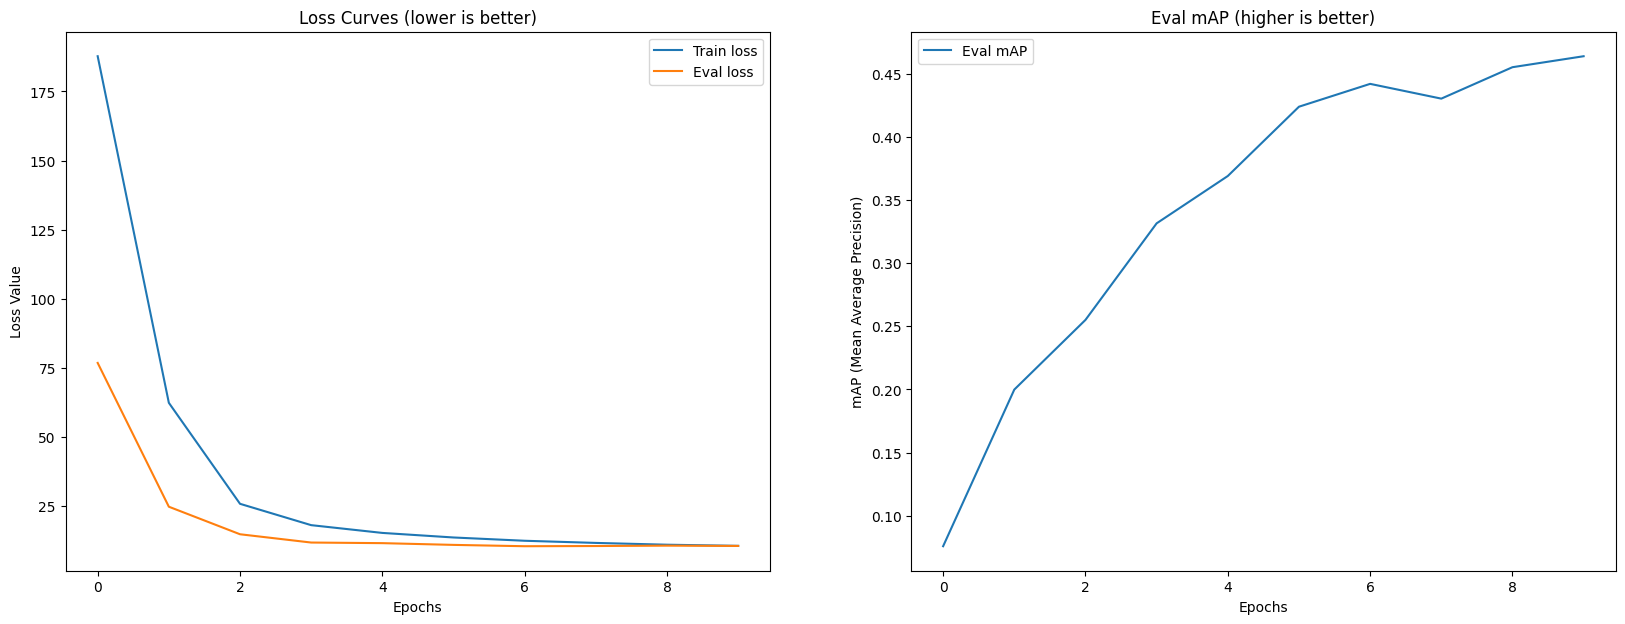

In [ ]:
# 7. Plotting our model's loss curves
import matplotlib.pyplot as plt

log_history = model_v1_trainer.state.log_history

# Exctract loss values
train_loss = [item["loss"] for item in log_history if "loss" in item]
eval_loss = [item["eval_loss"] for item in log_history if "eval_loss" in item]

# Extract mAP values
eval_map = [item["eval_map"] for item in log_history if "eval_map" in item]

# Plot loss curves and mAP
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))
ax[0].plot(train_loss, label="Train loss")
ax[0].plot(eval_loss, label="Eval loss")
ax[0].set_title("Loss Curves (lower is better)")
ax[0].set_ylabel("Loss Value")
ax[0].set_xlabel("Epochs")
ax[0].legend()

ax[1].plot(eval_map, label="Eval mAP")
ax[1].set_title("Eval mAP (higher is better)")
ax[1].set_ylabel("mAP (Mean Average Precision)")
ax[1].set_xlabel("Epochs")
ax[1].legend();


Beautiful!

Those are the exact kind of performance curves we're looking for.

In an ideal world, the loss curves trend downwards and the mAP (Mean Average Percision) curves trend upwards.

We've only trained for 10 epochs here (10 laps of the data), perhaps our metrics would be even better if we were to train for longer?

I'll leave this as an extension for you to try.

## Making predictions on the test dataset 

We've trained a model on our training data (`processed_dataset["train"]`) and considering the metrics on the validation data (`processed_dataset["validation"]`) it looks like it's performing well.

However, there's nothing quite like performing predictions on *unseen* test data and seeing how they go.

We can make predictions using our trained model by passing it samples formatted in the same way it was trained on.

Good news is, we've already got preprocessed test samples (our model has never seen these) in `processed_dataset["test"]`.

Let's start by inspecting a single processed test sample and then we'll make predictions on the whole test dataset.

In [ ]:
# Our dataset is broken into "train", "validation", "test"
processed_dataset

{'train': Dataset({
     features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
     num_rows: 789
 }),
 'validation': Dataset({
     features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
     num_rows: 115
 }),
 'test': Dataset({
     features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
     num_rows: 224
 })}

In [ ]:
# Inspect a single sample of the processed test dataset
processed_dataset["test"][0]

{'pixel_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'pixel_values': tensor([[[0.2627, 0.3176, 0.2627,  ..., 0.0510, 0.0667, 0.1843],
          [0.1882, 0.2706, 0.3961,  ..., 0.0510, 0.0902, 0.3569],
          [0.1451, 0.2235, 0.4392,  ..., 0.0549, 0.1922, 0.3608],
          ...,
          [0.7882, 0.7882, 0.7922,  ..., 0.3373, 0.4196, 0.2588],
          [0.7843, 0.7961, 0.8078,  ..., 0.2863, 0.4941, 0.3725],
          [0.7765, 0.7922, 0.8078,  ..., 0.2627, 0.5255, 0.4471]],
 
         [[0.3333, 0.3765, 0.3098,  ..., 0.0745, 0.0941, 0.2118],
          [0.2588, 0.3333, 0.4471,  ..., 0.0784, 0.1137, 0.3843],
          [0.2157, 0.2902, 0.4902,  ..., 0.0863, 0.2196, 0.3882],
          ...,
          [0.0745, 0.0745, 0.0784,  ..., 0.3686, 0.4627, 0.2941],
          [0.0706, 0.0824, 0.0941,  ..., 0.3176, 0.

Wonderful, looks like these are ready to go!

We can make predictions on the test dataset using the [`transformers.Trainer.predict` method](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.predict), this will output a named tuple of `predictions` and `label_ids`. 

In [ ]:
# Make predictions with trainer containing trained model
test_dataset_preds = model_v1_trainer.predict(test_dataset=processed_dataset["test"])
# test_dataset_preds

Our predictions come in batches, just like our training was done.

We can extract the prediction values (logits and predicted bounding boxes) via the `.predictions` attribute. And the label outputs (the ground truths) via the `label_ids` attribute.

In [ ]:
# Predictions come in the same batch size as our training setup
test_dataset_prediction_outputs = test_dataset_preds.predictions
test_dataset_label_outputs = test_dataset_preds.label_ids

print(f"[INFO] Found {len(test_dataset_prediction_outputs)} batches of prediction samples and {len(test_dataset_label_outputs)} batches of labels.")

[INFO] Found 14 batches of prediction samples and 14 batches of labels.


We can inspect a batch of predictions by taking the 0th index of `test_dataset_prediction_outputs`, inside this batch are:

* Index `0` - Metrics in the form of a dictionary.
* Index `1` - Logits in the form of a NumPy array.
* Index `2` - Bounding box coordinates in the form of a NumPy array.

In [ ]:
# Get the first batch of test prediction samples 
test_batch_metrics = test_dataset_prediction_outputs[0][0] # metrics come at index 0 in the form of a dictionary
test_batch_logits = test_dataset_prediction_outputs[0][1] # logits come at index 1 in a numpy array
test_batch_boxes = test_dataset_prediction_outputs[0][2] # predicted boxes come at index 2 in a numpy array

print(f"[INFO] Metrics keys: {test_batch_metrics.keys()}")
print(f"[INFO] Test predictions single batch logits shape: {test_batch_logits.shape} -> (batch_size, num_predictions, logit_per_class)")
print(f"[INFO] Test predictions single batch boxes shape: {test_batch_boxes.shape} -> (batch_size, num_predictions, box_coordinates)")
print(f"[INFO] Test logits type: {type(test_batch_logits)} | Test boxes type: {type(test_batch_boxes)}")

[INFO] Metrics keys: dict_keys(['loss_vfl', 'loss_bbox', 'loss_giou', 'loss_vfl_aux_0', 'loss_bbox_aux_0', 'loss_giou_aux_0', 'loss_vfl_aux_1', 'loss_bbox_aux_1', 'loss_giou_aux_1', 'loss_vfl_aux_2', 'loss_bbox_aux_2', 'loss_giou_aux_2', 'loss_vfl_aux_3', 'loss_bbox_aux_3', 'loss_giou_aux_3', 'loss_vfl_aux_4', 'loss_bbox_aux_4', 'loss_giou_aux_4', 'loss_vfl_aux_5', 'loss_bbox_aux_5', 'loss_giou_aux_5'])
[INFO] Test predictions single batch logits shape: (16, 300, 7) -> (batch_size, num_predictions, logit_per_class)
[INFO] Test predictions single batch boxes shape: (16, 300, 4) -> (batch_size, num_predictions, box_coordinates)
[INFO] Test logits type: <class 'numpy.ndarray'> | Test boxes type: <class 'numpy.ndarray'>


Let's concatenate all of the batches of test predictions into one single `numpy.ndarray`. We'll then turn them into `torch.tensor`'s so we can use them with our post-processing methods.

In [ ]:
# We can stack these together to get the full outputs
test_dataset_pred_logits = []
test_dataset_pred_boxes = []

for test_pred_batch in test_dataset_prediction_outputs:
    test_dataset_pred_logits.append(test_pred_batch[1]) # logits come at index 1
    test_dataset_pred_boxes.append(test_pred_batch[2]) # boxes come at index 2

test_dataset_pred_logits = torch.tensor(np.concatenate(test_dataset_pred_logits))
test_dataset_pred_boxes = torch.tensor(np.concatenate(test_dataset_pred_boxes))

print(f"[INFO] Test predictions logits shape: {test_dataset_pred_logits.shape} -> (num_samples, num_predictions, logit_per_class)")
print(f"[INFO] Test predictions boxes shape: {test_dataset_pred_boxes.shape} -> (num_samples, num_predictions, box_coordinates - CXCYWH normalize format)")

[INFO] Test predictions logits shape: torch.Size([224, 300, 7]) -> (num_samples, num_predictions, logit_per_class)
[INFO] Test predictions boxes shape: torch.Size([224, 300, 4]) -> (num_samples, num_predictions, box_coordinates - CXCYWH normalize format)


### Evaluating our test predictions

Now we've got our predicted logits and boxes, we can format them in a way so we can evaluate them with [`torchmetrics.detection.meap_ap.MeanAveragePrecision`](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html).

The `MeanAveragePrecision` metric wants the following:

* `preds` (`List`) - a list of dictionaries (one per image) with the keys `boxes` (in the default format XYXY and absolute), `scores` and `labels`. Where all values in the dictionaries are `torch.Tensor`.
* `target` (`List`) - a list of dictionaries (one per image) with the keys `boxes` (in the default format XYXY and absolute), `labels`. Where all values in the dictionaries are `torch.Tensor`.

In essence, our `preds` have scores (prediction probabilities) where as our `target`s do not.

Let's start by collecting a list of dictionaries for our `preds`.

We'll do so by iterating over our `test_dataset_pred_logits` and `test_dataset_pred_boxes` and passing the required inputs to [`transformers.RTDetrImageProcessor.post_process_object_detection`](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr#transformers.RTDetrImageProcessor.post_process_object_detection).

In [ ]:
# Create an empty list for preds
test_dataset_prediction_dicts = []

# Set a threshold for prediction probabilities (we'll use 0.0 to allow all possible predictions, change this if you feel like)
THRESHOLD = 0.0

# Iterate through prediction logits and prediction boxes
for i in range(len(test_dataset_pred_boxes)):
    pred_logits = test_dataset_pred_logits[i].unsqueeze(0) # add a batch dimension of 1
    pred_boxes = test_dataset_pred_boxes[i].unsqueeze(0) 

    # Get original size of input image (required for post processing)
    original_size = processed_dataset["test"][i]["labels"]["orig_size"].unsqueeze(0) # comes in height, width, we add a batch dimension of 1

    # Collect prediction outputs
    pred_outputs = ModelOutput(logits=pred_logits,
                               pred_boxes=pred_boxes)
    
    # Post process (boxes will automatically be output in XYXY absolute format)
    pred_outputs_post_processed = image_processor.post_process_object_detection(
        outputs=pred_outputs,
        threshold=THRESHOLD,
        target_sizes=original_size
    )

    # Create a dictionary of post processed outputs
    prediction_dict = {"boxes": pred_outputs_post_processed[0]["boxes"],
                       "scores": pred_outputs_post_processed[0]["scores"],
                       "labels": pred_outputs_post_processed[0]["labels"]}
    
    # Append dictionary to list
    test_dataset_prediction_dicts.append(prediction_dict)

print(f"[INFO] Number of prediction dicts: {len(test_dataset_prediction_dicts)}")
print(f"[INFO] Example prediction dict:")
test_dataset_prediction_dicts[0]

[INFO] Number of prediction dicts: 224
[INFO] Example prediction dict:


{'boxes': tensor([[ 221.0374,  646.1925,  466.7746,  948.0635],
         [ 284.1779,  500.8758,  513.3552,  748.1806],
         [ 297.0548,  382.5186,  656.9966,  854.1584],
         ...,
         [ 360.6175,  257.2795,  654.1285,  513.4293],
         [   6.4380,  659.8294,  456.9098, 1273.5051],
         [ 509.2941,  337.9673,  714.2663,  552.0175]]),
 'scores': tensor([0.6817, 0.5330, 0.5030, 0.3065, 0.1816, 0.1395, 0.1393, 0.1264, 0.1200,
         0.1047, 0.1012, 0.1011, 0.0998, 0.0969, 0.0922, 0.0863, 0.0857, 0.0818,
         0.0805, 0.0775, 0.0774, 0.0763, 0.0707, 0.0700, 0.0689, 0.0678, 0.0671,
         0.0656, 0.0637, 0.0603, 0.0591, 0.0583, 0.0572, 0.0565, 0.0565, 0.0564,
         0.0550, 0.0548, 0.0537, 0.0533, 0.0530, 0.0527, 0.0522, 0.0520, 0.0514,
         0.0514, 0.0505, 0.0502, 0.0500, 0.0500, 0.0489, 0.0485, 0.0480, 0.0480,
         0.0477, 0.0473, 0.0472, 0.0466, 0.0466, 0.0461, 0.0460, 0.0459, 0.0458,
         0.0457, 0.0450, 0.0449, 0.0448, 0.0448, 0.0445, 0.0444, 0.0

Beautiful! We've now got a list of prediction dictionaries.

Let's do the same for our targets.

We'll iterate through each sample in `proecess_dataset["test"]` and create a target dictionary for each sample.

The main difference is that we'll have to convert the boxes from CXCYWH normalized to XYXY absolute.

Luckily, we've got our handy `convert_bbox_cxcywh_to_xyxy_absolute` helper function to do just that!

In [ ]:
# Create a list for targets
test_dataset_target_dicts = []

# Iterate through test samples
for test_sample in processed_dataset["test"]:
    
    # Extract truth labels
    sample_labels = test_sample["labels"]

    # Extract class labels and boxes
    truth_class_labels = sample_labels["class_labels"]
    truth_boxes = sample_labels["boxes"]

    # Get original size of image
    original_size = sample_labels["orig_size"] # size of original image in (height, width)

    # Convert boxes from CXCYWH normalized to XYXY absolute
    truth_boxes_xyxy = convert_bbox_cxcywh_to_xyxy_absolute(boxes=truth_boxes, 
                                                            image_size_target=original_size)

    # Create target truth dictionary
    target_dict = {"boxes": truth_boxes_xyxy,
                   "labels": truth_class_labels}
    
    # Append target dictionary to list
    test_dataset_target_dicts.append(target_dict)

print(f"[INFO] Number of target dictionaries: {len(test_dataset_target_dicts)}")
print(f"[INFO] Example target dictionary:")
test_dataset_target_dicts[0]

[INFO] Number of target dictionaries: 224
[INFO] Example target dictionary:


{'boxes': tensor([[  64.9000,  922.0001,  339.0000, 1270.2000],
         [ 287.5000,  516.4000,  517.7000,  744.9000],
         [ 216.7000,  647.9999,  476.5000,  946.2000],
         [ 293.7000,  368.0000,  661.3000,  856.9000]]),
 'labels': tensor([4, 5, 1, 0])}

Alright, now we've got a list of `preds` in `test_dataset_prediction_dicts` and a list of `targets` in `test_dataset_target_dicts`, let's create an instance of `MeanAveragePrecision` and use to calculate metrics comparing our predictions to the ground truth.

We'll set the `class_metrics=True` parameter so we can get a breakdown of the mAP (Mean Average Precision) and mAR (Mean Average Recall) for each class.

In [ ]:
# Compare predictions to targets
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Instantiate MAP metric instance
map_metric = MeanAveragePrecision(iou_type="bbox", 
                                  class_metrics=True) # we want metrics for each individual class 
map_metric.warn_on_many_detections = False # hide extra detection warnings

# Update our metric with list of pred dicts and list of target dicts
map_metric.update(preds=test_dataset_prediction_dicts, 
                  target=test_dataset_target_dicts)

# Calculate the metric
test_metric_outputs = map_metric.compute()

# Extract per class metrics (we'll use these later on)
test_map_per_class = test_metric_outputs.pop("map_per_class")
test_mar_per_class = test_metric_outputs.pop("mar_100_per_class")

# Inspect the metrics
test_metric_outputs

{'map': tensor(0.3779),
 'map_50': tensor(0.5424),
 'map_75': tensor(0.4236),
 'map_small': tensor(0.),
 'map_medium': tensor(0.0672),
 'map_large': tensor(0.3950),
 'mar_1': tensor(0.4512),
 'mar_10': tensor(0.6943),
 'mar_100': tensor(0.7473),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.5421),
 'mar_large': tensor(0.7628),
 'classes': tensor([0, 1, 2, 3, 4, 5, 6], dtype=torch.int32)}

### Visualizing our test dataset evaluation mertics

We've now got some test dataset evaluation metrics, how about we follow the data explorer's motto and visualize, visualize, visualize!

Let's visualize a these in a bar chart.

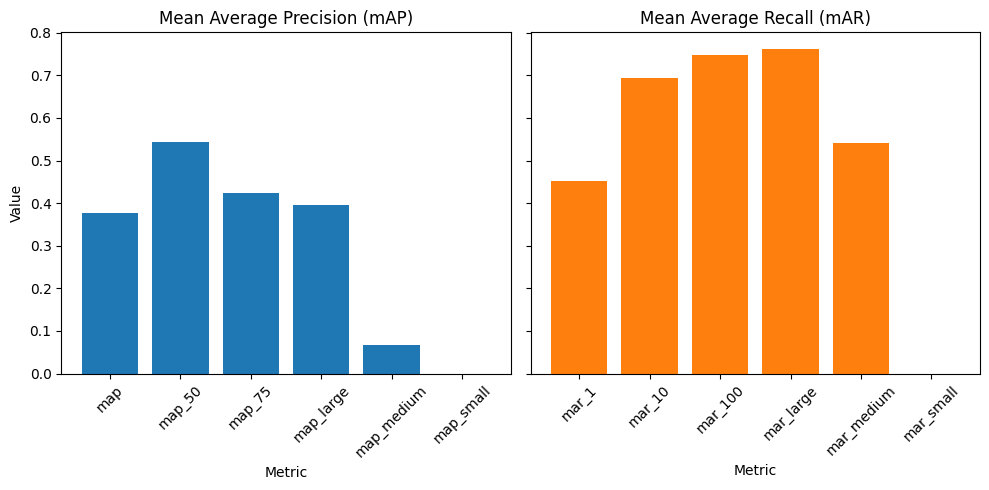

In [ ]:
import matplotlib.pyplot as plt

# Extract mAP and mAR metrics
test_map_metrics = {key: value for key, value in test_metric_outputs.items() if "map" in key}
test_mar_metrics = {key: value for key, value in test_metric_outputs.items() if "mar" in key}

# Get labels and values
test_map_labels, test_map_values = zip(*sorted(test_map_metrics.items()))
test_mar_labels, test_mar_values = zip(*sorted(test_mar_metrics.items()))

# Create a subplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)

# Add mAP values
ax[0].bar(test_map_labels, test_map_values)
ax[0].set_title("Mean Average Precision (mAP)")
ax[0].set_xlabel("Metric")
ax[0].set_ylabel("Value")
ax[0].tick_params(axis="x", rotation=45)

# Add mAR values
ax[1].bar(test_mar_labels, test_mar_values, color="tab:orange")
ax[1].set_title("Mean Average Recall (mAR)")
ax[1].set_xlabel("Metric")
ax[1].tick_params(axis="x", rotation=45)

plt.tight_layout()


Nice! It looks like our model generally has a higher recall than precision, this is most likely because we set our prediction probability threshold to 0.0 (`THRESHOLD=0.0`).

This means all possible predictions are allowed through, in turn leading to the highest possible recall metric.

Let's now visualize per class values.

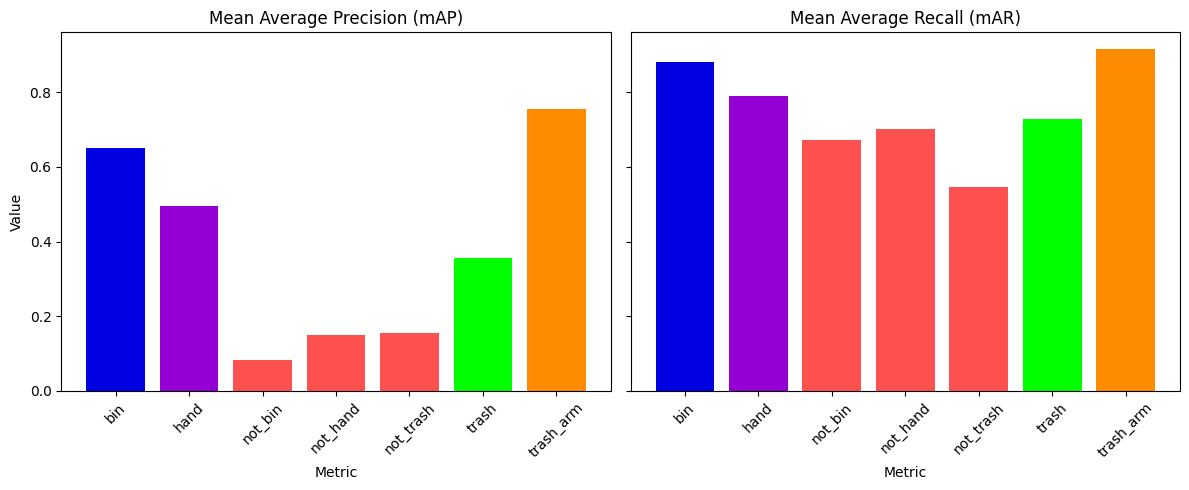

In [ ]:
# Map class names to metric values 
test_map_per_class_dict = dict(zip(list(label2id.keys()), test_map_per_class))
test_mar_per_class_dict = dict(zip(list(label2id.keys()), test_mar_per_class))

# Get labels and values
test_map_per_class_labels, test_map_per_class_values = zip(*sorted(test_map_per_class_dict.items()))
test_mar_per_class_labels, test_mar_per_class_values = zip(*sorted(test_mar_per_class_dict.items()))

# Create a list of RGB colour floats for matplotlib
label_to_colour_dict = {key: normalize_rgb(value) for key, value in colour_palette.items()}

colours_for_map = [label_to_colour_dict.get(label_name, (0.6, 0.6, 0.6)) for label_name in test_map_per_class_labels] # (0.6, 0.6, 0.6) = fallback to grey colour
colours_for_mar = [label_to_colour_dict.get(label_name, (0.6, 0.6, 0.6)) for label_name in test_mar_per_class_labels] # (0.6, 0.6, 0.6) = fallback to grey colour

# Create a subplot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True)

# Add mAP values
ax[0].bar(test_map_per_class_labels, 
          test_map_per_class_values,
          color=colours_for_map)
ax[0].set_title("Mean Average Precision (mAP)")
ax[0].set_xlabel("Metric")
ax[0].set_ylabel("Value")
ax[0].tick_params(axis="x", rotation=45)

# Add mAR values
ax[1].bar(test_mar_per_class_labels, 
          test_mar_per_class_values, 
          color=colours_for_mar)
ax[1].set_title("Mean Average Recall (mAR)")
ax[1].set_xlabel("Metric")
ax[1].tick_params(axis="x", rotation=45)

plt.tight_layout()

Beautiful!

It looks like our main target classes (`bin`, `hand`, `trash`) are performing quite similarly on precision and recall.

We could balance the prediction probability threshold depending on what we're trying to optimize for.

::: {.callout-note}
Which metric should you optimize for?

Precision or recall?

To avoid false positives, optimize for **precision** (higher predicition probability threshold), this will mean less predictions will be made overall but they will have a higher likelihood of being correct.

To avoid false negatives, optimize for **recall** (lower prediction probability threshold), more overall predictions will be made, making it more likely that items will not be missed.

Which you choose will depend on your problem space.

If you are in a safety critical space, you might want to optimize for **recall** (less chance of something being missed but more false positives).

If user experience matters most, for example, in a consumer app like Trashify, optimize for **recall**, users often find deleting wrong results preferable to adding missed items.

If a false positive predicition is costly, optimize for **precision**.
:::

### Evaluating and visualizing predictions one by one

We've seen how our model performs on the test dataset in metric form but nothing quite compares to visualizing actual predictions.

To do so, we'll extract a random sample from `processed_dataset["test"]`, pass it to our model, post process the outputs and then plot the predicted boxes on an actual image.

::: {.callout-note} 
If your predictions aren't the exact same as below, this is because of the randomness of machine learning, what's important is that the direction is similar. For example, do your loss curves go down and evaluation metrics trend up?

Ideally, your predictions will be not too dissimiliar.
:::

[INFO] Making predictions on test item with index: 163
[INFO] Total time to perform prediction: 0.07 seconds.
[INFO] Labels with scores:
Pred: hand (0.7147)
Pred: bin (0.555)
Pred: trash (0.5036)


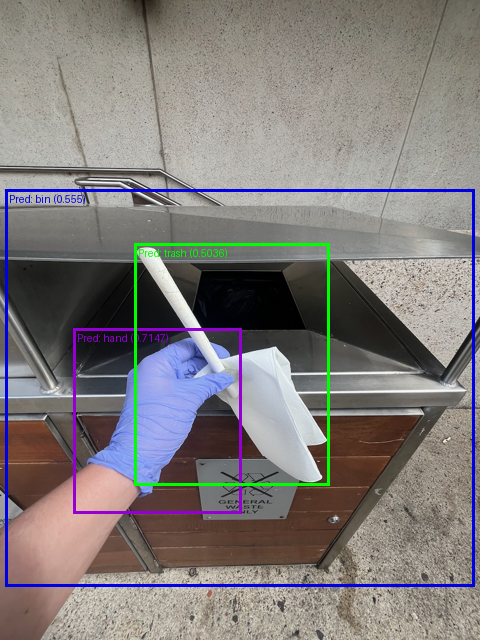

In [ ]:
import time

# Get a random sample from the test preds
random_test_pred_index = random.randint(0, len(processed_dataset["test"]))
print(f"[INFO] Making predictions on test item with index: {random_test_pred_index}")

# Get a random sample from the processed dataset
random_test_sample = processed_dataset["test"][random_test_pred_index]

# Do a single forward pass with the model (we'll time how long it takes for fun)
start_pred_time = time.time()
random_test_sample_outputs = model(pixel_values=random_test_sample["pixel_values"].unsqueeze(0).to("cuda"), # model expects input [batch_size, color_channels, height, width]
                                   pixel_mask=None)
end_pred_time = time.time()
print(f"[INFO] Total time to perform prediction: {round(end_pred_time - start_pred_time, 3)} seconds.")

# Post process a random item from test preds
random_test_sample_outputs_post_processed = image_processor.post_process_object_detection(
    outputs=random_test_sample_outputs,
    threshold=0.35, # prediction probability threshold for boxes (note: boxes from an untrained model will likely be bad)
    target_sizes=random_test_sample["labels"]["orig_size"].unsqueeze(0) # original input image size (or whichever target size you'd like), required to be same number of input items in a list
)

# Extract scores, labels and boxes
random_test_sample_pred_scores = random_test_sample_outputs_post_processed[0]["scores"]
random_test_sample_pred_labels = random_test_sample_outputs_post_processed[0]["labels"]
random_test_sample_pred_boxes = half_boxes(random_test_sample_outputs_post_processed[0]["boxes"])

# Create a list of labels and colours to plot on the boxes 
random_test_sample_pred_to_score_tuples = [(id2label[label_pred.item()], round(score_pred.item(), 4)) 
                                           for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]
random_test_sample_labels_to_plot = [f"Pred: {item[0]} ({item[1]})" for item in random_test_sample_pred_to_score_tuples]
random_test_sample_colours_to_plot = [colour_palette[item[0]] for item in random_test_sample_pred_to_score_tuples]

print(f"[INFO] Labels with scores:")
for label in random_test_sample_labels_to_plot:
    print(label)

# Plot the predicted boxes on the random test image 
test_pred_box_image = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=half_image(dataset["test"][random_test_pred_index]["image"])),
        boxes=random_test_sample_pred_boxes,
        colors=random_test_sample_colours_to_plot,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

test_pred_box_image

Nice! 

These prediction boxes look far better than our randomly predicted boxes with an untrained model.

::: {.callout-note}
If you have two predictions appearing for the same class on the image (e.g. two boxes around the `hand`), this can be remedied by post processing the predicted boxes with a technique called NMS (Non-maximum Suppression).

NMS can help to only keep the highest scoring box per class (the one with the *maximum* prediction probability).

This would mean that if there are two (or more) boxes predicted for the `hand` class, only the one with the highest prediction probability will remain. 

This same filtering technique can be applied to each predicted class.
:::

### Comparing our model's predicted boxes to the ground truth boxes

How about we compare our model's predicted boxes to the ground truth boxes?

To do so, we'll extract the same test sample from the test dataset, plot the ground truth boxes on it and then create a side by side comparison of truth versus predictions.

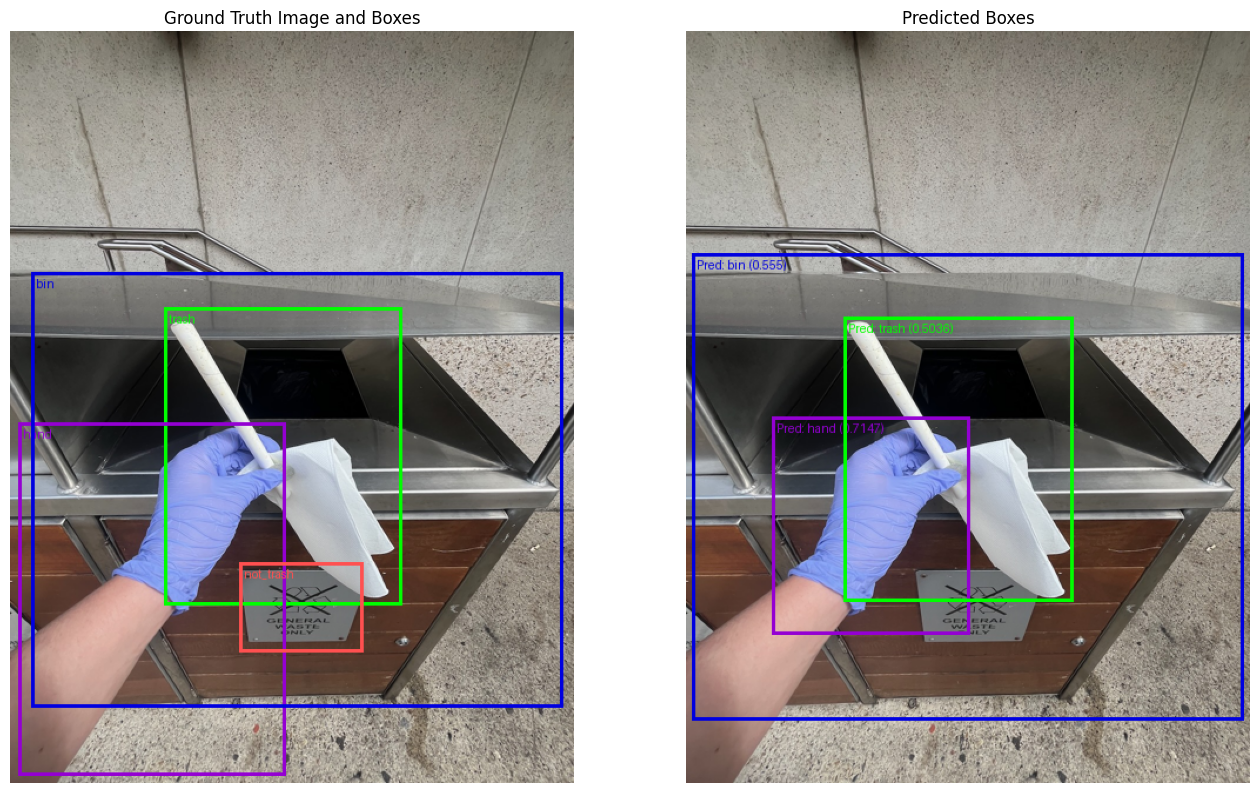

In [ ]:
# Get ground truth image
ground_truth_image = half_image(dataset["test"][random_test_pred_index]["image"])

# Get ground truth boxes (we'll convert these from CXCYWH -> XYXY to be in the same format as our prediction boxes)
ground_truth_boxes = [convert_bbox_cxcywh_to_xyxy_absolute(boxes=input_box,
                                                           image_size_target=random_test_sample["labels"]["orig_size"]) for input_box in random_test_sample["labels"]["boxes"]]
ground_truth_boxes = torch.stack(half_boxes(ground_truth_boxes))

# Get ground truth labels and colours
ground_truth_labels = [id2label[label.item()] for label in random_test_sample["labels"]["class_labels"]]
ground_truth_colours = [colour_palette[label] for label in ground_truth_labels]

# Create ground truth box plot image
test_ground_truth_box_image = to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=ground_truth_image),
        boxes=ground_truth_boxes,
        colors=ground_truth_colours,
        labels=ground_truth_labels,
        width=3
    )
)

# Plot ground truth image and boxes to predicted image and boxes
fig, ax = plt.subplots(ncols=2, figsize=(16, 10))
ax[0].imshow(test_ground_truth_box_image)
ax[0].set_title("Ground Truth Image and Boxes")
ax[0].axis(False)
ax[1].imshow(test_pred_box_image)
ax[1].set_title("Predicted Boxes")
ax[1].axis(False)

plt.show()

Woah! It looks like our model does fairly well to reproduce boxes that are similar to the ground truth.

There are some slight mistakes such as where our model predicts more than one of the same box in similar areas (this could be filtered later on with NMS or [non-maximum suppression](https://paperswithcode.com/method/non-maximum-suppression) which removes all but the highest prediction probability boxes for each class).

### Predict on image from the wild

We've seen how our model performs on test data which is similar to our training data.

But how does it do on an image from the wild?

For the image below, I searched for "person putting trash in bin" and selected one of the first images to appear.

You can see it at the URL: [`https://images.pexels.com/photos/7565384/pexels-photo-7565384.jpeg`](https://images.pexels.com/photos/7565384/pexels-photo-7565384.jpeg).

If this image doesn't work, we could even try our model on an AI generated image of a person throwing trash in a bin and see how it performs.

Let's write some code to download our target image from the URL above and save it to file.

[INFO] Saved to pexels-photo-7565384.jpeg


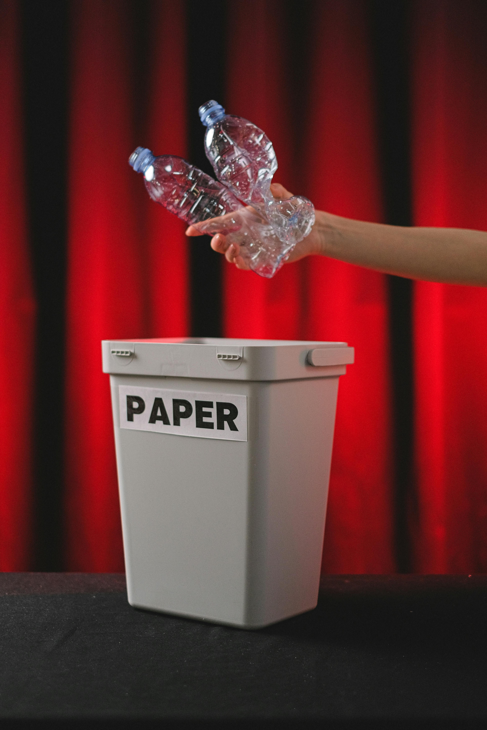

In [ ]:
import requests
from PIL import Image

# Example image of person putting trash in bin
url = "https://images.pexels.com/photos/7565384/pexels-photo-7565384.jpeg"
filename = "pexels-photo-7565384.jpeg"

# Donwload image
with requests.get(url, stream=True, timeout=10) as response:
    response.raise_for_status() # ensure the download succeeded
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

print(f"[INFO] Saved to {filename}")
image_from_wild = Image.open(filename)
for _ in range(3): # the default image is quite large so we'll half it three times
    image_from_wild = half_image(image_from_wild)
image_from_wild

Nice!

This one looks slightly different to some of the images our model saw during training, so it'll be interesting to see how it goes.

To make predictions on the downloaded image we'll go through the following steps:

1. Open the image.
2. Preprocess the image with `image_processor`.
3. Make predictions on the processed image with our `model`.
4. Get the original size of the image for doing box post processing conversions.
5. Set a prediction probability threshold of how confident we'd like our model to be in its predictions.
6. Post process our model's predictions.
7. Extract the post processed labels, scores and box coordinates.
8. Create a list of labels, scores and colours to plot.
9. Draw our model's predicted bounding boxes on the target image with `draw_bounding_boxes` and `to_pil_image`.

Let's do it!

[INFO] Test image size: tensor([640, 640])
[INFO] Labels with scores:
Pred: trash (0.7413)
Pred: trash (0.5808)
Pred: bin (0.4705)
Pred: trash (0.4051)
Pred: trash (0.4042)


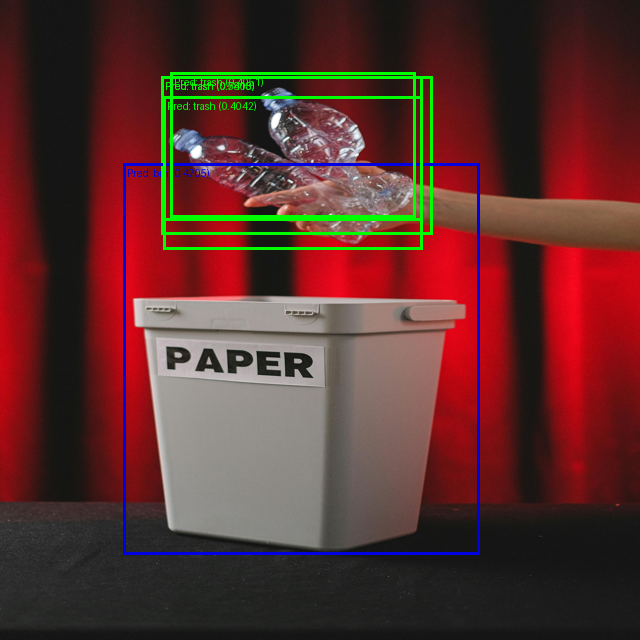

In [ ]:
# Pred on image from pathname
from pathlib import Path
from PIL import Image

def get_image_dimensions_from_pil(image: Image.Image) -> torch.tensor:
    """
    Convert the dimensions of a PIL image to a PyTorch tensor in the order (height, width).

    Args:
        image (Image.Image): The input PIL image.

    Returns:
        torch.Tensor: A tensor containing the height and width of the image.
    """
    # Get (width, height) of image (PIL.Image.size returns width, height)
    width, height = image.size

    # Convert to a tensor in the order (height, width)
    image_dimensions_tensor = torch.tensor([height, width])

    return image_dimensions_tensor

# Get a test image 
test_image_pil = Image.open("pexels-photo-7565384.jpeg").resize(size=(640, 640))

# Preprocess the image
test_image_preprocessed = image_processor.preprocess(images=test_image_pil,
                                                     return_tensors="pt")

# Make predictions on the preprocessed image
random_test_sample_outputs = model(pixel_values=test_image_preprocessed["pixel_values"].to("cuda"), # model expects input [batch_size, color_channels, height, width]
                                   pixel_mask=None)

# Get image original size
test_image_size = get_image_dimensions_from_pil(image=test_image_pil)
print(f"[INFO] Test image size: {test_image_size}")

# Create the threshold, we can adjust this based on how confident we'd like our model to be about its predictions
THRESHOLD = 0.4

# Post process the predictions
random_test_sample_outputs_post_processed = image_processor.post_process_object_detection(
    outputs=random_test_sample_outputs,
    threshold=THRESHOLD,
    target_sizes=test_image_size.unsqueeze(0) # needs to be same length as batch dimension of the logits (e.g. [[height, width]])
)

# Extract scores, labels and boxes
random_test_sample_pred_scores = random_test_sample_outputs_post_processed[0]["scores"]
random_test_sample_pred_labels = random_test_sample_outputs_post_processed[0]["labels"]
random_test_sample_pred_boxes = random_test_sample_outputs_post_processed[0]["boxes"]

# Create a list of labels to plot on the boxes 
random_test_sample_labels_to_plot = [f"Pred: {id2label[label_pred.item()]} ({round(score_pred.item(), 4)})"
                                     for label_pred, score_pred in zip(random_test_sample_pred_labels, random_test_sample_pred_scores)]
random_test_sample_colours_to_plot = [colour_palette[id2label[label_pred.item()]] for label_pred in random_test_sample_pred_labels]

print("[INFO] Labels with scores:")
for item in random_test_sample_labels_to_plot:
    print(item)

# Plot the predicted boxes on the random test image 
to_pil_image(
    pic=draw_bounding_boxes(
        image=pil_to_tensor(pic=test_image_pil),
        colors=random_test_sample_colours_to_plot,                     
        boxes=random_test_sample_pred_boxes,
        labels=random_test_sample_labels_to_plot,
        width=3
    )
)

How did the model do?

It's good to test on random images which may be in our domain (e.g. random photos or AI generated photos of someone putting trash in a bin), this way we can test to see if there are any conditions where our model fails.

In the example above, I noticed the model often fails to detect the hand.

This is likely because many of our training images are from first person point of views rather than third person point of views.

To fix this, we could incorportate more diverse training data into our pipeline.

## Uploading our trained model to Hugging Face Hub 

Since our model looks like it's working quite well, how about we upload to the Hugging Face Hub to make it accessible to others?

We'll first start by creating a path to save the model to locally.

Then we'll save the model to file using the [`transformers.Trainer.save_model`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.save_model) method.

In [ ]:
# Save the model
from datetime import datetime # optional: add a date of when we trained our model

# Get details to add to model's save path
training_epochs_ = training_args.num_train_epochs
learning_rate_ = "{:.0e}".format(training_args.learning_rate)

# Create model save path with some training details
model_save_path = f"models/learn_hf_rt_detrv2_finetuned_trashify_box_dataset_only_manual_data_no_aug_{training_epochs_}_epochs_lr_{learning_rate_}"

# Save model to file
print(f"[INFO] Saving model to: {model_save_path}")
model_v1_trainer.save_model(model_save_path)

[INFO] Saving model to: models/learn_hf_rt_detrv2_finetuned_trashify_box_dataset_only_manual_data_no_aug_10_epochs_lr_1e-04


Now let's make sure we add our model's `image_processor` to the our `Trainer` instance, so when someone loads our model, it automatically knows how to preprocess an input sample.

This is usually done automatically but I've run into some issues in the past where the model doesn't load the preprocessor.

To do this we can see the [`processing_class`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.processing_class) attribute of `model_v1_trainer` to be our `image_processor`.

In [ ]:
# Make sure trainer has the processor class (this can sometimes be automatically assigned, however, we'll hard code it just to be safe)
model_v1_trainer.processing_class = image_processor

Nice!

Now let's push our `model_v1_trainer` to the Hugging Face Hub using [`transformers.Trainer.push_to_hub`](https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.Trainer.push_to_hub) (this will push our trained model and processing class to the Hugging Face Hub).

::: {.callout-note}

Whenever you try to push something to the Hugging Face Hub, make sure you've got your Hugging Face account and token credentials setup correctly.

See the [Hugging Face setup guide](https://www.learnhuggingface.com/extras/setup) for a walkthrough of how to do this.

:::

In [ ]:
# Push the model to the hub
# Note: this will require you to have your Hugging Face account setup 
model_on_hub_url = model_v1_trainer.push_to_hub(commit_message="upload fine-tuned RT-DETRv2 trashify object detection model",
                                                # token=None # Optional to add a token manually
                                                )

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.78k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

Perfect! Our model has been uploaded to the Hugging Face Hub. 

If no changes have been made to a previously uploaded model file, you might see a message like the following:

> No files have been modified since last commit. Skipping to prevent empty commit.

Otherwise, we can check the commit URL of our model using the `commit_url` attribute.

In [ ]:
print(f"[INFO] Our model has been uploaded with the following commit URL: {model_on_hub_url.commit_url}")

[INFO] Our model has been uploaded with the following commit URL: https://huggingface.co/mrdbourke/rt_detrv2_finetuned_trashify_box_detector_v1/commit/46003b6b8f8e9855a0d8979ba5cdb1b8ca437646


## Creating a demo of our model with Gradio

One of the best ways to share your machine learning work is by creating a demo application.

And one of the best places to share your applications is [Hugging Face Spaces](https://huggingface.co/docs/hub/spaces).

Hugging Face Spaces allows you to host machine learning (and non-machine learning) applications for free (with [optional paid hardware upgrades](https://huggingface.co/docs/hub/spaces-overview#hardware-resources)).

If you're familiar with GitHub, Hugging Face Spaces works similar to a GitHub repository (each Space is a Git repository itself).

If not, that's okay, think of Hugging Face Spaces as an online folder where you can upload your files and have them accessed by others.

Creating a Hugging Face Space can be done in two main ways:

1. **Manually** - By going to the [Hugging Face Spaces](https://huggingface.co/spaces) website and clicking "Create new space". Or by going directly to [https://www.huggingface.co/new-space](https://huggingface.co/new-space). Here, you'll be able to setup a few settings for your Space and choose the framework/runtime (e.g. Streamlit, Gradio, Docker and more).
2. **Programmatically** - By using the [Hugging Face Hub Python API](https://huggingface.co/docs/huggingface_hub/package_reference/hf_api) we can write code to [directly upload files to the Hugging Face Hub](https://www.gradio.app/guides/using-hugging-face-integrations#hosting-your-gradio-demos-on-spaces), including Hugging Face Spaces.

Both are great options but we're going to take the second approach.

This is so we can create our Hugging Face Space right from this notebook.

To do so, we'll create three files and a folder:

1. `app.py` (main file that Hugging Face Spaces looks for) - This will be the Python file which will be the main running file on our Hugging Face Space. Inside we'll include all the code necessary to run our Gradio demo (as above). Hugging Face Spaces will automatically recoginize the `app.py` file and run it for us.
2. `requirements.txt` - This text file will include all of the Python packages we need to run our `app.py` file. Before our Space starts to run, all of the packages in this file will be installed.
3. `README.md` - This markdown file will include details about our Space as well as specific Space-related metadata (we'll see this later on).
4. `trashify_examples/` - This folder will contain several images that our Trashify demo will showcase as examples in the demo.

We'll create these files with the following file structure:

```
demos/
└── trashify_object_detector/
    ├── app.py
    ├── README.md
    ├── requirements.txt
    └── trashify_examples/
        ├── trashify_example_1.jpeg
        ├── trashify_example_2.jpeg
        └── trashify_example_3.jpeg
```

Why this way?

Doing it in the above style means we'll have a directory which contains all of our demos (`demos/`) as well as a dedicated directory which contains our Trashify demo application (`trashify_object_detector/`).

This way, we'll be able to upload the whole `demos/trashify_object_detector/` folder to Hugging Face Spaces.

Let's start by making a directory to store our demo application files.

In [ ]:
# Setup path to trashify demo folder (we'll store all of our demo requirements in here)
demo_path = Path("../demos/trashify_object_detector")

# Create the directory
demo_path.mkdir(parents=True, exist_ok=True)

### Making an app file

UPTOHERE - write the steps required for the app.py file

Our `app.py` file will be the main part of our Hugging Face Space.

Inside the `app.py` file we'll:

1. Import the required libraries/packages for running our demo app.
2. Setup preprocessing and helper functions for our trained ojbect detection model. Because our model is already hosted on the Hugging Face Hub, we can load it directly with [`transformers.AutoModelForObjectDetection.from_pretrained`](https://huggingface.co/docs/transformers/en/model_doc/auto#transformers.AutoModelForObjectDetection) and passing it our model's name (e.g. `mrdbourke/rt_detrv2_finetuned_trashify_box_detector_v1`) and when we upload our `app.py` file to Hugging Face Spaces, it will load the model directly from the Hub.
    * **Note:** Be sure to change "`mrdbourke`" to your own Hugging Face username.
3. Create a function `predict_on_image` to:
    * Take in an image and confidence threshold.
    * Predict on the image with our model.
    * Post process the predictions.
    * Draw the predictions on the target image (see step 4).
    * Return the target image with drawn predictions as well as a text label output as to whether trash, bin and hand were detected (see step 4).
4. We'll draw the model's predicted boxes (if there are any) on the image with [`PIL.ImageDraw`](https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html). 
5. Write some logic to detect whether trash, bin and hand objects are detected as this is the overall goal of Trashify, so if all three are present, we'll output a message saying +1! for the person picking up trash.
6. We'll create a demo using Gradio's [`gr.Interface`](https://www.gradio.app/docs/gradio/interface) class. This will take an image and float as `inputs` as well as an image and string as `outputs`. We can add descriptions and other information to our demo so they are visible in the live app. To finish off, we'll launch the demo with [`gr.Interface.launch`](https://www.gradio.app/docs/gradio/interface#interface-launch).

We can write all of the above in a notebook cell.

And we can turn it into a file by using the [`%%writefile`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) magic command and passing it our target filepath.

Let's do it!

In [ ]:
%%writefile ../demos/trashify_object_detector/app.py

# 1. Import the required libraries and packages
import gradio as gr
import torch
from PIL import Image, ImageDraw, ImageFont # could also use torch utilities for drawing

from transformers import AutoImageProcessor
from transformers import AutoModelForObjectDetection

### 2. Setup preprocessing and helper functions ###

# Setup target model path to load
# Note: Can load from Hugging Face or can load from local 
model_save_path = "mrdbourke/rt_detrv2_finetuned_trashify_box_detector_v1"

# Load the model and preprocessor
# Because this app.py file is running directly on Hugging Face Spaces, the model will be loaded from the Hugging Face Hub
image_processor = AutoImageProcessor.from_pretrained(model_save_path)
model = AutoModelForObjectDetection.from_pretrained(model_save_path)

# Set the target device (use CUDA/GPU if it is available)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Get the id2label dictionary from the model
id2label = model.config.id2label

# Set up a colour dictionary for plotting boxes with different colours
color_dict = {   
    "bin": "green",
    "trash": "blue",
    "hand": "purple",
    "trash_arm": "yellow",
    "not_trash": "red",
    "not_bin": "red",
    "not_hand": "red",
}

# Create helper functions for seeing if items from one list are in another 
def any_in_list(list_a, list_b):
    "Returns True if *any* item from list_a is in list_b, otherwise False."
    return any(item in list_b for item in list_a)

def all_in_list(list_a, list_b):
    "Returns True if *all* items from list_a are in list_b, otherwise False."
    return all(item in list_b for item in list_a)

### 3. Create function to predict on a given image with a given confidence threshold ###
def predict_on_image(image, conf_threshold):
    # Make sure model is in eval mode
    model.eval()

    # Make a prediction on target image 
    with torch.no_grad():
        inputs = image_processor(images=[image], return_tensors="pt")
        model_outputs = model(**inputs.to(device))

        target_sizes = torch.tensor([[image.size[1], image.size[0]]]) # -> [batch_size, height, width] 
        
        # Post process the raw outputs from the model 
        results = image_processor.post_process_object_detection(model_outputs,
                                                                threshold=conf_threshold,
                                                                target_sizes=target_sizes)[0]

    # Return all items in results to CPU (we'll want this for displaying outputs with matplotlib)
    for key, value in results.items():
        try:
            results[key] = value.item().cpu() # can't get scalar as .item() so add try/except block
        except:
            results[key] = value.cpu()

    ### 4. Draw the predictions on the target image ###

    # Can return results as plotted on a PIL image (then display the image)
    draw = ImageDraw.Draw(image)

    # Get a font from ImageFont
    font = ImageFont.load_default(size=20)

    # Get class names as text for print out
    class_name_text_labels = []

    # Iterate through the predictions of the model and draw them on the target image
    for box, score, label in zip(results["boxes"], results["scores"], results["labels"]):
        # Create coordinates
        x, y, x2, y2 = tuple(box.tolist())

        # Get label_name
        label_name = id2label[label.item()]
        targ_color = color_dict[label_name]
        class_name_text_labels.append(label_name)

        # Draw the rectangle
        draw.rectangle(xy=(x, y, x2, y2), 
                       outline=targ_color,
                       width=3)
        
        # Create a text string to display
        text_string_to_show = f"{label_name} ({round(score.item(), 3)})"

        # Draw the text on the image
        draw.text(xy=(x, y),
                  text=text_string_to_show,
                  fill="white",
                  font=font)
    
    # Remove the draw each time
    del draw

    # Setup blank string to print out
    return_string = ""

    # Setup list of target items to discover
    target_items = ["trash", "bin", "hand"]

    ### 5. Create logic for outputting information message ### 

    # If no items detected or trash, bin, hand not in list, return notification 
    if (len(class_name_text_labels) == 0) or not (any_in_list(list_a=target_items, list_b=class_name_text_labels)):
        return_string = f"No trash, bin or hand detected at confidence threshold {conf_threshold}. Try another image or lowering the confidence threshold."
        return image, return_string

    # If there are some missing, print the ones which are missing
    elif not all_in_list(list_a=target_items, list_b=class_name_text_labels):
        missing_items = []
        for item in target_items:
            if item not in class_name_text_labels:
                missing_items.append(item)
        return_string = f"Detected the following items: {class_name_text_labels}. But missing the following in order to get +1: {missing_items}. If this is an error, try another image or altering the confidence threshold. Otherwise, the model may need to be updated with better data."
        
    # If all 3 trash, bin, hand occur = + 1
    if all_in_list(list_a=target_items, list_b=class_name_text_labels):
        return_string = f"+1! Found the following items: {class_name_text_labels}, thank you for cleaning up the area!"

    print(return_string)
    
    return image, return_string

### 6. Setup the demo application to take in image, make a prediction with our model, return the image with drawn predicitons ### 

# Write description for our demo application
description = """
Help clean up your local area! Upload an image and get +1 if there is all of the following items detected: trash, bin, hand.

Model is a fine-tuned version of [RT-DETRv2](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2#transformers.RTDetrV2Config) on the [Trashify dataset](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

See the full data loading and training code on [learnhuggingface.com](https://www.learnhuggingface.com/notebooks/hugging_face_object_detection_tutorial).

This version is v4 because the first three versions were using a different model and did not perform as well, see the [README](https://huggingface.co/spaces/mrdbourke/trashify_demo_v4/blob/main/README.md) for more.
"""

# Create the Gradio interface to accept an image and confidence threshold and return an image with drawn prediction boxes
demo = gr.Interface(
    fn=predict_on_image,
    inputs=[
        gr.Image(type="pil", label="Target Image"),
        gr.Slider(minimum=0, maximum=1, value=0.3, label="Confidence Threshold")
    ],
    outputs=[
        gr.Image(type="pil", label="Image Output"),
        gr.Text(label="Text Output")
    ],
    title="🚮 Trashify Object Detection Demo V4",
    description=description,
    # Examples come in the form of a list of lists, where each inner list contains elements to prefill the `inputs` parameter with
    # See where the examples originate from here: https://huggingface.co/datasets/mrdbourke/trashify_examples/
    examples=[
        ["trashify_examples/trashify_example_1.jpeg", 0.3],
        ["trashify_examples/trashify_example_2.jpeg", 0.3], 
        ["trashify_examples/trashify_example_3.jpeg", 0.3],
    ],
    cache_examples=True
)

# Launch the demo
demo.launch()

Overwriting ../demos/trashify_object_detector/app.py


### Making a requirements file

When you upload an `app.py` file to Hugging Face Spaces, it will attempt to run it automatically.

And just like running the file locally, we need to make sure all of the required packages are available.

Otherwise our Space will produce an error like the following:

```
===== Application Startup at ... =====

Traceback (most recent call last):
  File "/home/user/app/app.py", line 1, in <module>
    import torch
ModuleNotFoundError: No module named 'torch'
```

Good news is, our demo only has three requirements: `gradio`, `torch`, `transformers`.

Let's create a `requirements.txt` file with the packages we need and save it to the same directory as our `app.py` file.

%%writefile ../demos/trashify_object_detector/requirements.txt
timm
gradio
torch
transformers

### Making a README file

Our `app.py` can contain information about our demo, however, we can also use a `README.md` file to further communicate our work.

::: {.callout-note}

It is common practice in Git repositories (including GitHub and Hugging Face Hub) to add a `README.md` file to your project so people can read more (hence "read me") about what your project is about.

:::

We can include anything in [markdown-style text](https://huggingface.co/docs/hub/en/spaces-config-reference) in the `README.md` file.

However, Spaces also have a special [YAML block](https://simple.wikipedia.org/wiki/YAML) at the top of the `README.md` file in the root directory with configuration details.

Inside the YAML block you can put special metadata details about your Space including:

* `title` - The title of your Space (e.g. `title: Trashify Demo V4 🚮`).
* `emoji` - The emoji to display on your Space (e.g. `emoji: 🗑️`).
* `app_file` - The target app file for Spaces to run (set to `app_file: app.py` by default).

And there are plenty more in the [Spaces Configuration References documentation](https://huggingface.co/docs/hub/en/spaces-config-reference).

<figure style="text-align: center;">
    <!-- figtemplate -->
    <img src="https://huggingface.co/datasets/mrdbourke/learn-hf-images/resolve/main/learn-hf-trashify-object-detection/09-trashify-spaces-front-matter.png"
     alt="A screenshot of a Hugging Face Space 'README.md' editor for 'trashify_demo_v4', divided into two green-outlined sections: the top section, labeled 'YAML front matter', displays a 'Metadata UI' with fields for 'license' (Apache License 2.0), 'sdk' (Gradio), 'colorFrom' (purple), etc., and below it, the corresponding YAML code with 'title: Trashify Demo V4', 'emoji: 🗑️', 'colorFrom: purple', and other settings; the bottom section, labeled 'Markdown description', shows the markdown content starting with '# 🗑️ Trashify Object Detector V4', followed by descriptions under '## Dataset', '## Demos', and '## Learn more', including links to datasets and other demo versions." 
     style="width: 100%; max-width: 900px; height: auto;"/>
     <figcaption>Example of Hugging Face Spaces README.md file with YAML front matter (front matter is another term for "things at the front/top of the file") for formatting the Space.</figcaption>
</figure>

Let's create a `README.md` file with a YAML block at the top detailing some of the metadata about our project.

::: {.callout-note}

The YAML block at the top of the `README.md` can take some practice. 

If you want to see a demo of how one gets created, try making a Hugging Face Space with the "Create new Space" button on the [https://huggingface.co/spaces](https://huggingface.co/spaces) page and seeing what the `README.md` file starts with (that's how I found out what to do!).

:::

In [ ]:
%%writefile ../demos/trashify_object_detector/README.md
---
title: Trashify Demo V4 🚮
emoji: 🗑️
colorFrom: purple
colorTo: blue
sdk: gradio
sdk_version: 5.34.0
app_file: app.py
pinned: false
license: apache-2.0
---

# 🚮 Trashify Object Detector V4 

Object detection demo to detect `trash`, `bin`, `hand`, `trash_arm`, `not_trash`, `not_bin`, `not_hand`. 

Used as example for encouraging people to cleanup their local area.

If `trash`, `hand`, `bin` all detected = +1 point.

## Dataset

All Trashify models are trained on a custom hand-labelled dataset of people picking up trash and placing it in a bin.

The dataset can be found on Hugging Face as [`mrdbourke/trashify_manual_labelled_images`](https://huggingface.co/datasets/mrdbourke/trashify_manual_labelled_images).

## Demos

* [V1](https://huggingface.co/spaces/mrdbourke/trashify_demo_v1) = Fine-tuned [Conditional DETR](https://huggingface.co/docs/transformers/en/model_doc/conditional_detr) model trained *without* data augmentation.
* [V2](https://huggingface.co/spaces/mrdbourke/trashify_demo_v2) = Fine-tuned Conditional DETR model trained *with* data augmentation.
* [V3](https://huggingface.co/spaces/mrdbourke/trashify_demo_v3) = Fine-tuned Conditional DETR model trained *with* data augmentation (same as V2) with an NMS (Non Maximum Suppression) post-processing step.
* [V4](https://huggingface.co/spaces/mrdbourke/trashify_demo_v4) = Fine-tuned [RT-DETRv2](https://huggingface.co/docs/transformers/main/en/model_doc/rt_detr_v2) model trained *without* data augmentation or NMS post-processing (current best mAP).

## Learn more

See the full end-to-end code of how this demo was built at [learnhuggingface.com](https://www.learnhuggingface.com/notebooks/hugging_face_object_detection_tutorial). 

Overwriting ../demos/trashify_object_detector/README.md


### Making an examples folder 

When we create our demo application, it'll be good to show people how to use it.

To do so, we can add some example images to use with our demo.

First we'll create a folder to store the demo images.

In [ ]:
# Make a directory to save examples to
from pathlib import Path

demo_example_dir = "../demos/trashify_object_detector/trashify_examples/"
Path(demo_example_dir).mkdir(exist_ok=True, parents=True)

And now we can download some pre-made examples I've added to Hugging Face Datasets (none of these were in the Trashify training data).

You can find the example Trashify images at [`mrdbourke/trashify_examples`](https://huggingface.co/datasets/mrdbourke/trashify_examples). 

In [ ]:
# Download the examples from Hugging Face Datasets
from datasets import load_dataset

trashify_examples = load_dataset("mrdbourke/trashify_examples")
trashify_examples

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 3
    })
})

Perfect!

Now let's save each of these images to our target example folder in the Trashify demo directory.

In [ ]:
for i, sample in enumerate(trashify_examples["train"]):
    save_path = Path(demo_example_dir, f"trashify_example_{i+1}.jpeg")
    print(f"[INFO] Saving image to: {save_path}")
    sample["image"].save(save_path)

[INFO] Saving image to: ../demos/trashify_object_detector/trashify_examples/trashify_example_1.jpeg
[INFO] Saving image to: ../demos/trashify_object_detector/trashify_examples/trashify_example_2.jpeg
[INFO] Saving image to: ../demos/trashify_object_detector/trashify_examples/trashify_example_3.jpeg


Now let's check the demo folder for Trashify.

In [ ]:
!ls ../demos/trashify_object_detector/

README.md  app.py  requirements.txt  trashify_examples


Perfect!

Looks like we've got all the files we need to create our Space.

Let's upload them to the Hugging Face Hub.

### Uploading our demo to Hugging Face Spaces

We've created all of the files required for our demo, now for the fun part!

Let's upload them to Hugging Face Spaces.

To do so programmatically, we can use the [Hugging Face Hub Python API](https://huggingface.co/docs/huggingface_hub/en/package_reference/hf_api).

::: {.callout-note}

The [Hugging Face Hub Python API](https://huggingface.co/docs/huggingface_hub/en/package_reference/hf_api) has many different options for interacting with the Hugging Face Hub programmatically.

You can create repositories, upload files, upload folders, add comments, change permissions and much much more.

Be sure to explore the documentation for at least 10-15 minutes to get an idea of what's possible.

:::

To get our demo hosted on Hugging Face Spaces we'll go through the following steps:

1. Import the required methods from the `huggingface_hub` package, including [`create_repo`](https://huggingface.co/docs/huggingface_hub/package_reference/hf_api#huggingface_hub.HfApi.create_repo), [`get_full_repo_name`](https://huggingface.co/docs/huggingface_hub/package_reference/hf_api#huggingface_hub.HfApi.get_full_repo_name), [`upload_file`](https://huggingface.co/docs/huggingface_hub/en/package_reference/hf_api#huggingface_hub.HfApi.upload_file) (optional, we'll be using `upload_folder`) and [`upload_folder`](https://huggingface.co/docs/huggingface_hub/en/package_reference/hf_api#huggingface_hub.HfApi.upload_folder).
2. Define the demo folder we'd like to upload as well as the different parameters for the Hugging Face Space such as repo type (`"space"`), our target Space name, the target Space SDK (`"gradio"`), our [Hugging Face token](https://huggingface.co/docs/hub/en/security-tokens) with write access (optional if it already isn't setup).
3. Create a repository on Hugging Face Spaces using the `huggingface_hub.create_repo` method and filling out the appropriate parameters.
4. Get the full name of our created repository using the `huggingface_hub.get_full_repo_name` method (we could hard code this but I like to get it programmatically incase things change).
5. Upload the contents of our target demo folder (`../demos/trashify_object_detector/`) to Hugging Face Hub with [`huggingface_hub.upload_folder`](https://huggingface.co/docs/huggingface_hub/en/package_reference/hf_api#huggingface_hub.HfApi.upload_folder).
6. Hope it all works and inspect the results! 🤞

A fair few steps but we've got this!

In [ ]:
# 1. Import the required methods for uploading to the Hugging Face Hub
from huggingface_hub import (
    create_repo,
    get_full_repo_name,
    upload_file, # for uploading a single file (if necessary)
    upload_folder # for uploading multiple files (in a folder)
)

# 2. Define the parameters we'd like to use for the upload
LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD = "../demos/trashify_object_detector" 
HF_TARGET_SPACE_NAME = "trashify_demo_v4"
HF_REPO_TYPE = "space" # we're creating a Hugging Face Space
HF_SPACE_SDK = "gradio"
HF_TOKEN = "" # optional: set to your Hugging Face token (but I'd advise storing this as an environment variable as previously discussed)

# 3. Create a Space repository on Hugging Face Hub 
print(f"[INFO] Creating repo on Hugging Face Hub with name: {HF_TARGET_SPACE_NAME}")
create_repo(
    repo_id=HF_TARGET_SPACE_NAME,
    # token=HF_TOKEN, # optional: set token manually (though it will be automatically recognized if it's available as an environment variable)
    repo_type=HF_REPO_TYPE,
    private=False, # set to True if you don't want your Space to be accessible to others
    space_sdk=HF_SPACE_SDK,
    exist_ok=True, # set to False if you want an error to raise if the repo_id already exists 
)

# 4. Get the full repository name (e.g. {username}/{model_id} or {username}/{space_name})
full_hf_repo_name = get_full_repo_name(model_id=HF_TARGET_SPACE_NAME)
print(f"[INFO] Full Hugging Face Hub repo name: {full_hf_repo_name}")

# 5. Upload our demo folder
print(f"[INFO] Uploading {LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD} to repo: {full_hf_repo_name}")
folder_upload_url = upload_folder(
    repo_id=full_hf_repo_name,
    folder_path=LOCAL_DEMO_FOLDER_PATH_TO_UPLOAD,
    path_in_repo=".", # upload our folder to the root directory ("." means "base" or "root", this is the default)
    # token=HF_TOKEN, # optional: set token manually
    repo_type=HF_REPO_TYPE,
    commit_message="Uploading Trashify box detection model app.py"
)
print(f"[INFO] Demo folder successfully uploaded with commit URL: {folder_upload_url}")

[INFO] Creating repo on Hugging Face Hub with name: trashify_demo_v4
[INFO] Full Hugging Face Hub repo name: mrdbourke/trashify_demo_v4
[INFO] Uploading ../demos/trashify_object_detector to repo: mrdbourke/trashify_demo_v4
[INFO] Demo folder successfully uploaded with commit URL: https://huggingface.co/spaces/mrdbourke/trashify_demo_v4/tree/main/.


Woohoo!! Looks like our demo is now live on the Hugging Face Hub!

### Testing the hosted demo

We are showing Trashify v4 because like Star Wars episodes, I've already done a few experiments before launching it.

One of the cool things about using Hugging Facce Spaces is we can embed the Space in our notebook using HTML.

To do so, you can click the "..." button (three dots) in the top right hand corner of the Hugging Face Space and choose the option "Embed this Space".

To embed it with HTML, you can choose the `Iframe` option.

In [ ]:
from IPython.display import HTML

# You can get embeddable HTML code for your demo by clicking the "Embed" button on the demo page
HTML(data='''
<iframe
    src="https://mrdbourke-trashify-demo-v4.hf.space"
    frameborder="0"
    width="850"
    height="1000"
></iframe>     
''')

Isn't that cool!

Our very our object detection model trained on a custom dataset and now live on the internet for other people to try out!

## Summary 

We've followed the data, model, demo paradigm and built a custom object detection model on a custom dataset and deployed it into a functional demo.

Object detection models can be a bit of challenge to begin with as you need coordinate data for items in your images as well as label data.

However, as we've seen, with the right mix of data, model and training techniques we can take an existing object detection model like RT-DETRv2 and tailor it to our own projects.

The following extensions and extra-curriculum are good follow ups to practice what we've learned here.

### Extensions 

* Can you improve the model by training it for longer? What happens if you double the amount of epochs we did?
* What are some ways to improve the model on differnet kinds of data? Could you take 10-30 photos of your own and add it to the dataset to improve the model?
* Data augmentation is one way to improve image classification models but it can also work for object detection models, how might you implement data augmentation into our training pipeline?
    * Hint: See [PyTorch's guide for data augmentation on detection problems](https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#transforms-v2-end-to-end-object-detection-segmentation-example). 
* So far the RT-DETRv2 model we used seemed to work pretty well, what happens if you try the [D-FINE model](https://huggingface.co/docs/transformers/main/model_doc/d_fine)?
* Sometimes our model predicts multiple of the same kind of boxes, for example, it will predict 2 boxes for "hand" when there is only one, a technique to help with this is called NMS ([Non Maximum Suppression](https://paperswithcode.com/method/non-maximum-suppression)), how might you implement this into our post processing pipeline?
* How does our model perform when removing the `"not_X"` classes? For example, only have the positive classes (`"bin", "trash", "hand"`) in the training data. Does the model naturally learn what is `"not_bin", "not_hand", "not_trash"`? For example, distinguishing background items from non-background items?


### Extra-Curriculum 

* "But what if I have images but no box labels?" Great questions. One way to acquire labels is to use a zero-shot detection model such as [OmDet Turbo](https://huggingface.co/omlab/omdet-turbo-swin-tiny-hf) or [Grounding DINO](https://huggingface.co/docs/transformers/en/model_doc/grounding-dino) which are capable of producing box labels on images given a text input. You could use these to bootstrap a labelled dataset and then train a custom model on them/improve them by reviewing.
* Another way to get high quality labels is to manually annotate images, you can do with tools such as [Label Studio](https://labelstud.io) and [Prodigy](https://prodi.gy/).
* For more on the RT-DETRv2 model, I'd encourage you to read the original paper where it was introduced, [*RT-DETRv2: Improved Baseline with Bag-of-Freebies for Real-Time Detection Transformer*](https://huggingface.co/papers/2407.17140).


### Extra resources

* [Apache 2.0 object detector models](https://www.learnml.io/posts/apache-object-detection-models/) - For a list of high-performing Apache 2.0 (permissive open-source licence which enables commercial use) object detection models, I've created a short guide which collects them.
* [`supervision` library](https://github.com/roboflow/supervision) - An excellent open-source library with plenty of visualization utilities for computer vision projects.
* [Object detection evaluation metrics](https://blog.roboflow.com/object-detection-metrics/) by Roboflow - This is a great guide to all of the important detection metrics you'll want to look at when creating object detection models.
* [A Guide to Bounding Box Formats and How to Draw Them](https://www.learnml.io/posts/a-guide-to-bounding-box-formats/) by Daniel Bourke - One of the most important things when it comes to evaluating object detection models is to see how they look on images, this guide shows you how to draw bounding boxes on images.
* [A Hands-on Guide to IoU (Intersection over Union) for Bounding Boxes](https://www.learnml.io/posts/a-gentle-guide-to-intersection-over-union/) by Daniel Bourke - Intersection over Union (IoU) is a measure of how much one box overlaps another and is used for evaluating the quality of your predicted bounding boxes, this guide walks through code examples of calculating IoU.